# Exercise 04): Monte-Carlo Methods

In this exercise we make use of the racetrack environment (racetrack_environment.py) to test Monte-Carlo methods.

For the start, please execute the following cells.

In [7]:
import numpy as np
import random
import sys
from racetrack_environment import RaceTrackEnv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.style.use('dark_background')

Execute the follwoing cell to built a race track using the `RaceTrackEnv` as a test scenario.  

WWWWWWWWWWWW
WWWWW-oooooW
WWWWW-oooooW
WWWWW-oooooW
WWWWWWWWWooW
WWWWWWWWWooW
WWWWW+oooooW
WWWWW+oooooW
WWWWW+oooooW
WWWWWWWWWWWW


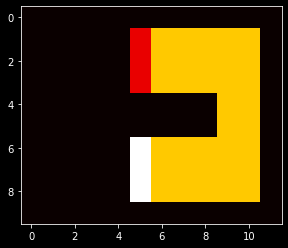

In [8]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_uturn_course(course_dim, inner_wall_dim):
    """
    Build a race track for the u-turn street scenario.
    Start and finish line are placed in the center top and bottom respectively. The course dimension specifications
    do not consider a bounding wall around the track, which is inserted additionally. 

    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'W'*(half_street_len//2+1) + 'W-' + 'o'*(half_street_len-1+half_street_len//2)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'W'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'W'*(half_street_len//2+1) + 'W+' + 'o'*(half_street_len-1+half_street_len//2)
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plt.imshow(pos_map, cmap='hot', interpolation='nearest')
plt.show()

## 1) Monte-Carlo-Based Policy Evaluation

Write a first-visit Monte-Carlo algorithm to evaluate the dummy policy as defined below on the U-turn course. The dummy policy turns the car to the right as soon as it stands in front of a wall. Try to understand how the policy works before you start to code. Actions (accelerations in given directions) are encoded according to the following diagram:

![](Directions_Legend.png)

How can we interprete the state values resulting from the evaluation with first-visit Monte-Carlo?

## 1) Solution

Algorithm given below.

The simple and deterministic dummy policy will always guarantee the car to reach the finish line. Thus, the state values can be interpreted as the number of timesteps that is necessary to reach the goal from that specific state (i.e. position and velocity) if we are following the policy.

In [9]:
### Select course and initialize dummy policy

course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_pi = np.ones([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY]) * 4 

dummy_slow_pi[:track.bounds[0]//2, :, 0 , 0] = 5   # go right
dummy_slow_pi[:track.bounds[0]//2, -2:, 0 , :] = 6 # go bottom left
dummy_slow_pi[-2:, track.bounds[1]//2:, : , 0] = 0 # go top left

pi = dummy_slow_pi

In [10]:
# initialize the value function
values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY])

# initialize an empty dict to count the number of visits
n_dict = {}

# configuration parameters
gamma = 1 # discount factor
no_episodes = 500 # number of evaluated episodes
no_steps = 2000 # number of allowed timesteps per episode

for e in tqdm(range(no_episodes), position=0, leave=True):
    
    # initialize variables in which collected data will be stored
    states = [] # list of tuples
    rewards = [] # list of floats
    visited_states = set() # set of tuples
    first_visit_list = [] # list of booleans
    
    ### BEGIN SOLUTION
    
    # reset environment and start episode
    p, v = track.reset()
    for k in range(no_steps):
        
        # unpack the statee information
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        state_tuple = s_y, s_x, s_vy, s_vx
        
        # save the momentary state
        states.append(state_tuple) 
        
        # check momentary state for first visit
        first_visit_list.append(state_tuple not in visited_states)
        visited_states.add(state_tuple)
        
        # choose and perform action
        action = track.action_to_tuple(pi[state_tuple])
        (p, v), reward, done, _ = track.step(action)
        
        # save received reward
        rewards.append(reward)
        
        # terminate the environment if the finish line was passed
        if done: 
            break 
             
    # learn from the collected data
    g = 0  
    for s, r, first_visit in zip(states[::-1], rewards[::-1], first_visit_list[::-1]): # count backwards
        g = gamma * g + r
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[s] = n_dict.get(s, 0) + 1

            # add new return g to existing value
            values[s] += 1/n_dict[s] * (g-values[s])
            
# END SOLUTION


100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 375.93it/s]


To visualize the result of the evaluation, plot the state values as a function of **position only** (so that you get a two dimensional representation of the state value) and in the form of a tabular represenation and a heatmap. In order to omit dependence of the velocity dimensions, use the minimum of the value function with respect to the velocities.

000 000 000 000 000 000 000 000 000 000 000 000
000 000 000 000 000 -17 -16 -15 -14 -13 -12 000
000 000 000 000 000 -16 -15 -14 -13 -12 -11 000
000 000 000 000 000 -15 -14 -13 -12 -11 -10 000
000 000 000 000 000 000 000 000 000 000 -09 000
000 000 000 000 000 000 000 000 000 000 -08 000
000 000 000 000 000 000 000 000 000 000 -07 000
000 000 000 000 000 000 000 000 000 000 -06 000
000 000 000 000 000 000 -01 -02 -03 -04 -05 000
000 000 000 000 000 000 000 000 000 000 000 000


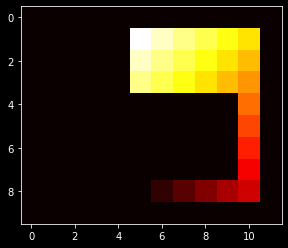

In [11]:
def text_print_pos_map(_pos_map):
    for row in _pos_map:
        print(' '.join(x_size*['{}']).format(*[str(int(r)).zfill(3) for r in row]))
        
def plot_pos_map(_pos_map):
    plt.imshow(_pos_map, cmap='hot', interpolation='nearest')
    plt.show()

# calculate minimum value with respect to velocities
x_size, y_size = len(course[0]), len(course)
pos_map = np.zeros((y_size, x_size))

for s_x in range(x_size):
    for s_y in range(y_size):
        pos_map[s_y, s_x] = np.min(values[s_y, s_x, :, :])
        
text_print_pos_map(pos_map)
plot_pos_map(-pos_map)

## 2) On-Policy $\varepsilon$-Greedy Control

Starting with the previously used turn-right-if-wall dummy policy, write an on-policy Monte-Carlo based first-visit $\varepsilon$-greedy control algorithm to solve the U-turn course. The policy is now stochastic: it does not contain simple action commands for each state, but probabilities for each possible action. Again, please make sure to understand how the stochastic policy works before coding.


Make sure to implement an upper bound for episode length (we suggest a boundary of 200 steps). Why do we need a bound like this? What happens to the state values / state-action values if we increase the bound?

## 2) Solution

Algorithm given below.

As we can see, the dummy policy allows for the initial episode to be solved very fast. After that, the dummy policy is forgotten and it takes some time until the agent is able to solve the problem again. 

The limitation of the episode length forces the agent to learn at least after the allowed number of steps were taken. If one would increase the limit, this would mainly inflate the accumulated return, resulting in larger negative action values for the visited states. As long as we do NOT find the goal, action values will correlate with the time limit. If we find the goal reproducible, the action values will drift towards their true optimal value independently from the time limit.

If we do not implement a time limit and allow the episode to terminate only by reaching the goal, the accumulated negative return will explode (we will get very large numbers). As we try to act greedy (take the highest rated and not the lowest rated action), low action values would suggest that the goal is not to be found on the path taken previously.

In [98]:
# dummy policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)

dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 # set probability of doing nothing to one for every state

# set probability to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1 
# set probability to do nothing where we want to go right:
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = 0 

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1 # probability to go bottom left
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = 0 

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1 # probability to go top left
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = 0 

pi = dummy_slow_stoch_pi                                   


















episode:   0%|                                                                                | 0/5000 [00:00<?, ?it/s]

Sample trajectory on learned policy in episode 0:


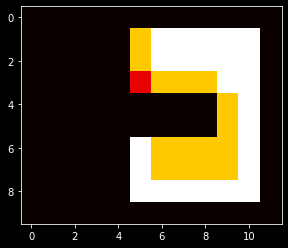

Sample trajectory on learned policy in episode 1:


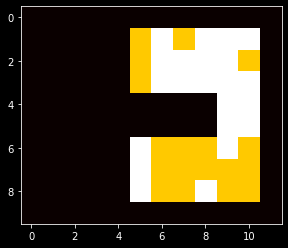

Sample trajectory on learned policy in episode 2:


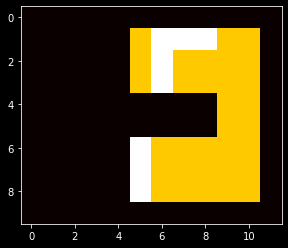

Sample trajectory on learned policy in episode 3:


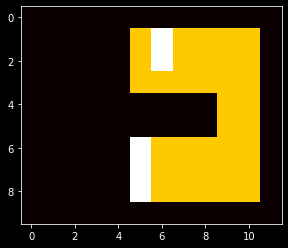

Sample trajectory on learned policy in episode 4:


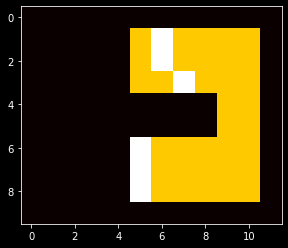

Sample trajectory on learned policy in episode 5:


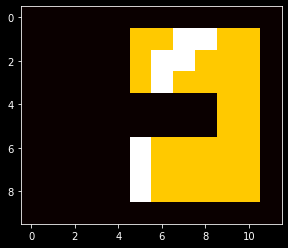

Sample trajectory on learned policy in episode 6:


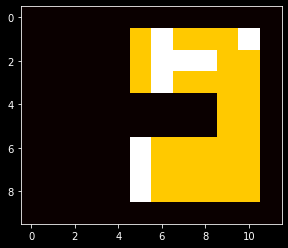

Sample trajectory on learned policy in episode 7:


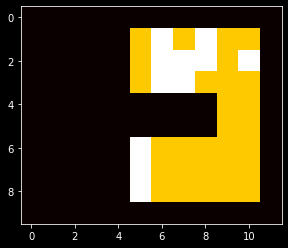

Sample trajectory on learned policy in episode 8:


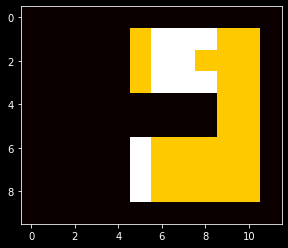

Sample trajectory on learned policy in episode 9:


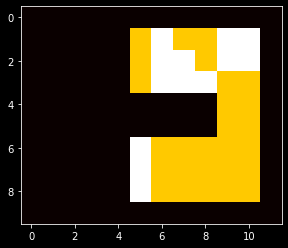

Sample trajectory on learned policy in episode 10:


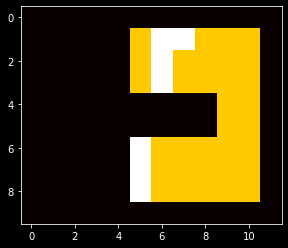

Sample trajectory on learned policy in episode 11:


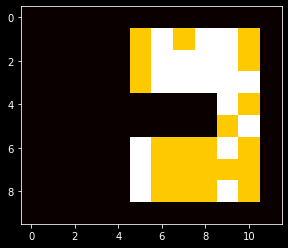

Sample trajectory on learned policy in episode 12:


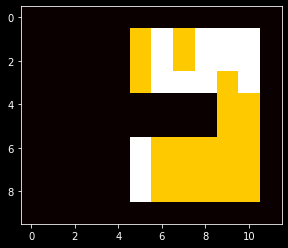

Sample trajectory on learned policy in episode 13:


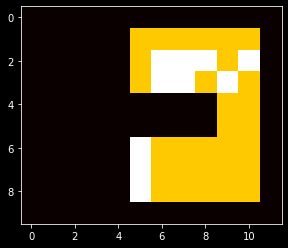

Sample trajectory on learned policy in episode 14:


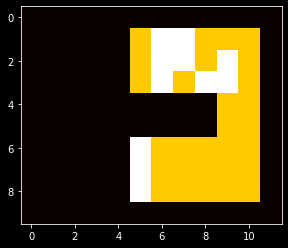

Sample trajectory on learned policy in episode 15:


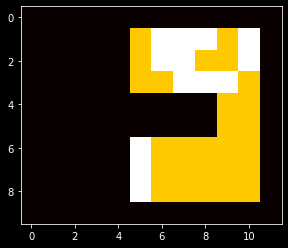

Sample trajectory on learned policy in episode 16:


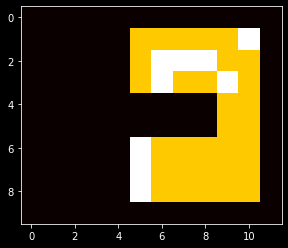

Sample trajectory on learned policy in episode 17:


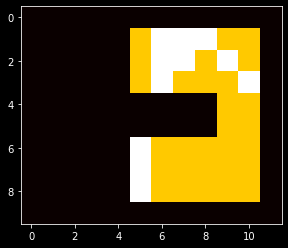


















episode:   0%|▎                                                                      | 18/5000 [00:02<09:27,  8.78it/s]

Sample trajectory on learned policy in episode 18:


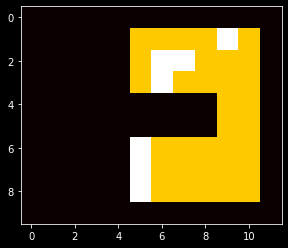

Sample trajectory on learned policy in episode 19:


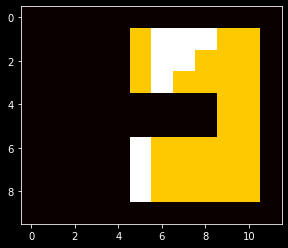

Sample trajectory on learned policy in episode 20:


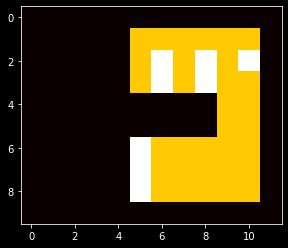

Sample trajectory on learned policy in episode 21:


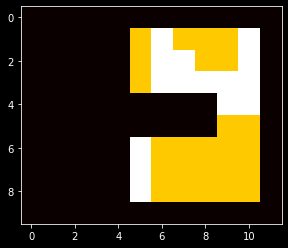

Sample trajectory on learned policy in episode 22:


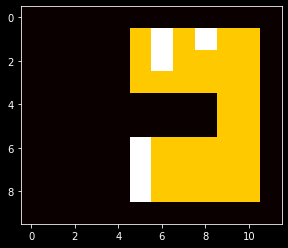

Sample trajectory on learned policy in episode 23:


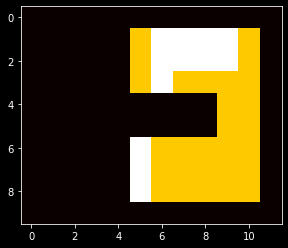

Sample trajectory on learned policy in episode 24:


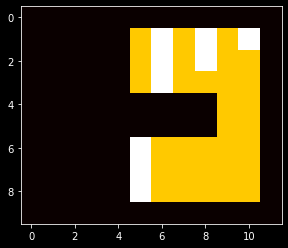

Sample trajectory on learned policy in episode 25:


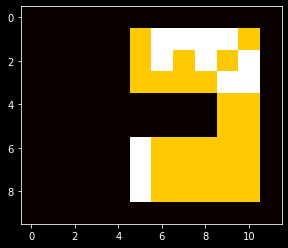

Sample trajectory on learned policy in episode 26:


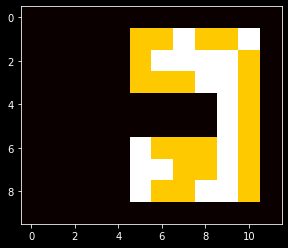

Sample trajectory on learned policy in episode 27:


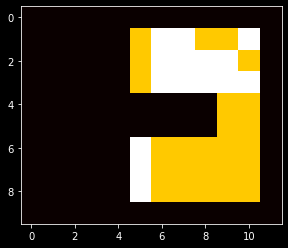

Sample trajectory on learned policy in episode 28:


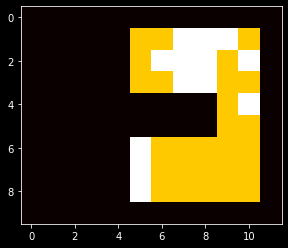

Sample trajectory on learned policy in episode 29:


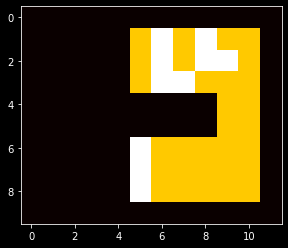

Sample trajectory on learned policy in episode 30:


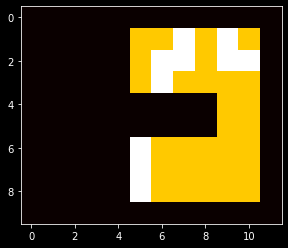

Sample trajectory on learned policy in episode 31:


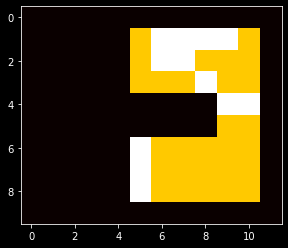

Sample trajectory on learned policy in episode 32:


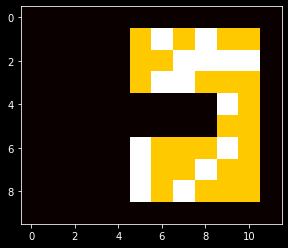

Sample trajectory on learned policy in episode 33:


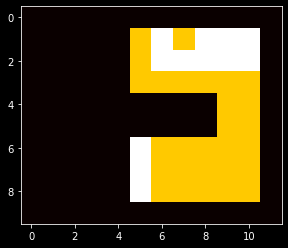

Sample trajectory on learned policy in episode 34:


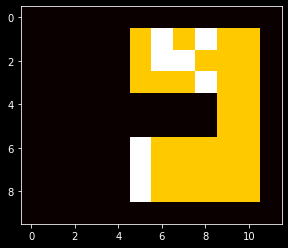

Sample trajectory on learned policy in episode 35:


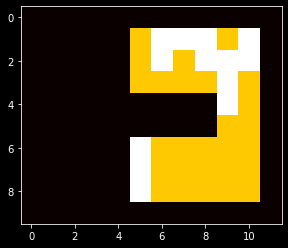


















episode:   1%|▌                                                                      | 36/5000 [00:04<09:23,  8.82it/s]

Sample trajectory on learned policy in episode 36:


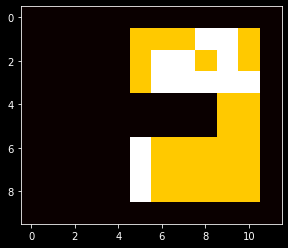

Sample trajectory on learned policy in episode 37:


episode:   1%|▌                                                                      | 36/5000 [00:04<09:52,  8.38it/s]


KeyboardInterrupt: 

In [99]:
# initialize action_values and counting dict
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
n_dict = {}

# configuration parameters
epsilon = 0.1 # exploration probability
gamma = 1 # discount factor
no_episodes = 5000 # number of evaluated episodes
no_steps = 200 # number of evaluated timesteps per episode


track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
      
    # initialize variables in which collected data will be stored
    action_states = [] # list of tuples
    rewards = [] # list of floats
    visited_action_states = set() # set of tuples
    first_visit_list = [] # list of booleans
    
    pos_map = np.zeros((y_size, x_size)) # initializes a map that can be plotted
    
    ### BEGIN SOLUTION
    
    p, v = track.reset()
    for k in range(no_steps):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # mark the visited position on the map
        
        # execute action (either by following the policy, or by exploring randomly)
        if epsilon < np.random.rand(1):
            action = np.argmax(pi[s_y, s_x, s_vy, s_vx])
        else:
            action = random.choice(range(9))
        
        # save the action state and check for first visit
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)
        action_states.append(action_state)
        first_visit_list.append(action_state not in visited_action_states)
        visited_action_states.add(action_state)
        
        # perform action
        (p, v), reward, done, _ = track.step(a)
        
        # save received reward
        rewards.append(reward)
        
        # terminate the environment if the finish line was passed
        if done:
            break 
    
    # learn from the collected data
    g = 0   
    for r, a_s, first_visit in zip(rewards[::-1], action_states[::-1], first_visit_list[::-1]): # count backwards
        g = gamma * g + r
        
        if first_visit:
            
            # Count visits to this state in n_list
            n_dict[a_s] = n_dict.get(a_s, 0) +  1

            # add new return g to existing value
            action_values[a_s] += 1/n_dict[a_s] * (g - action_values[a_s])
                        
            # calculate the new action probabilities
            u_best = np.argmax(action_values[a_s[:4]])
            pi[a_s[:4]] = epsilon / 9
            pi[a_s[:4]][u_best] = 1 - epsilon + epsilon / 9
            
    # END SOLUTION
    
    # this code fragment is to plot the sampled map, comment out for faster computation
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.float32)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

Use the code block directly below to test the resulting deterministic greedy policy (several samples are taken in order to show behavior in all different starting positions).

Done
Sample trajectory on learned policy in episode 0:


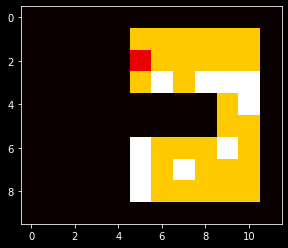

Done
Sample trajectory on learned policy in episode 1:


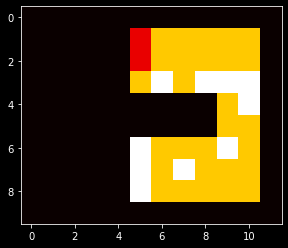

Done
Sample trajectory on learned policy in episode 2:


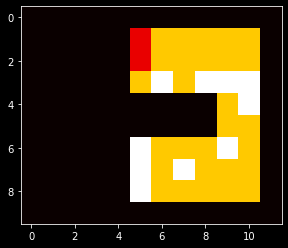

Done
Sample trajectory on learned policy in episode 3:


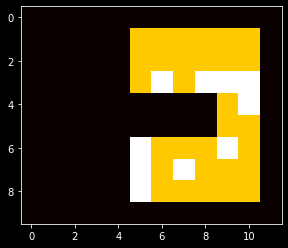

Done
Sample trajectory on learned policy in episode 4:


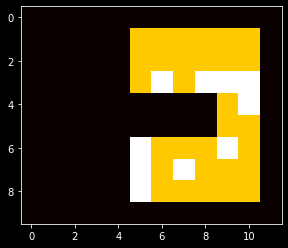

Done
Sample trajectory on learned policy in episode 5:


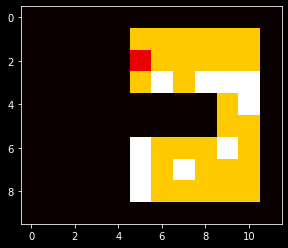

Done
Sample trajectory on learned policy in episode 6:


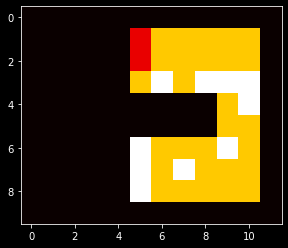

Done
Sample trajectory on learned policy in episode 7:


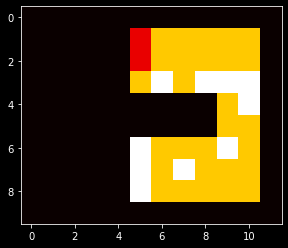

Done
Sample trajectory on learned policy in episode 8:


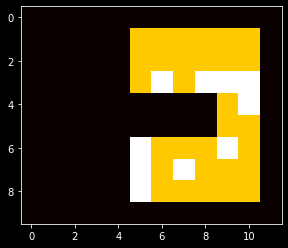

Done
Sample trajectory on learned policy in episode 9:


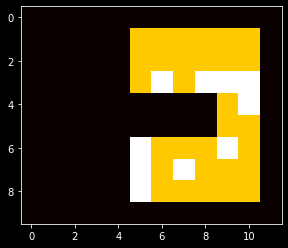

In [28]:
no_episodes = 10
for e in range(no_episodes):
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(200):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        action = np.argmax(pi[s_y, s_x, s_vy, s_vx])
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)

        (p, v), reward, done, _ = track.step(a)

        if done:
            break 

    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

## 3) Off-Policy $\varepsilon$-Greedy Control

Using the dummy-policy from 2) as a behavior policy, write an off-policy Monte-Carlo algorithm with weighted importance sampling.

Has the result gotten better or worse? Why?

## 3) Solution

Algorithm given below.

Since the agent reaches the goal even in the early episodes, one would naively expect the result to outperform the agent from task (2), at least concerning training speed / convergence speed. However, this is not observable. 

As we do not alternate the behavior policy, exploration and exploitation based on the behavior policy becomes hardly relevant after few episodes of training. E.g. following the behavior policy will rarely result in a velocity bigger than one, which also means that the learned policy will not be able to learn what to do if one is faster than that. Thus, if key elements of the optimal policy are missing from the behavior policy, we can not expect the learned policy to include them.

Better options for the behavior policy could be:
- alternating the behavior policy once in a while
- use the resulting policy from the previous task
- using the learned policy from some episodes ago (this can be done via low pass filtering: $\pi_\text{behavior} = (1-\tau) \cdot \pi_\text{behavior} + \tau \cdot \pi_\text{learned}$ with $0 < \tau < 1$)

Feel free to give it a try 😈  

![](https://media.giphy.com/media/UqZ4imFIoljlr5O2sM/giphy.gif)

(Source: https://media.giphy.com/media/UqZ4imFIoljlr5O2sM/giphy.gif)

In [122]:
### Dummy Policy
course = build_uturn_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
dummy_slow_stoch_pi = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 9])

# as the behavior policy is not alternated, there is no possibility to implement the epsilon parameter later
# hence, we need to implemented it right here
epsilon = 0.1

dummy_slow_stoch_pi[  :,   :, :, :, 4] = 1 - epsilon + epsilon / 9
for i in range(9):
    if i != 4:
        dummy_slow_stoch_pi[  :, :, :, :, i] = epsilon / 9
    
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 5] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[:track.bounds[0]//2, :, 0 , 0, 4] = epsilon / 9

dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 6] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[:track.bounds[0]//2, -2:, 0 , :, 4] = epsilon / 9

dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 0] = 1-epsilon + epsilon/9
dummy_slow_stoch_pi[-2:, track.bounds[1]//2:, : , 0, 4] = epsilon / 9

behavior_policy = dummy_slow_stoch_pi  

pi = np.copy(behavior_policy)



















episode:   0%|                                                                                | 0/1000 [00:00<?, ?it/s]

Sample trajectory on learned policy in episode 0:


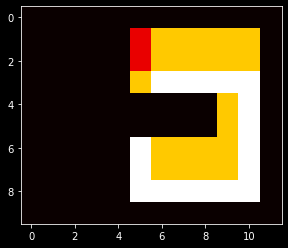

Sample trajectory on learned policy in episode 1:


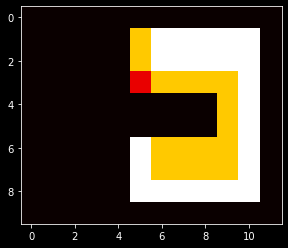

Sample trajectory on learned policy in episode 2:


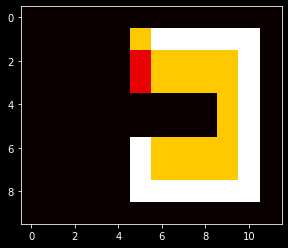

Sample trajectory on learned policy in episode 3:


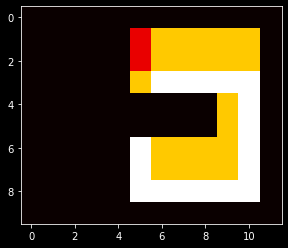

Sample trajectory on learned policy in episode 4:


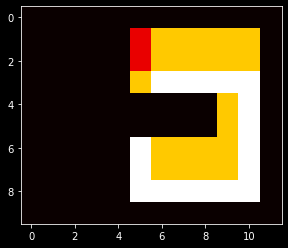

Sample trajectory on learned policy in episode 5:


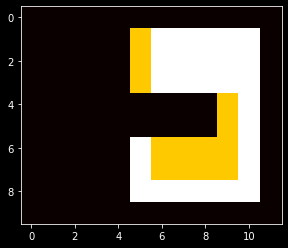

Sample trajectory on learned policy in episode 6:


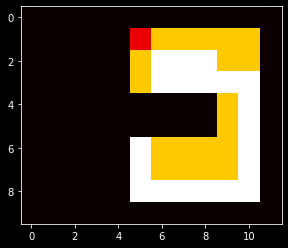

Sample trajectory on learned policy in episode 7:


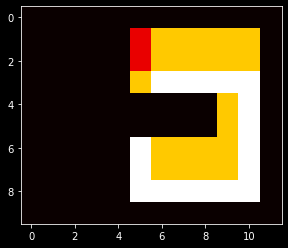

Sample trajectory on learned policy in episode 8:


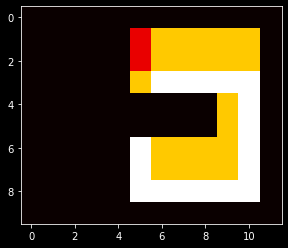

Sample trajectory on learned policy in episode 9:


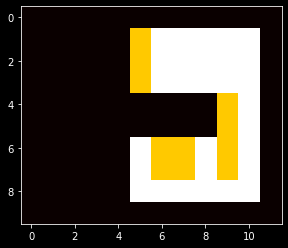

Sample trajectory on learned policy in episode 10:


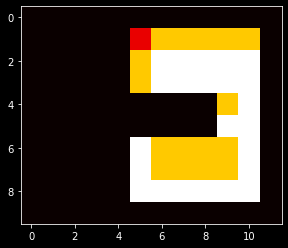

Sample trajectory on learned policy in episode 11:


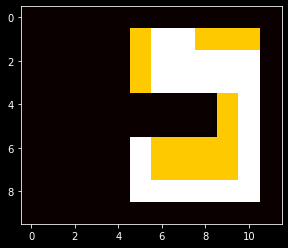

Sample trajectory on learned policy in episode 12:


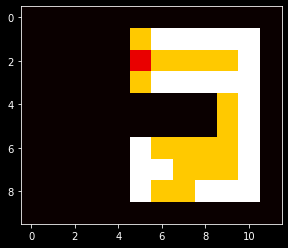

Sample trajectory on learned policy in episode 13:


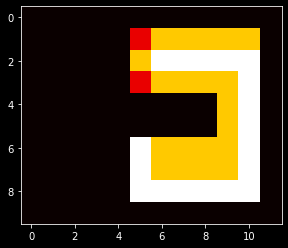

Sample trajectory on learned policy in episode 14:


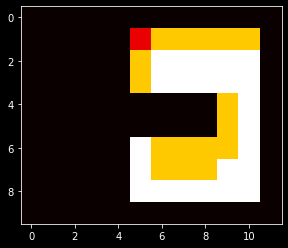

Sample trajectory on learned policy in episode 15:


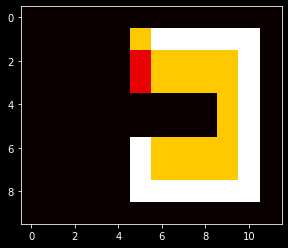

Sample trajectory on learned policy in episode 16:


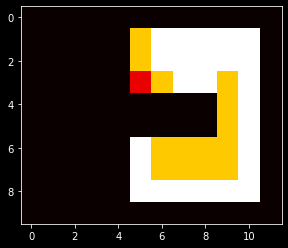

Sample trajectory on learned policy in episode 17:


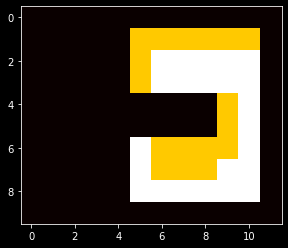

Sample trajectory on learned policy in episode 18:


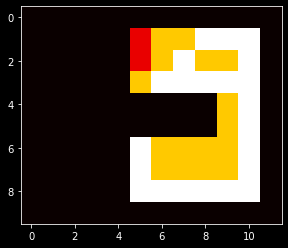

Sample trajectory on learned policy in episode 19:


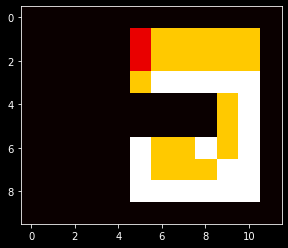

Sample trajectory on learned policy in episode 20:


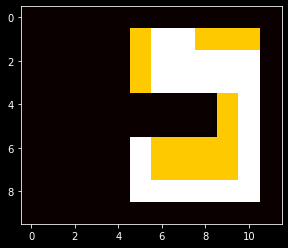

Sample trajectory on learned policy in episode 21:


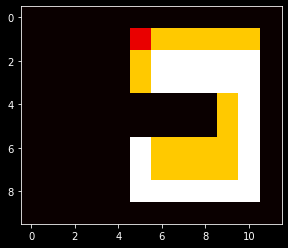

Sample trajectory on learned policy in episode 22:


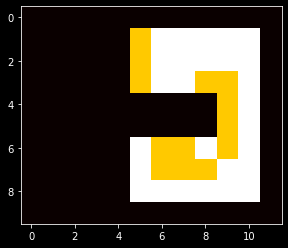

Sample trajectory on learned policy in episode 23:


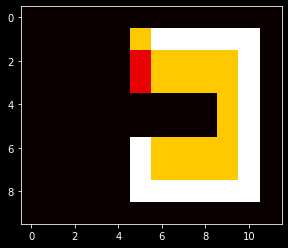



















episode:   2%|█▋                                                                     | 24/1000 [00:02<01:23, 11.65it/s]

Sample trajectory on learned policy in episode 24:


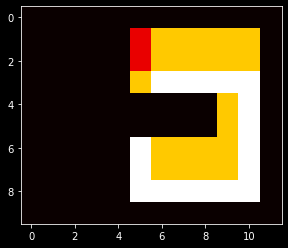

Sample trajectory on learned policy in episode 25:


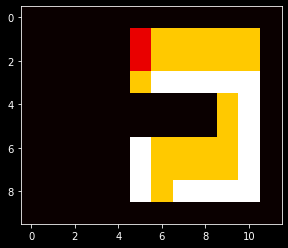

Sample trajectory on learned policy in episode 26:


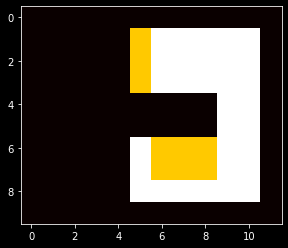

Sample trajectory on learned policy in episode 27:


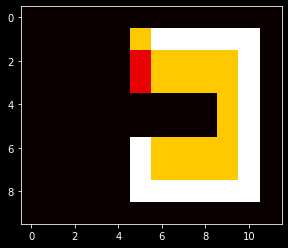

Sample trajectory on learned policy in episode 28:


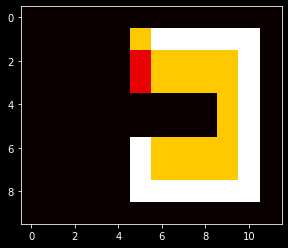

Sample trajectory on learned policy in episode 29:


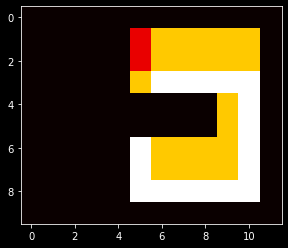

Sample trajectory on learned policy in episode 30:


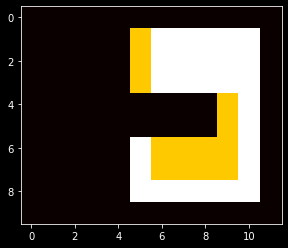

Sample trajectory on learned policy in episode 31:


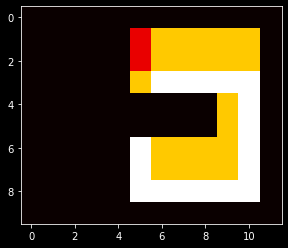

Sample trajectory on learned policy in episode 32:


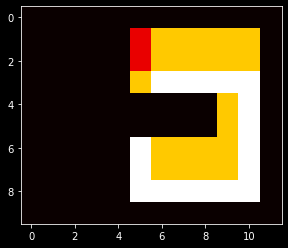

Sample trajectory on learned policy in episode 33:


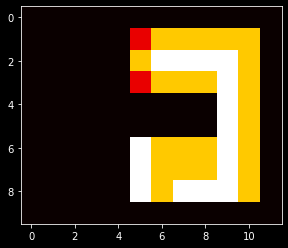

Sample trajectory on learned policy in episode 34:


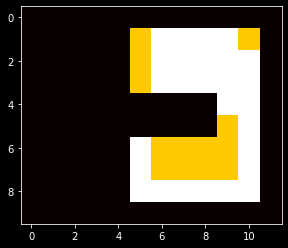

Sample trajectory on learned policy in episode 35:


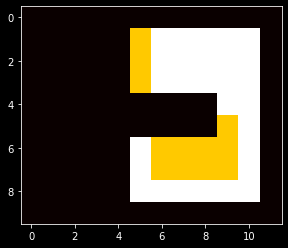

Sample trajectory on learned policy in episode 36:


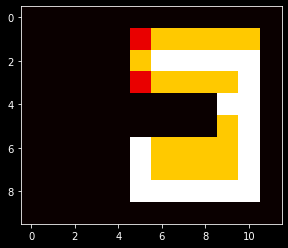

Sample trajectory on learned policy in episode 37:


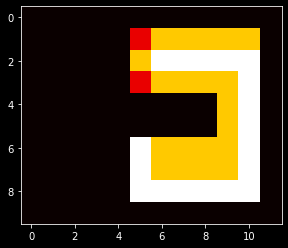

Sample trajectory on learned policy in episode 38:


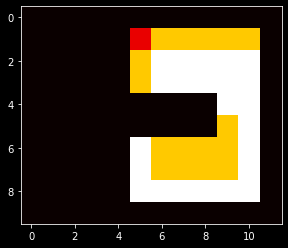

Sample trajectory on learned policy in episode 39:


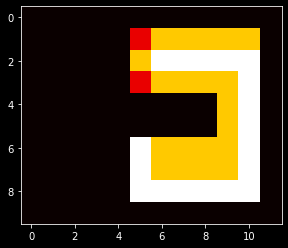

Sample trajectory on learned policy in episode 40:


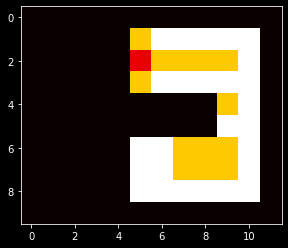

Sample trajectory on learned policy in episode 41:


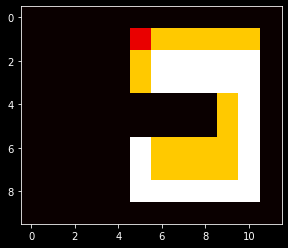

Sample trajectory on learned policy in episode 42:


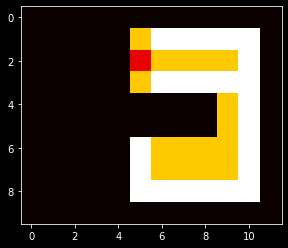

Sample trajectory on learned policy in episode 43:


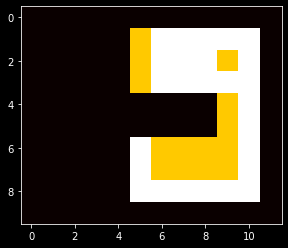

Sample trajectory on learned policy in episode 44:


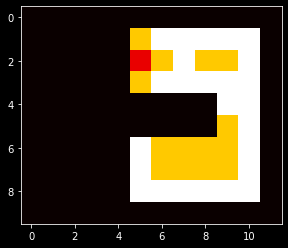

Sample trajectory on learned policy in episode 45:


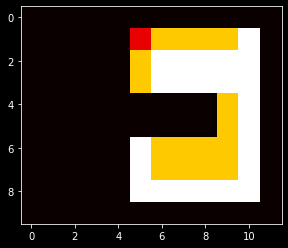

Sample trajectory on learned policy in episode 46:


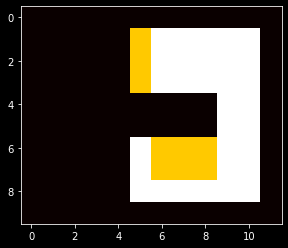

Sample trajectory on learned policy in episode 47:


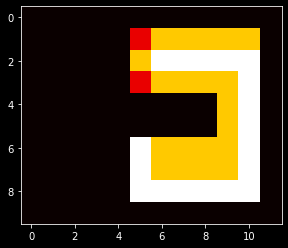



















episode:   5%|███▍                                                                   | 48/1000 [00:04<01:21, 11.62it/s]

Sample trajectory on learned policy in episode 48:


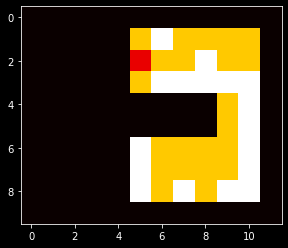

Sample trajectory on learned policy in episode 49:


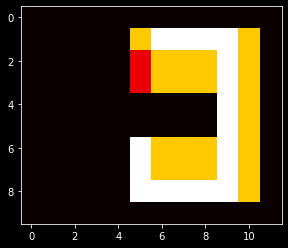

Sample trajectory on learned policy in episode 50:


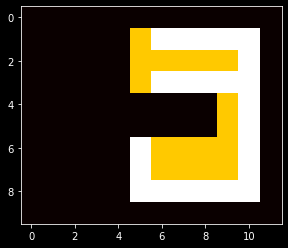

Sample trajectory on learned policy in episode 51:


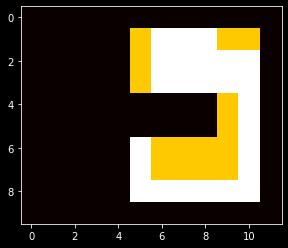

Sample trajectory on learned policy in episode 52:


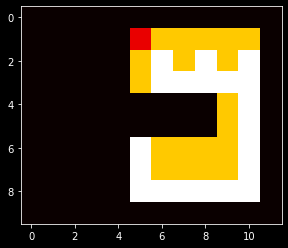

Sample trajectory on learned policy in episode 53:


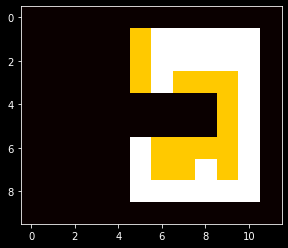

Sample trajectory on learned policy in episode 54:


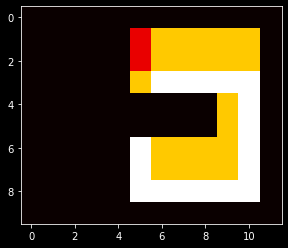

Sample trajectory on learned policy in episode 55:


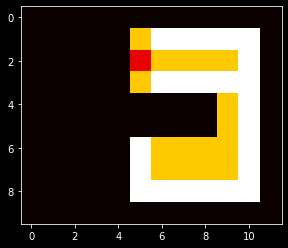

Sample trajectory on learned policy in episode 56:


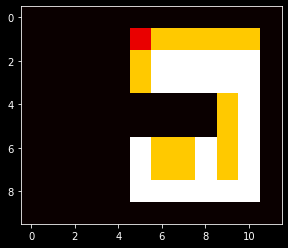

Sample trajectory on learned policy in episode 57:


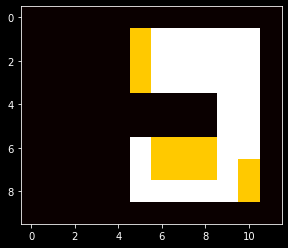

Sample trajectory on learned policy in episode 58:


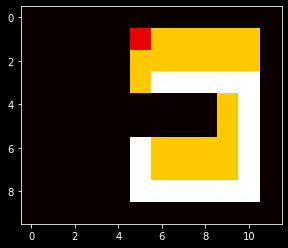

Sample trajectory on learned policy in episode 59:


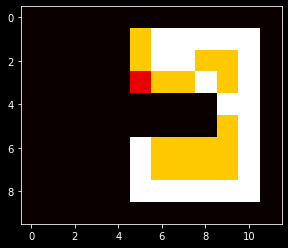

Sample trajectory on learned policy in episode 60:


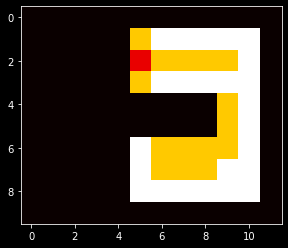

Sample trajectory on learned policy in episode 61:


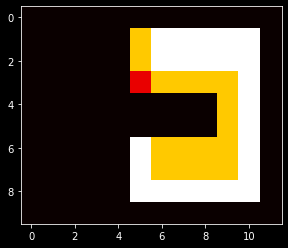

Sample trajectory on learned policy in episode 62:


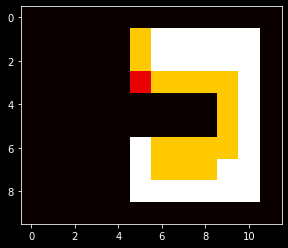

Sample trajectory on learned policy in episode 63:


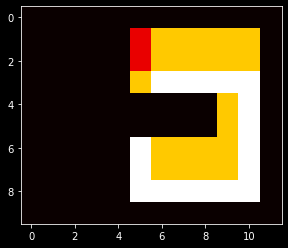

Sample trajectory on learned policy in episode 64:


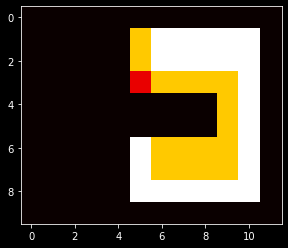

Sample trajectory on learned policy in episode 65:


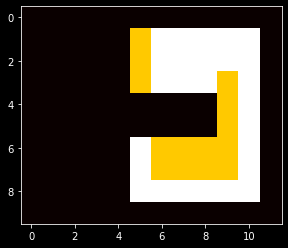

Sample trajectory on learned policy in episode 66:


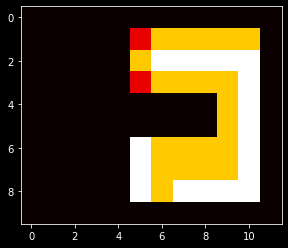

Sample trajectory on learned policy in episode 67:


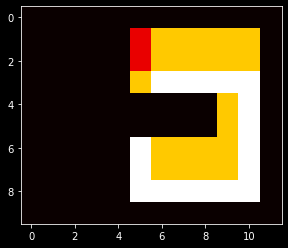

Sample trajectory on learned policy in episode 68:


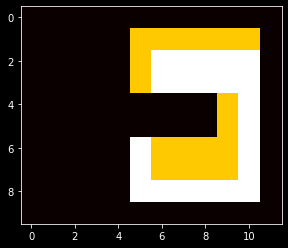

Sample trajectory on learned policy in episode 69:


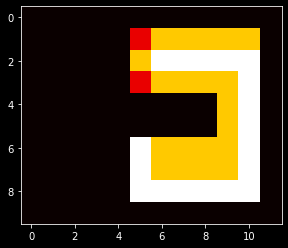

Sample trajectory on learned policy in episode 70:


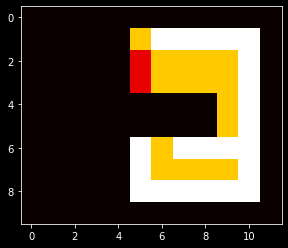

Sample trajectory on learned policy in episode 71:


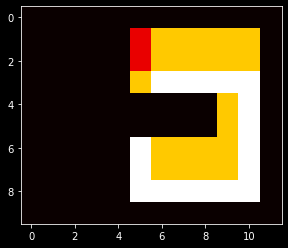



















episode:   7%|█████                                                                  | 72/1000 [00:06<01:19, 11.63it/s]

Sample trajectory on learned policy in episode 72:


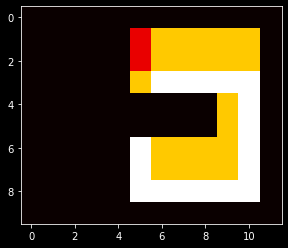

Sample trajectory on learned policy in episode 73:


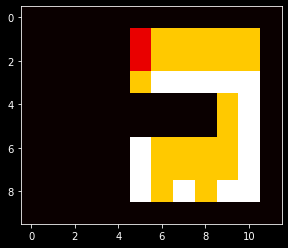

Sample trajectory on learned policy in episode 74:


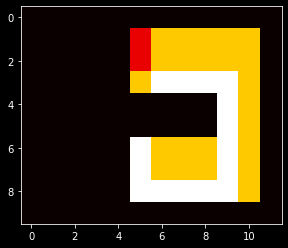

Sample trajectory on learned policy in episode 75:


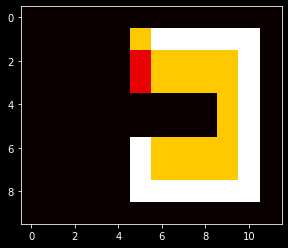

Sample trajectory on learned policy in episode 76:


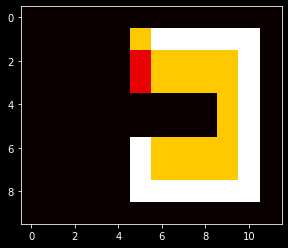

Sample trajectory on learned policy in episode 77:


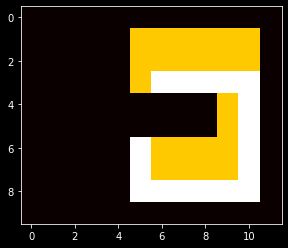

Sample trajectory on learned policy in episode 78:


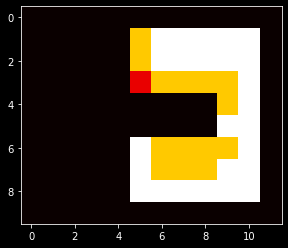

Sample trajectory on learned policy in episode 79:


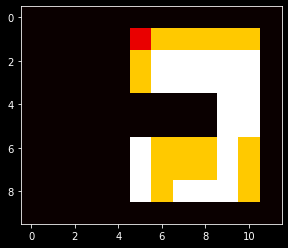

Sample trajectory on learned policy in episode 80:


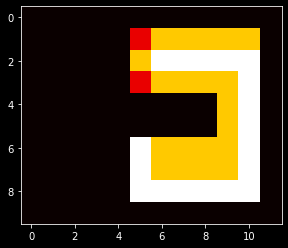

Sample trajectory on learned policy in episode 81:


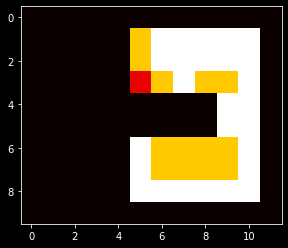

Sample trajectory on learned policy in episode 82:


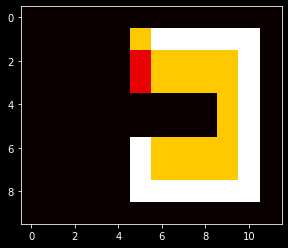

Sample trajectory on learned policy in episode 83:


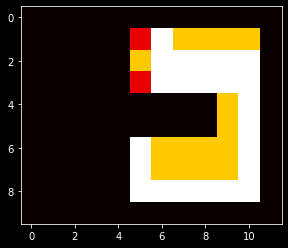

Sample trajectory on learned policy in episode 84:


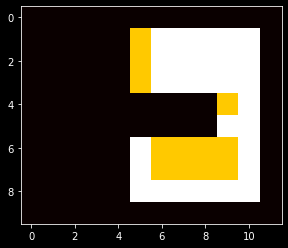

Sample trajectory on learned policy in episode 85:


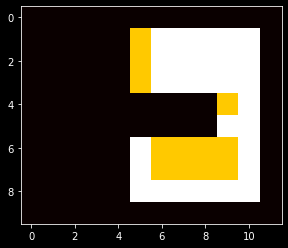

Sample trajectory on learned policy in episode 86:


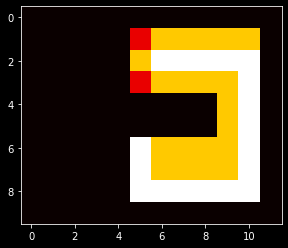

Sample trajectory on learned policy in episode 87:


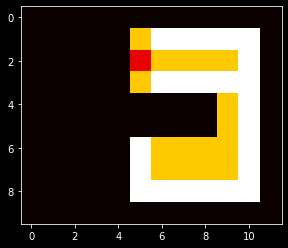

Sample trajectory on learned policy in episode 88:


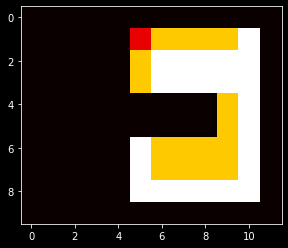

Sample trajectory on learned policy in episode 89:


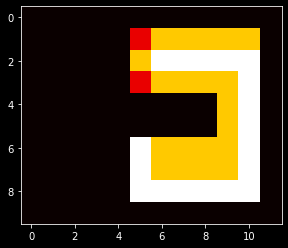

Sample trajectory on learned policy in episode 90:


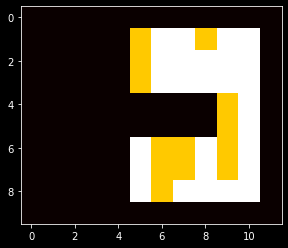

Sample trajectory on learned policy in episode 91:


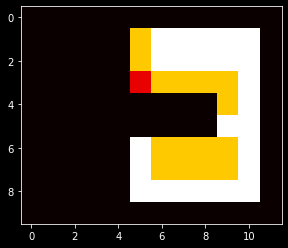

Sample trajectory on learned policy in episode 92:


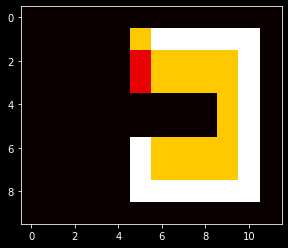

Sample trajectory on learned policy in episode 93:


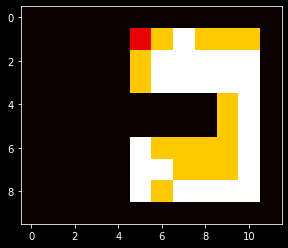

Sample trajectory on learned policy in episode 94:


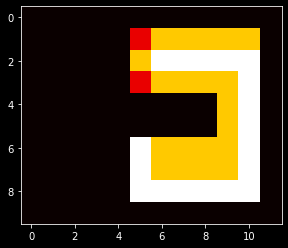

Sample trajectory on learned policy in episode 95:


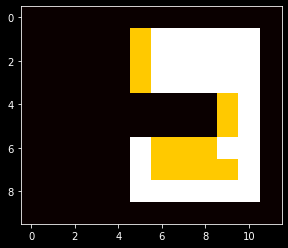



















episode:  10%|██████▊                                                                | 96/1000 [00:08<01:17, 11.63it/s]

Sample trajectory on learned policy in episode 96:


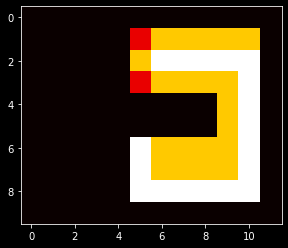

Sample trajectory on learned policy in episode 97:


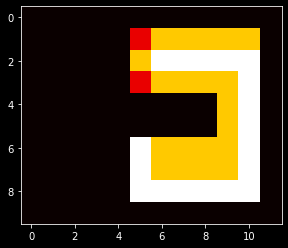

Sample trajectory on learned policy in episode 98:


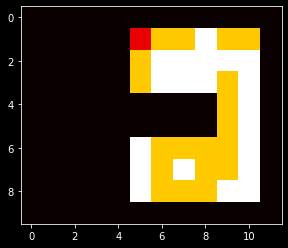

Sample trajectory on learned policy in episode 99:


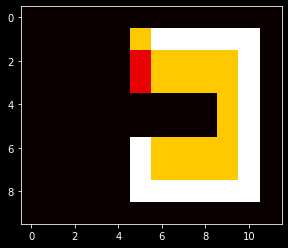

Sample trajectory on learned policy in episode 100:


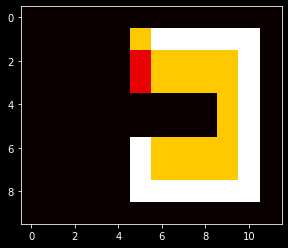

Sample trajectory on learned policy in episode 101:


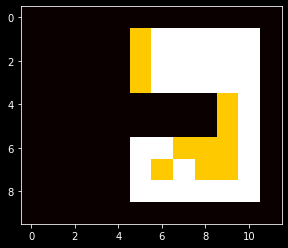

Sample trajectory on learned policy in episode 102:


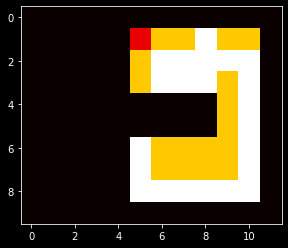

Sample trajectory on learned policy in episode 103:


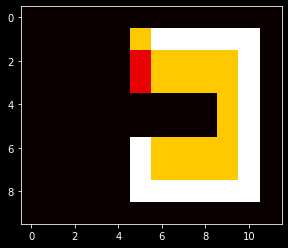

Sample trajectory on learned policy in episode 104:


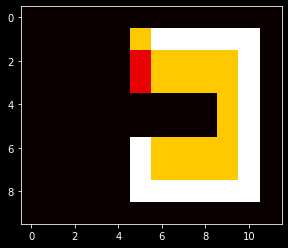

Sample trajectory on learned policy in episode 105:


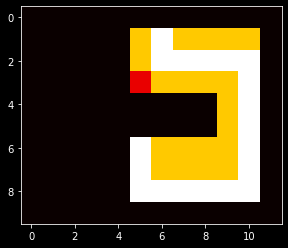

Sample trajectory on learned policy in episode 106:


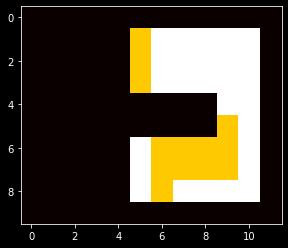

Sample trajectory on learned policy in episode 107:


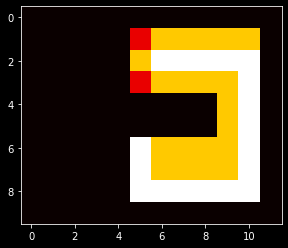

Sample trajectory on learned policy in episode 108:


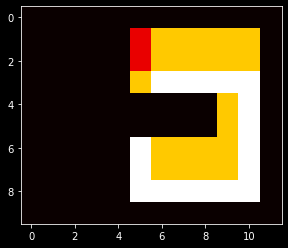

Sample trajectory on learned policy in episode 109:



















episode:   7%|█████                                                                  | 72/1000 [00:23<01:19, 11.66it/s]

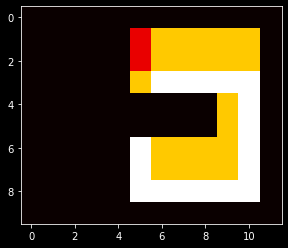

Sample trajectory on learned policy in episode 110:


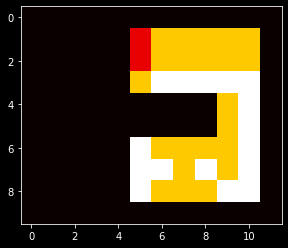

Sample trajectory on learned policy in episode 111:


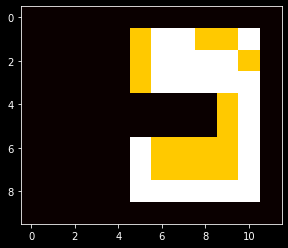

Sample trajectory on learned policy in episode 112:


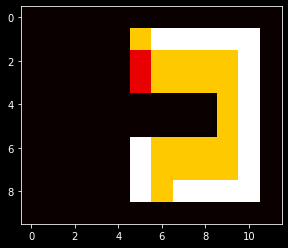

Sample trajectory on learned policy in episode 113:


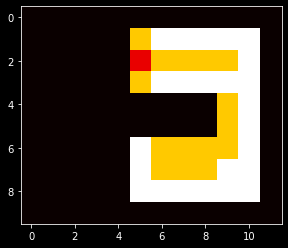

Sample trajectory on learned policy in episode 114:


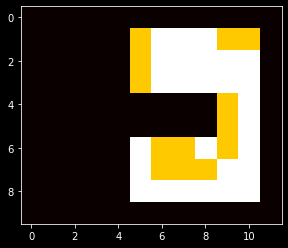

Sample trajectory on learned policy in episode 115:


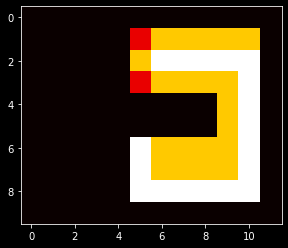

Sample trajectory on learned policy in episode 116:


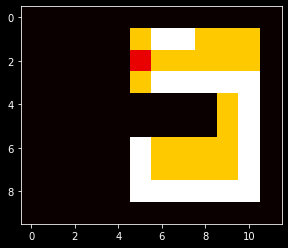

Sample trajectory on learned policy in episode 117:


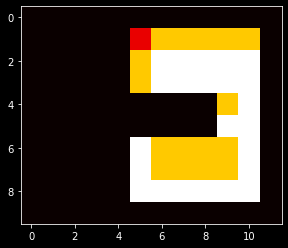

Sample trajectory on learned policy in episode 118:


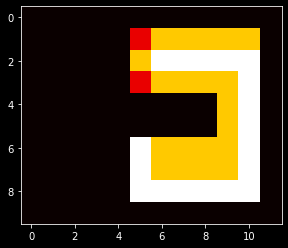

Sample trajectory on learned policy in episode 119:


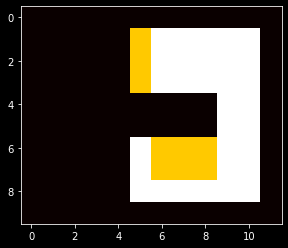



















episode:  12%|████████▍                                                             | 120/1000 [00:10<01:15, 11.65it/s]

Sample trajectory on learned policy in episode 120:


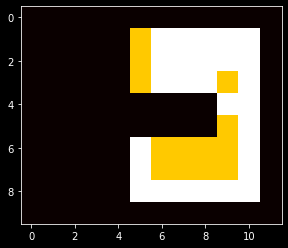

Sample trajectory on learned policy in episode 121:


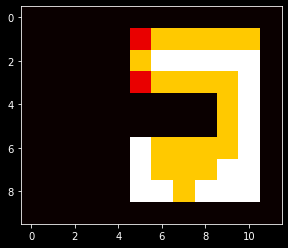

Sample trajectory on learned policy in episode 122:


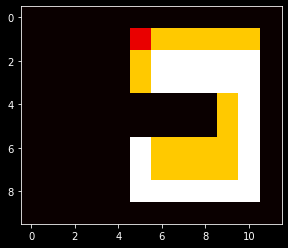

Sample trajectory on learned policy in episode 123:


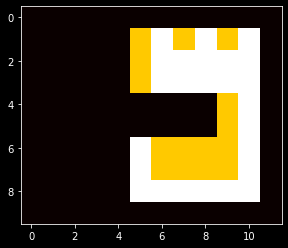

Sample trajectory on learned policy in episode 124:


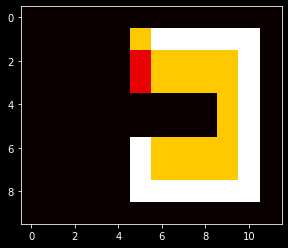

Sample trajectory on learned policy in episode 125:


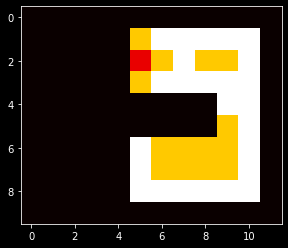

Sample trajectory on learned policy in episode 126:


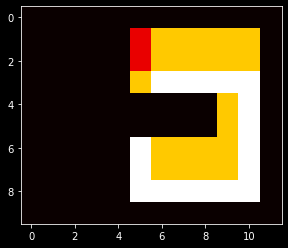

Sample trajectory on learned policy in episode 127:


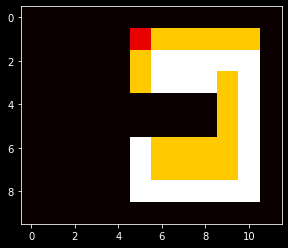

Sample trajectory on learned policy in episode 128:


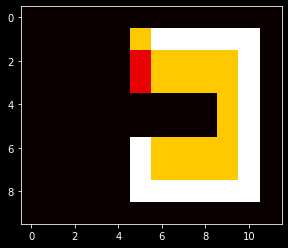

Sample trajectory on learned policy in episode 129:


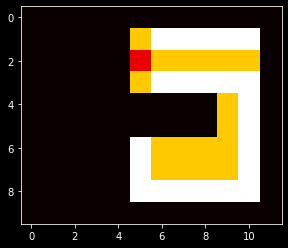

Sample trajectory on learned policy in episode 130:


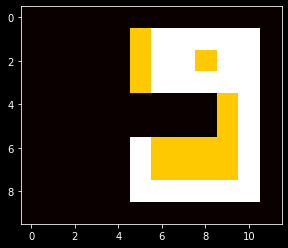

Sample trajectory on learned policy in episode 131:


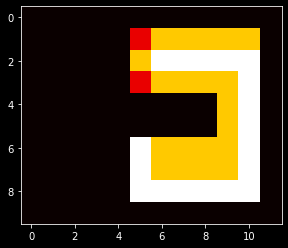

Sample trajectory on learned policy in episode 132:


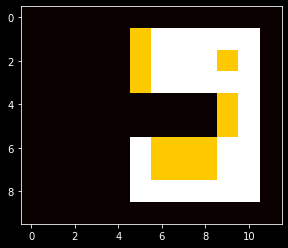

Sample trajectory on learned policy in episode 133:


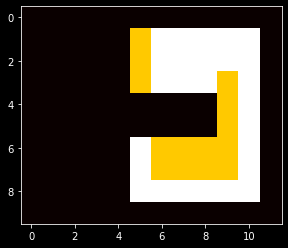

Sample trajectory on learned policy in episode 134:


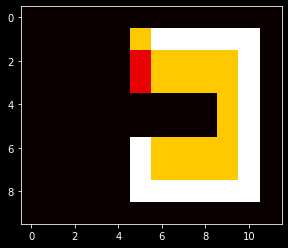

Sample trajectory on learned policy in episode 135:


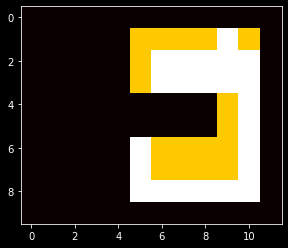

Sample trajectory on learned policy in episode 136:


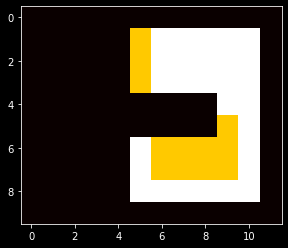

Sample trajectory on learned policy in episode 137:


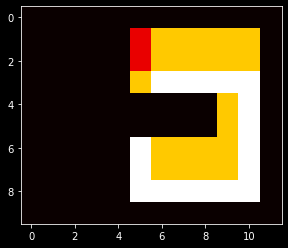

Sample trajectory on learned policy in episode 138:


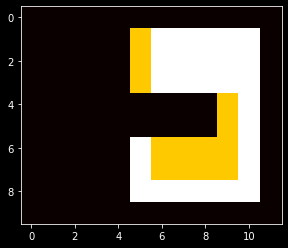

Sample trajectory on learned policy in episode 139:


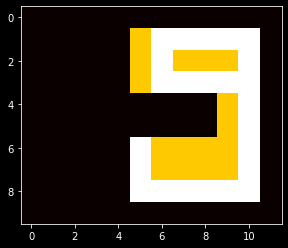

Sample trajectory on learned policy in episode 140:


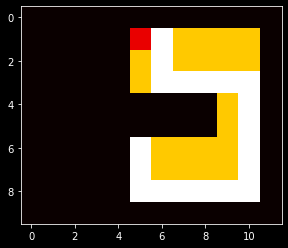

Sample trajectory on learned policy in episode 141:


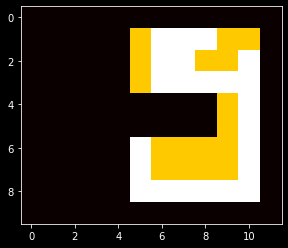

Sample trajectory on learned policy in episode 142:


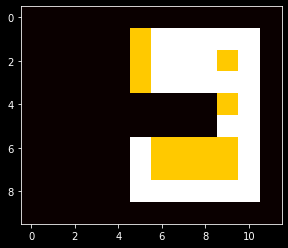

Sample trajectory on learned policy in episode 143:


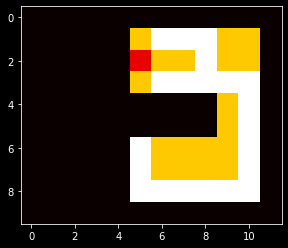



















episode:  14%|██████████                                                            | 144/1000 [00:12<01:13, 11.63it/s]

Sample trajectory on learned policy in episode 144:


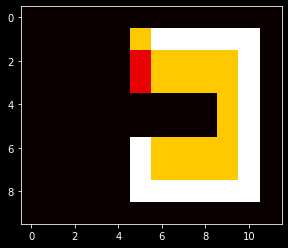

Sample trajectory on learned policy in episode 145:


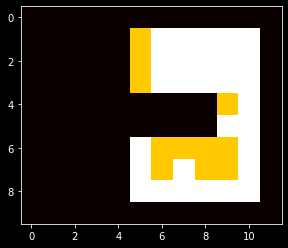

Sample trajectory on learned policy in episode 146:


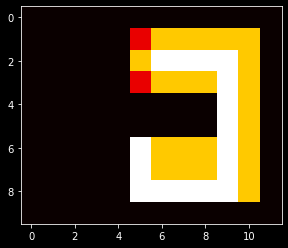

Sample trajectory on learned policy in episode 147:


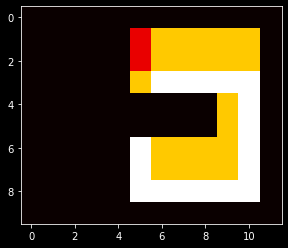

Sample trajectory on learned policy in episode 148:


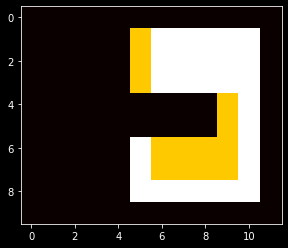

Sample trajectory on learned policy in episode 149:


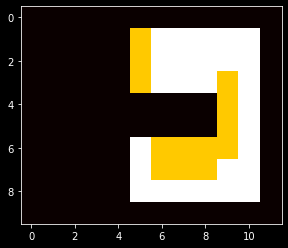

Sample trajectory on learned policy in episode 150:


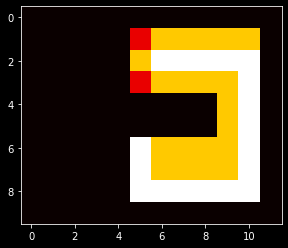

Sample trajectory on learned policy in episode 151:


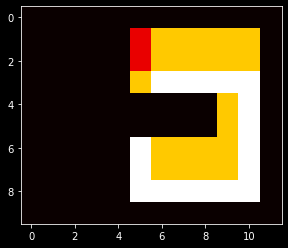

Sample trajectory on learned policy in episode 152:


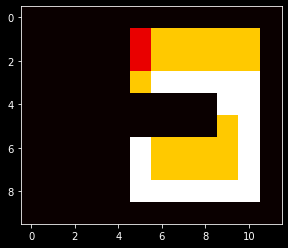

Sample trajectory on learned policy in episode 153:


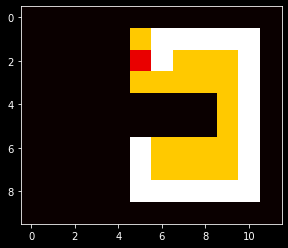

Sample trajectory on learned policy in episode 154:


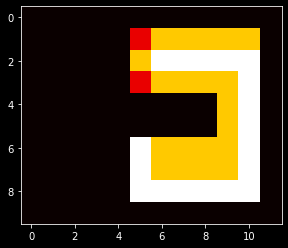

Sample trajectory on learned policy in episode 155:


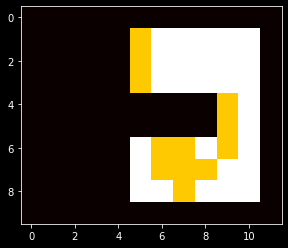

Sample trajectory on learned policy in episode 156:


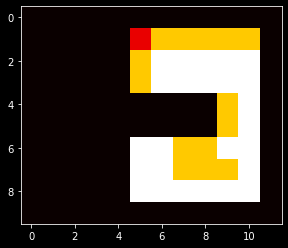

Sample trajectory on learned policy in episode 157:


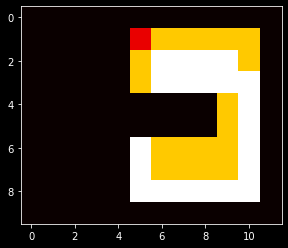

Sample trajectory on learned policy in episode 158:


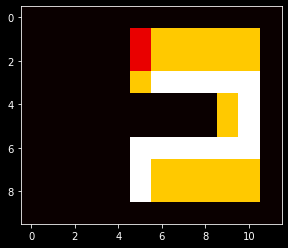

Sample trajectory on learned policy in episode 159:


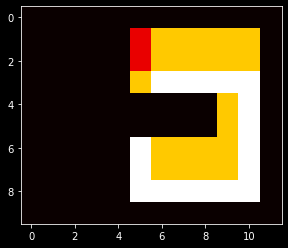

Sample trajectory on learned policy in episode 160:


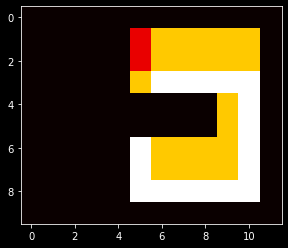

Sample trajectory on learned policy in episode 161:


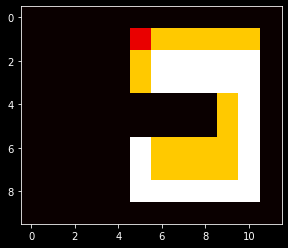

Sample trajectory on learned policy in episode 162:


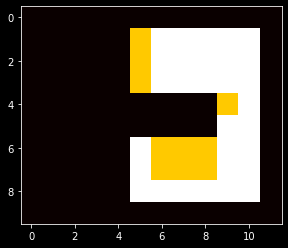

Sample trajectory on learned policy in episode 163:


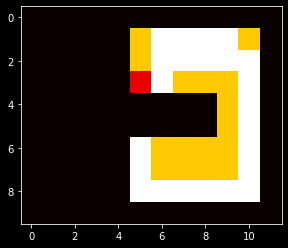

Sample trajectory on learned policy in episode 164:


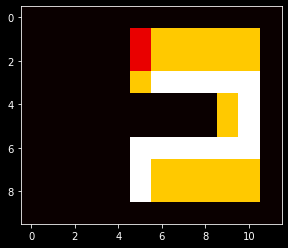

Sample trajectory on learned policy in episode 165:


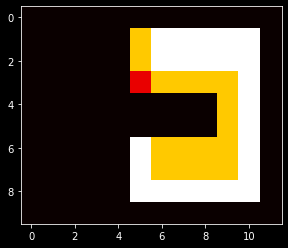

Sample trajectory on learned policy in episode 166:


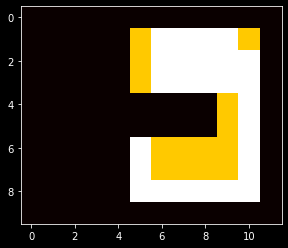

Sample trajectory on learned policy in episode 167:


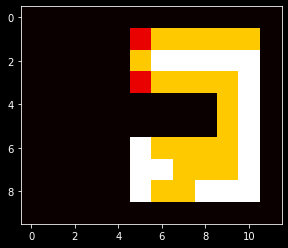



















episode:  17%|███████████▊                                                          | 168/1000 [00:14<01:11, 11.57it/s]

Sample trajectory on learned policy in episode 168:


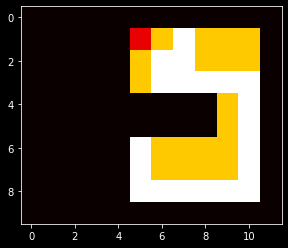

Sample trajectory on learned policy in episode 169:


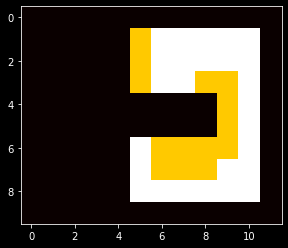

Sample trajectory on learned policy in episode 170:


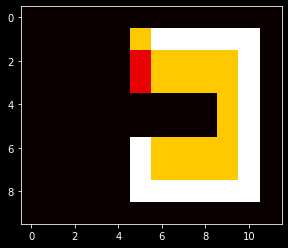

Sample trajectory on learned policy in episode 171:


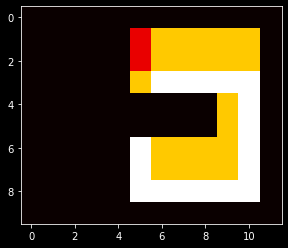

Sample trajectory on learned policy in episode 172:


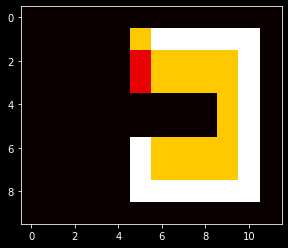

Sample trajectory on learned policy in episode 173:


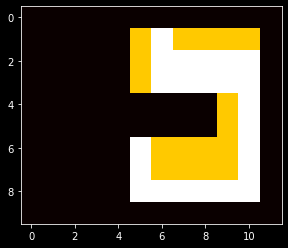

Sample trajectory on learned policy in episode 174:


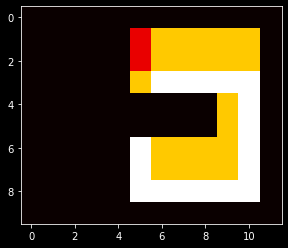

Sample trajectory on learned policy in episode 175:


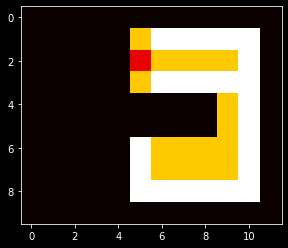

Sample trajectory on learned policy in episode 176:


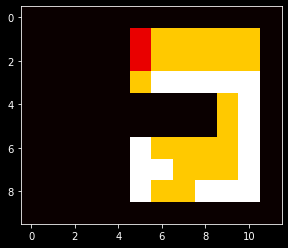

Sample trajectory on learned policy in episode 177:


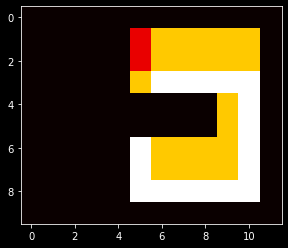

Sample trajectory on learned policy in episode 178:


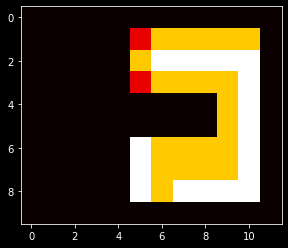

Sample trajectory on learned policy in episode 179:


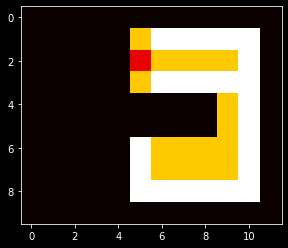

Sample trajectory on learned policy in episode 180:


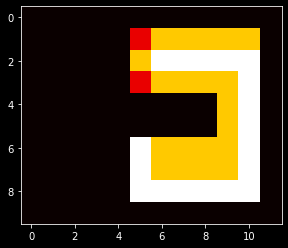

Sample trajectory on learned policy in episode 181:


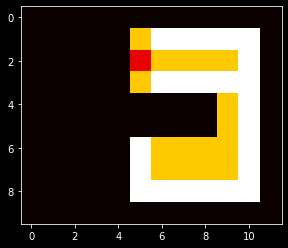

Sample trajectory on learned policy in episode 182:


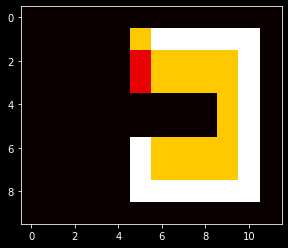

Sample trajectory on learned policy in episode 183:


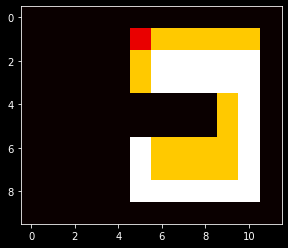

Sample trajectory on learned policy in episode 184:


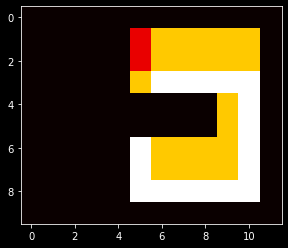

Sample trajectory on learned policy in episode 185:


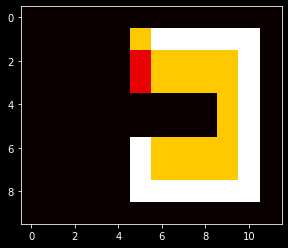

Sample trajectory on learned policy in episode 186:


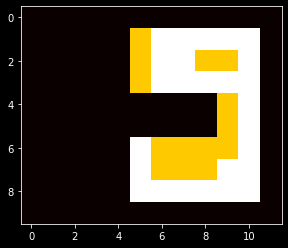

Sample trajectory on learned policy in episode 187:


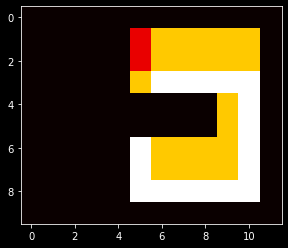

Sample trajectory on learned policy in episode 188:


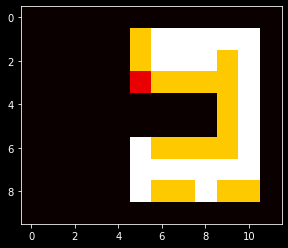

Sample trajectory on learned policy in episode 189:


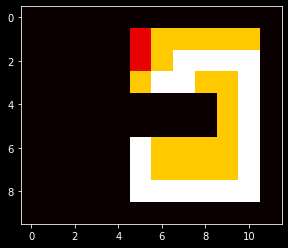

Sample trajectory on learned policy in episode 190:


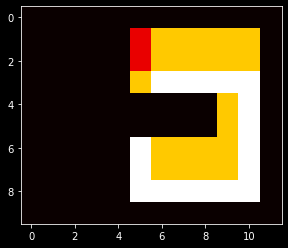

Sample trajectory on learned policy in episode 191:


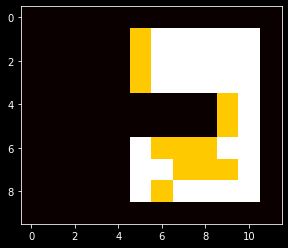



















episode:  19%|█████████████▍                                                        | 192/1000 [00:16<01:09, 11.64it/s]

Sample trajectory on learned policy in episode 192:


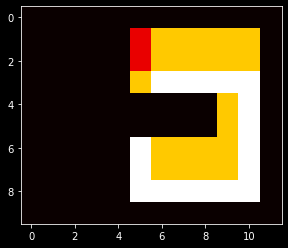

Sample trajectory on learned policy in episode 193:


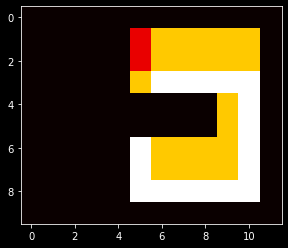

Sample trajectory on learned policy in episode 194:


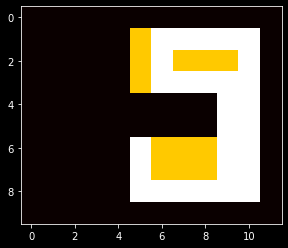

Sample trajectory on learned policy in episode 195:


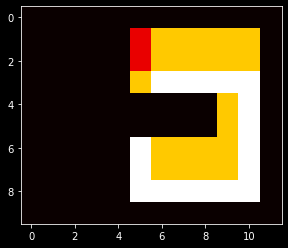

Sample trajectory on learned policy in episode 196:


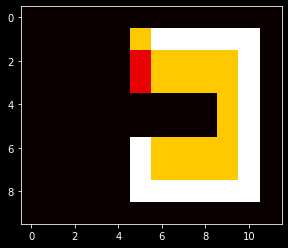

Sample trajectory on learned policy in episode 197:


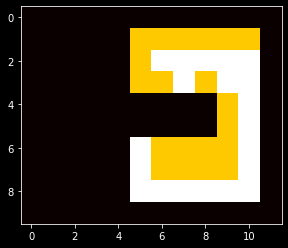

Sample trajectory on learned policy in episode 198:


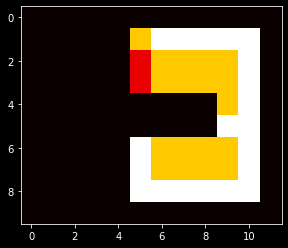

Sample trajectory on learned policy in episode 199:


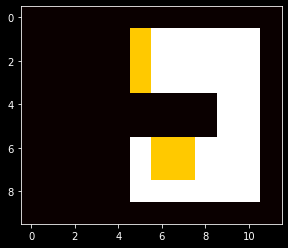

Sample trajectory on learned policy in episode 200:


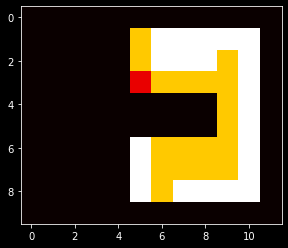

Sample trajectory on learned policy in episode 201:


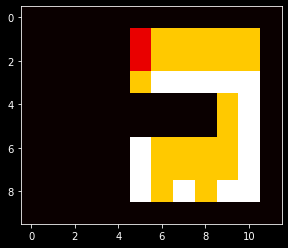

Sample trajectory on learned policy in episode 202:


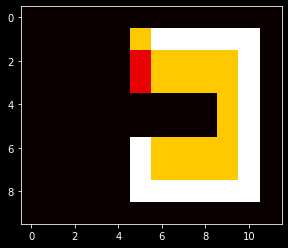

Sample trajectory on learned policy in episode 203:


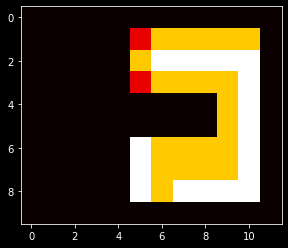

Sample trajectory on learned policy in episode 204:


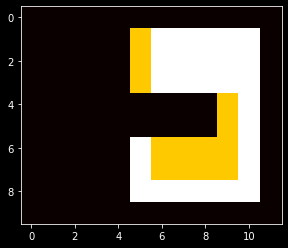

Sample trajectory on learned policy in episode 205:


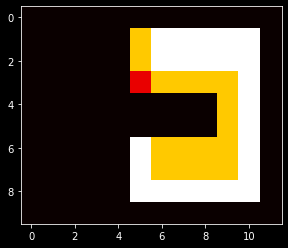

Sample trajectory on learned policy in episode 206:


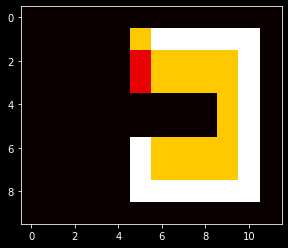

Sample trajectory on learned policy in episode 207:


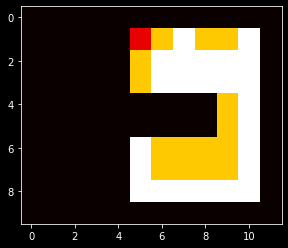

Sample trajectory on learned policy in episode 208:


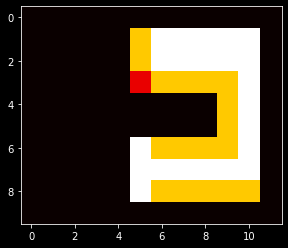

Sample trajectory on learned policy in episode 209:


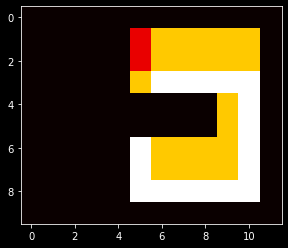

Sample trajectory on learned policy in episode 210:


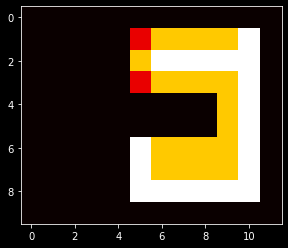

Sample trajectory on learned policy in episode 211:


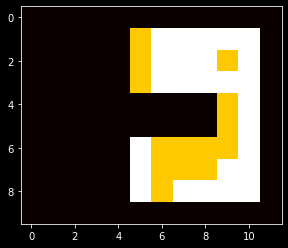

Sample trajectory on learned policy in episode 212:


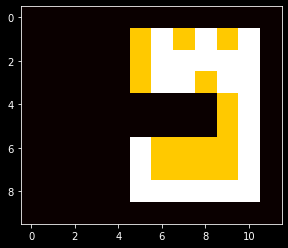

Sample trajectory on learned policy in episode 213:


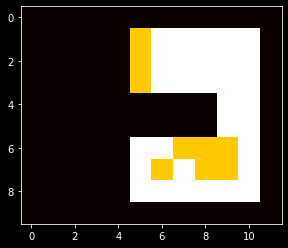

Sample trajectory on learned policy in episode 214:


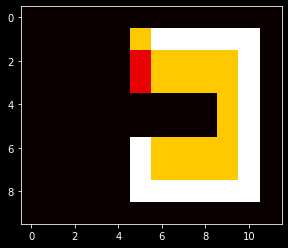

Sample trajectory on learned policy in episode 215:


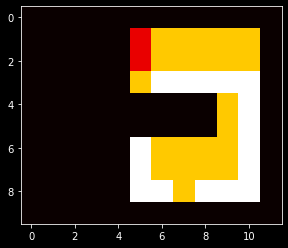



















episode:  22%|███████████████                                                       | 216/1000 [00:18<01:07, 11.61it/s]

Sample trajectory on learned policy in episode 216:


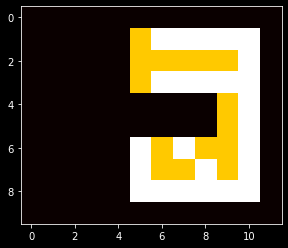

Sample trajectory on learned policy in episode 217:


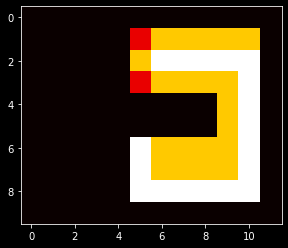

Sample trajectory on learned policy in episode 218:


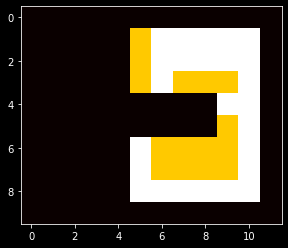

Sample trajectory on learned policy in episode 219:


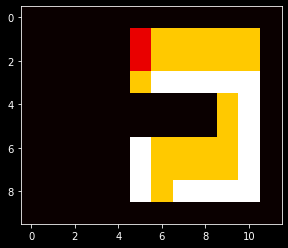

Sample trajectory on learned policy in episode 220:


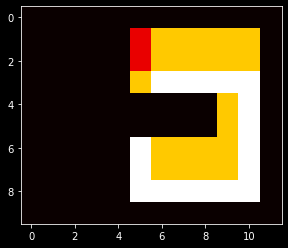

Sample trajectory on learned policy in episode 221:


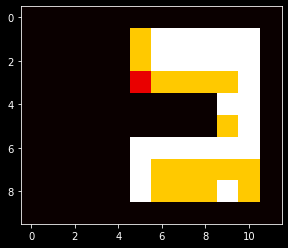

Sample trajectory on learned policy in episode 222:


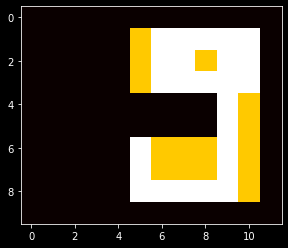

Sample trajectory on learned policy in episode 223:


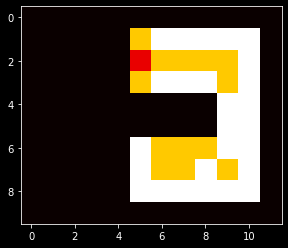

Sample trajectory on learned policy in episode 224:


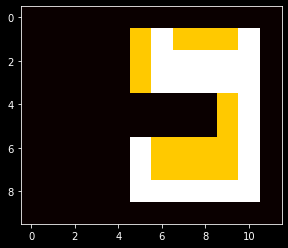

Sample trajectory on learned policy in episode 225:


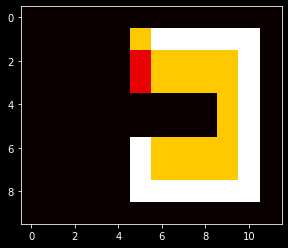

Sample trajectory on learned policy in episode 226:


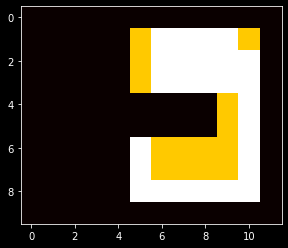

Sample trajectory on learned policy in episode 227:


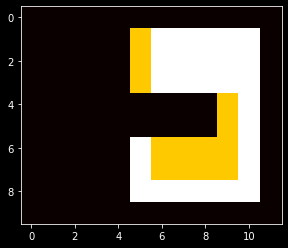

Sample trajectory on learned policy in episode 228:


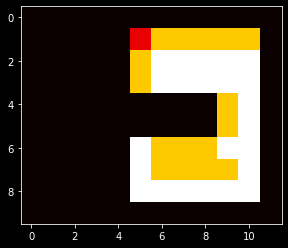

Sample trajectory on learned policy in episode 229:


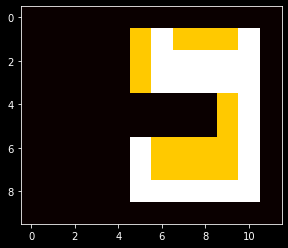

Sample trajectory on learned policy in episode 230:


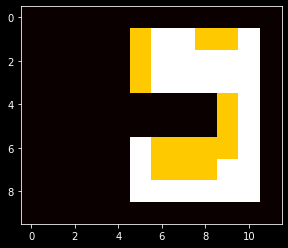

Sample trajectory on learned policy in episode 231:


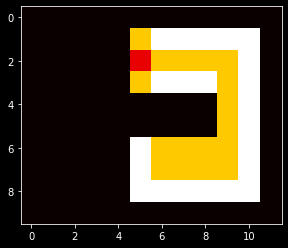

Sample trajectory on learned policy in episode 232:


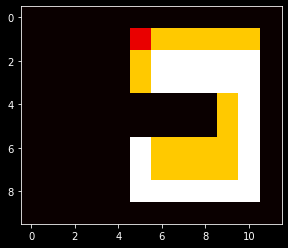

Sample trajectory on learned policy in episode 233:


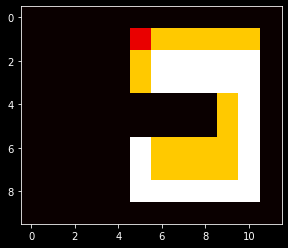

Sample trajectory on learned policy in episode 234:


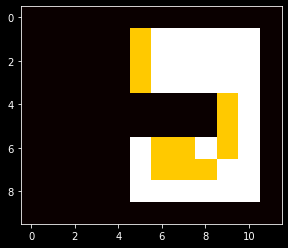

Sample trajectory on learned policy in episode 235:


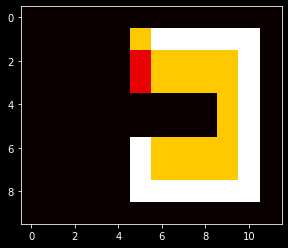

Sample trajectory on learned policy in episode 236:


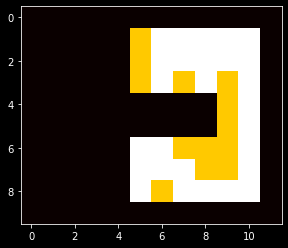

Sample trajectory on learned policy in episode 237:


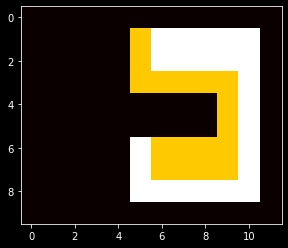

Sample trajectory on learned policy in episode 238:


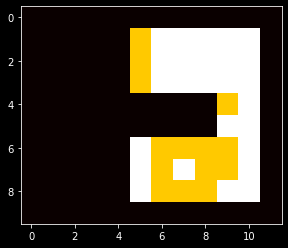



















episode:  24%|████████████████▋                                                     | 239/1000 [00:20<01:05, 11.55it/s]

Sample trajectory on learned policy in episode 239:


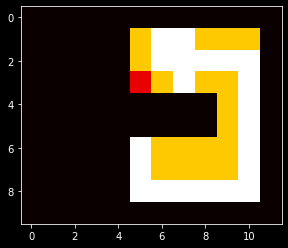

Sample trajectory on learned policy in episode 240:


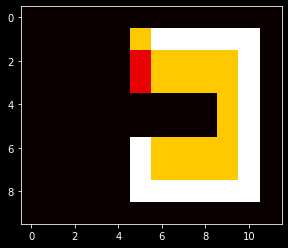

Sample trajectory on learned policy in episode 241:


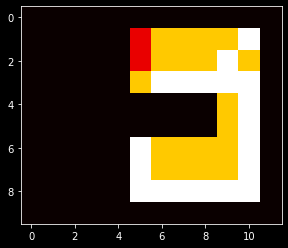

Sample trajectory on learned policy in episode 242:


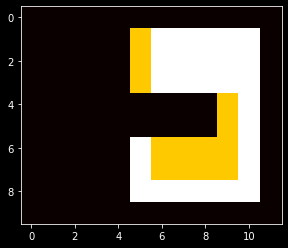

Sample trajectory on learned policy in episode 243:


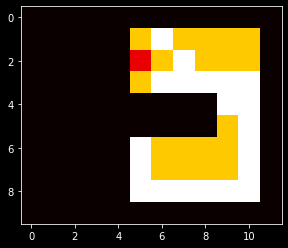

Sample trajectory on learned policy in episode 244:


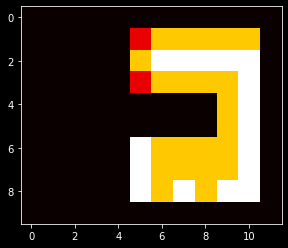

Sample trajectory on learned policy in episode 245:


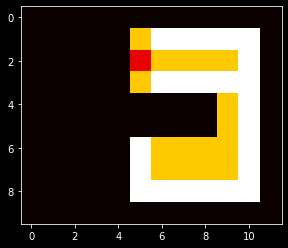

Sample trajectory on learned policy in episode 246:


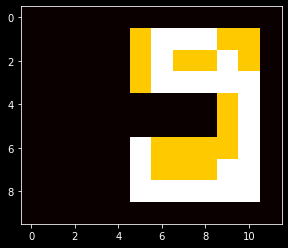

Sample trajectory on learned policy in episode 247:


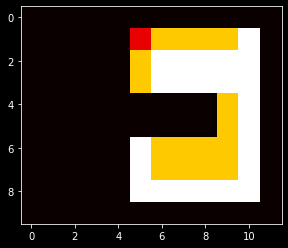

Sample trajectory on learned policy in episode 248:


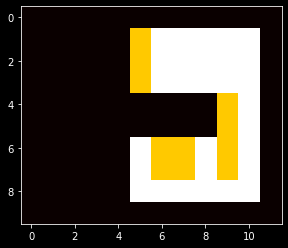

Sample trajectory on learned policy in episode 249:


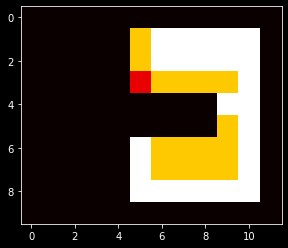

Sample trajectory on learned policy in episode 250:


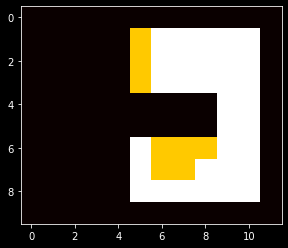

Sample trajectory on learned policy in episode 251:


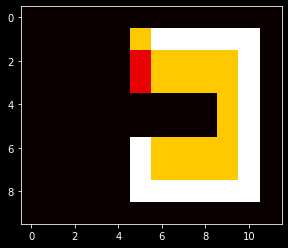

Sample trajectory on learned policy in episode 252:


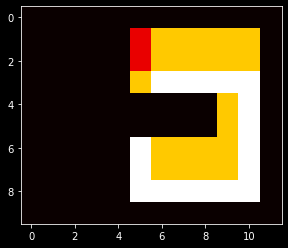

Sample trajectory on learned policy in episode 253:


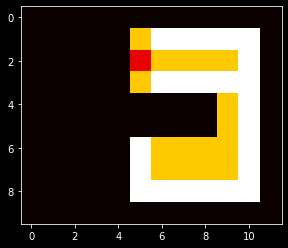

Sample trajectory on learned policy in episode 254:


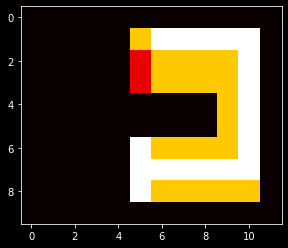

Sample trajectory on learned policy in episode 255:


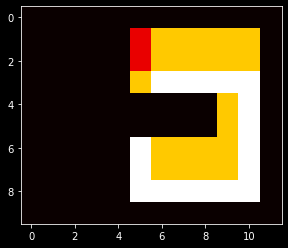

Sample trajectory on learned policy in episode 256:


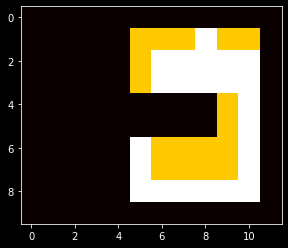

Sample trajectory on learned policy in episode 257:


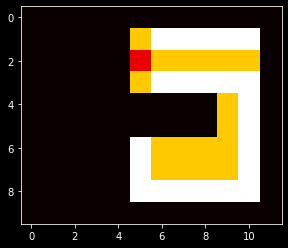

Sample trajectory on learned policy in episode 258:


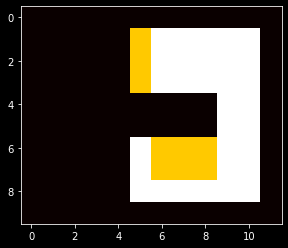

Sample trajectory on learned policy in episode 259:


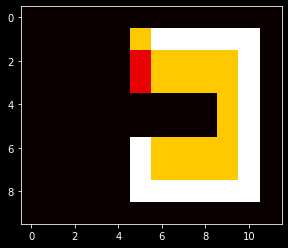

Sample trajectory on learned policy in episode 260:


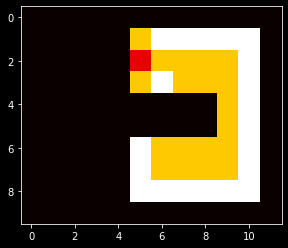

Sample trajectory on learned policy in episode 261:


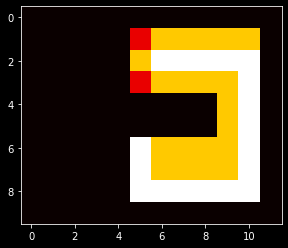

Sample trajectory on learned policy in episode 262:


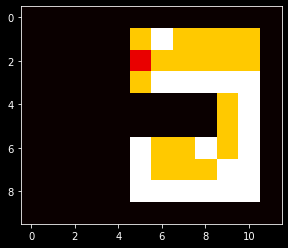



















episode:  26%|██████████████████▍                                                   | 263/1000 [00:22<01:03, 11.57it/s]

Sample trajectory on learned policy in episode 263:


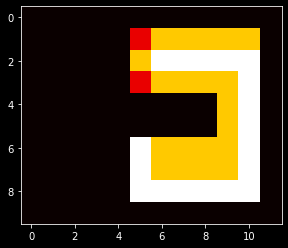

Sample trajectory on learned policy in episode 264:


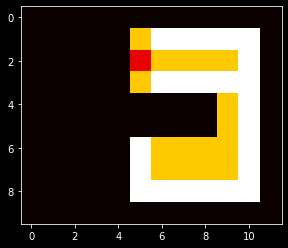

Sample trajectory on learned policy in episode 265:


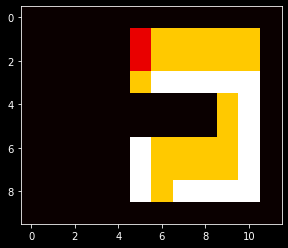

Sample trajectory on learned policy in episode 266:


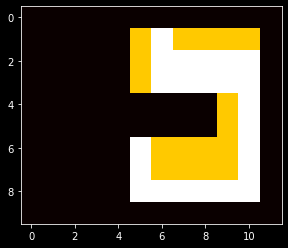

Sample trajectory on learned policy in episode 267:


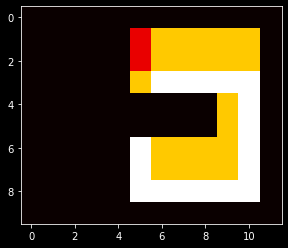

Sample trajectory on learned policy in episode 268:


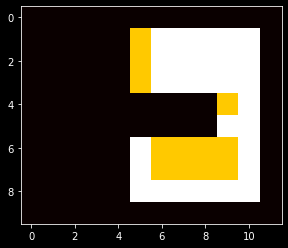

Sample trajectory on learned policy in episode 269:


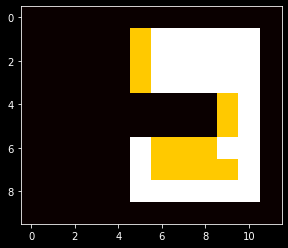

Sample trajectory on learned policy in episode 270:


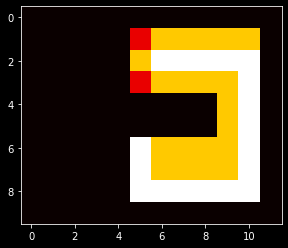

Sample trajectory on learned policy in episode 271:


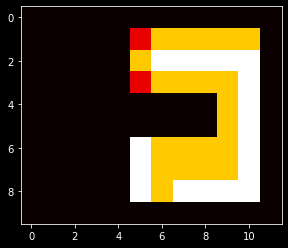

Sample trajectory on learned policy in episode 272:


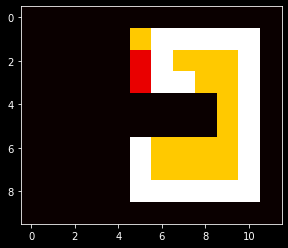

Sample trajectory on learned policy in episode 273:


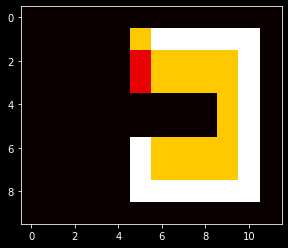

Sample trajectory on learned policy in episode 274:


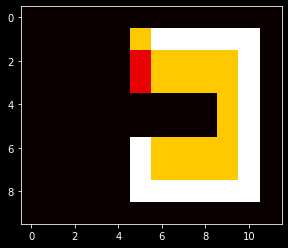

Sample trajectory on learned policy in episode 275:


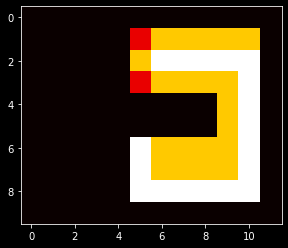

Sample trajectory on learned policy in episode 276:


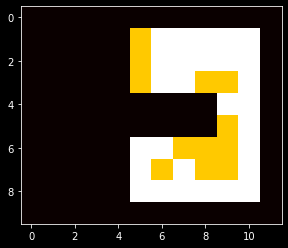

Sample trajectory on learned policy in episode 277:


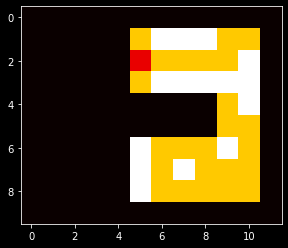

Sample trajectory on learned policy in episode 278:


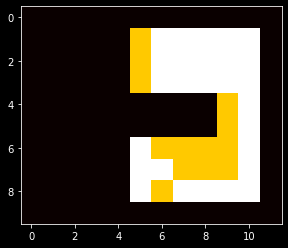

Sample trajectory on learned policy in episode 279:


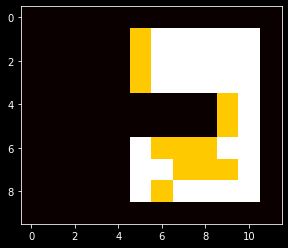

Sample trajectory on learned policy in episode 280:


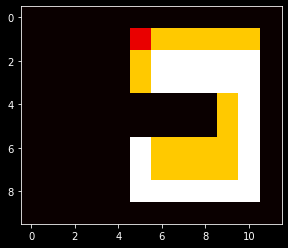

Sample trajectory on learned policy in episode 281:


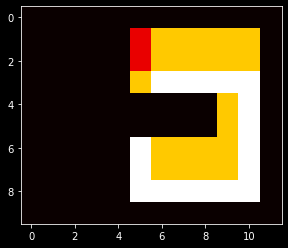

Sample trajectory on learned policy in episode 282:


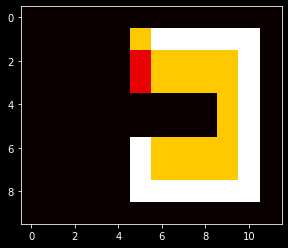

Sample trajectory on learned policy in episode 283:


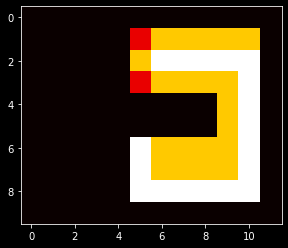

Sample trajectory on learned policy in episode 284:


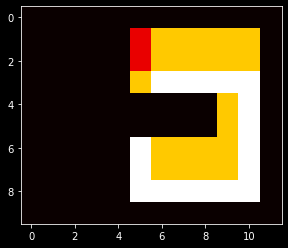

Sample trajectory on learned policy in episode 285:


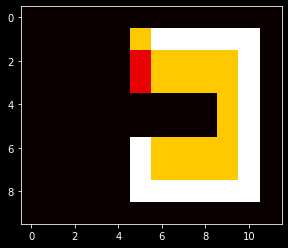

Sample trajectory on learned policy in episode 286:


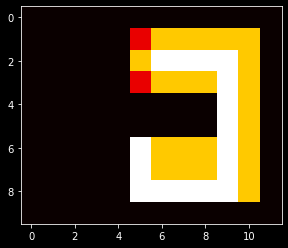



















episode:  29%|████████████████████                                                  | 287/1000 [00:24<01:01, 11.56it/s]

Sample trajectory on learned policy in episode 287:


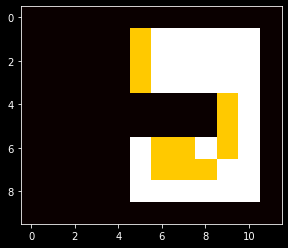

Sample trajectory on learned policy in episode 288:


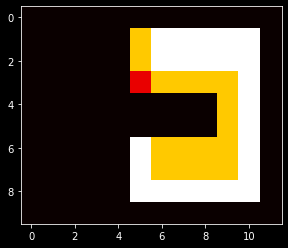

Sample trajectory on learned policy in episode 289:


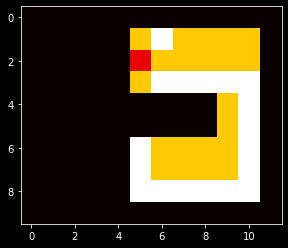

Sample trajectory on learned policy in episode 290:


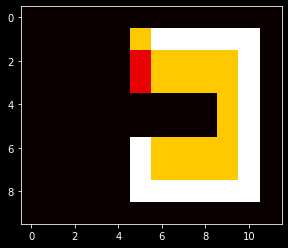

Sample trajectory on learned policy in episode 291:


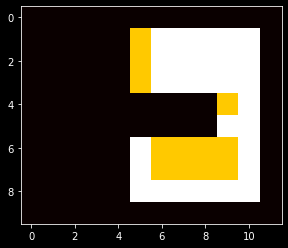

Sample trajectory on learned policy in episode 292:


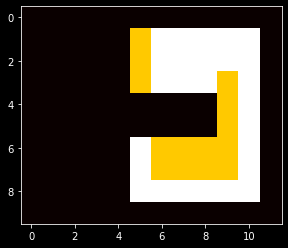

Sample trajectory on learned policy in episode 293:


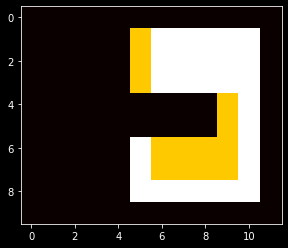

Sample trajectory on learned policy in episode 294:


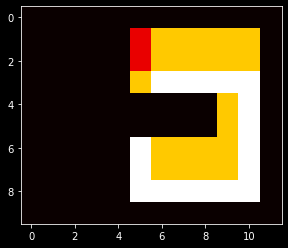

Sample trajectory on learned policy in episode 295:


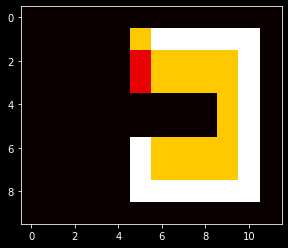

Sample trajectory on learned policy in episode 296:


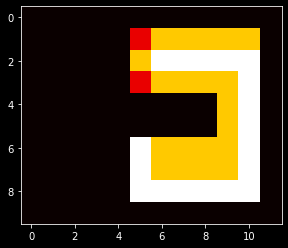

Sample trajectory on learned policy in episode 297:


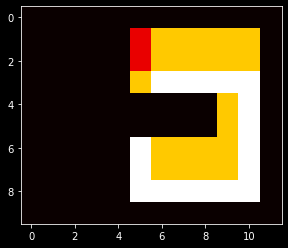

Sample trajectory on learned policy in episode 298:


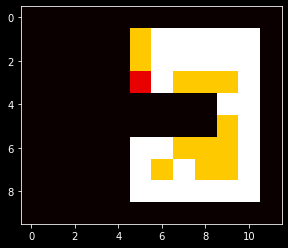

Sample trajectory on learned policy in episode 299:


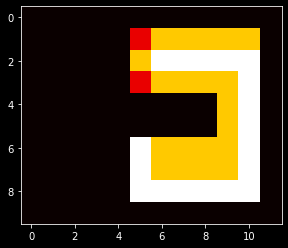

Sample trajectory on learned policy in episode 300:


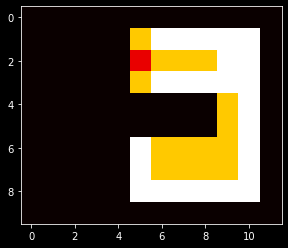

Sample trajectory on learned policy in episode 301:


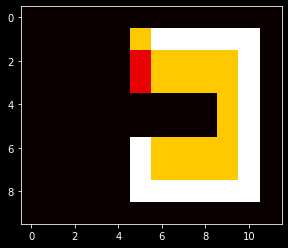

Sample trajectory on learned policy in episode 302:


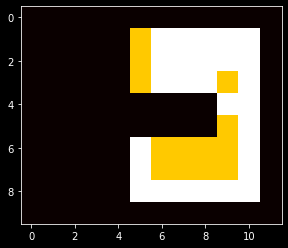

Sample trajectory on learned policy in episode 303:


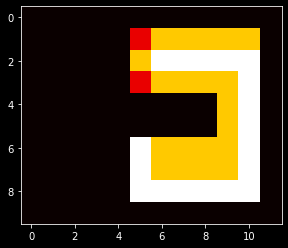

Sample trajectory on learned policy in episode 304:


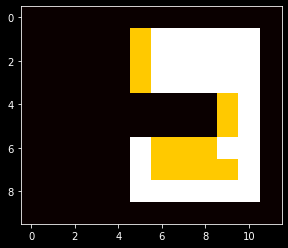

Sample trajectory on learned policy in episode 305:


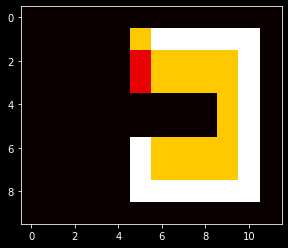

Sample trajectory on learned policy in episode 306:


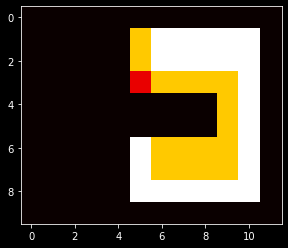

Sample trajectory on learned policy in episode 307:


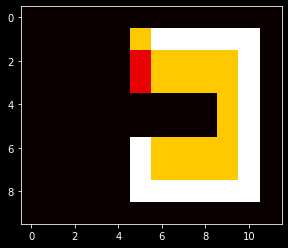

Sample trajectory on learned policy in episode 308:


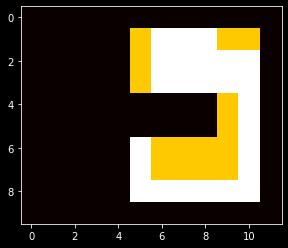

Sample trajectory on learned policy in episode 309:


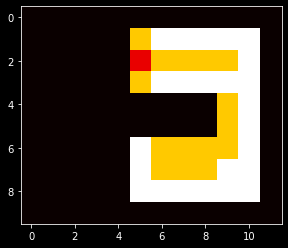



















episode:  31%|█████████████████████▋                                                | 310/1000 [00:26<01:00, 11.41it/s]

Sample trajectory on learned policy in episode 310:


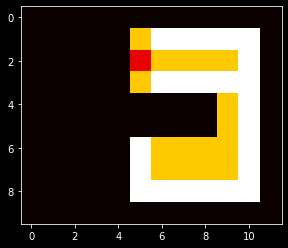

Sample trajectory on learned policy in episode 311:


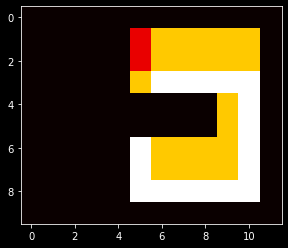

Sample trajectory on learned policy in episode 312:


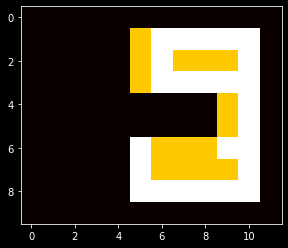

Sample trajectory on learned policy in episode 313:


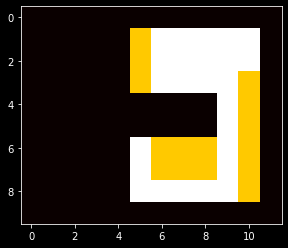

Sample trajectory on learned policy in episode 314:


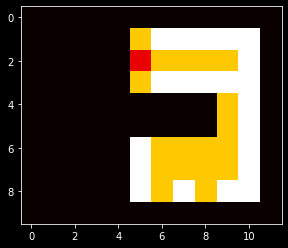

Sample trajectory on learned policy in episode 315:


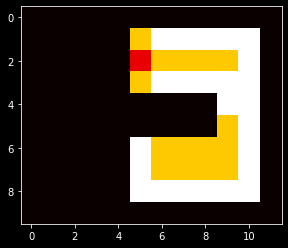

Sample trajectory on learned policy in episode 316:


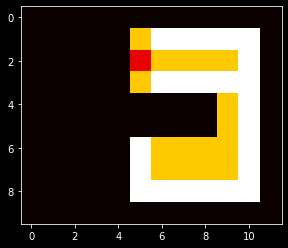

Sample trajectory on learned policy in episode 317:


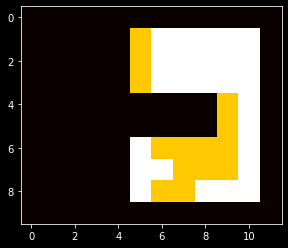

Sample trajectory on learned policy in episode 318:


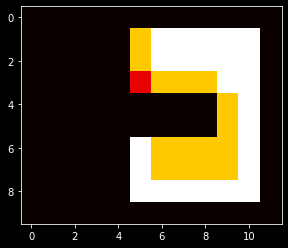

Sample trajectory on learned policy in episode 319:


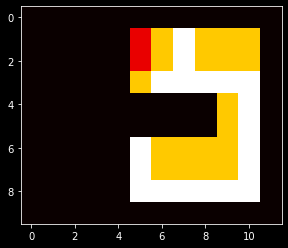

Sample trajectory on learned policy in episode 320:


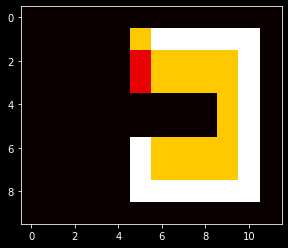

Sample trajectory on learned policy in episode 321:


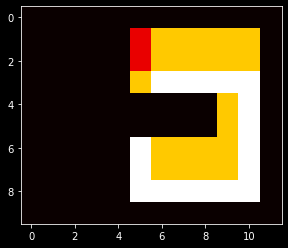

Sample trajectory on learned policy in episode 322:


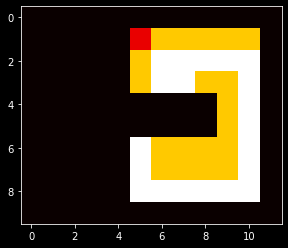

Sample trajectory on learned policy in episode 323:


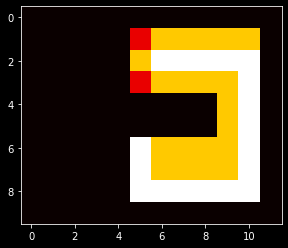

Sample trajectory on learned policy in episode 324:


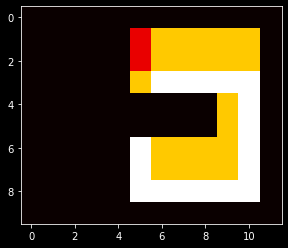

Sample trajectory on learned policy in episode 325:


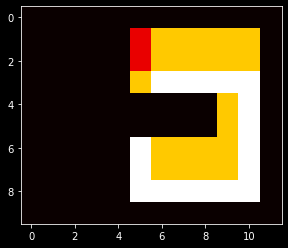

Sample trajectory on learned policy in episode 326:


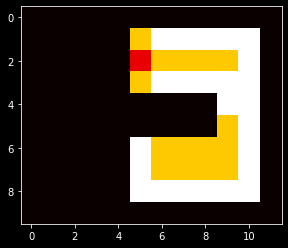

Sample trajectory on learned policy in episode 327:


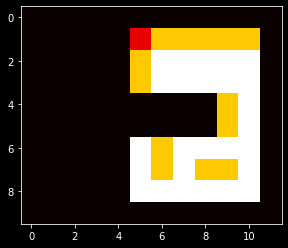

Sample trajectory on learned policy in episode 328:


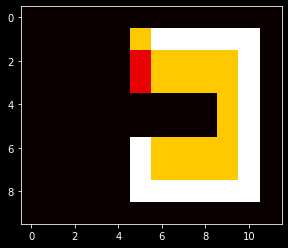

Sample trajectory on learned policy in episode 329:


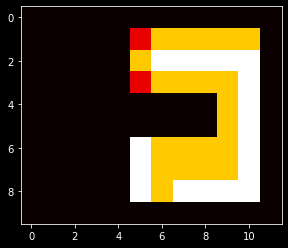

Sample trajectory on learned policy in episode 330:


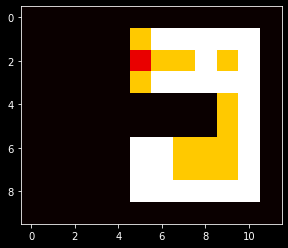

Sample trajectory on learned policy in episode 331:


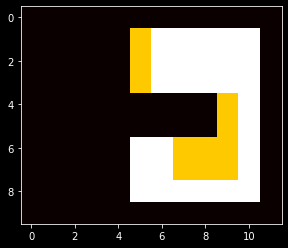

Sample trajectory on learned policy in episode 332:


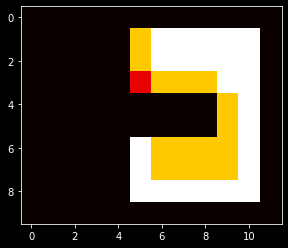



















episode:  33%|███████████████████████▎                                              | 333/1000 [00:28<00:59, 11.21it/s]

Sample trajectory on learned policy in episode 333:


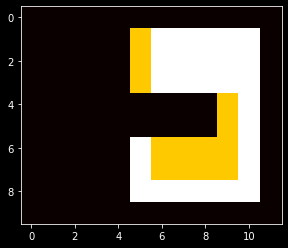

Sample trajectory on learned policy in episode 334:


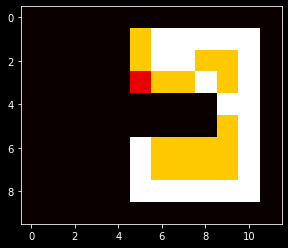

Sample trajectory on learned policy in episode 335:


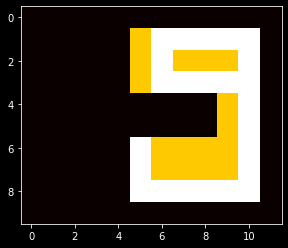

Sample trajectory on learned policy in episode 336:


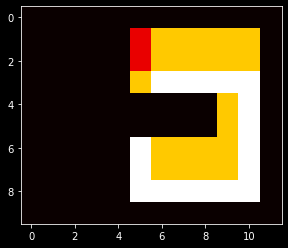

Sample trajectory on learned policy in episode 337:


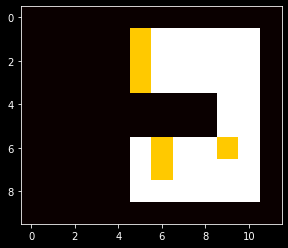

Sample trajectory on learned policy in episode 338:


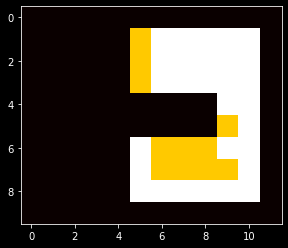

Sample trajectory on learned policy in episode 339:


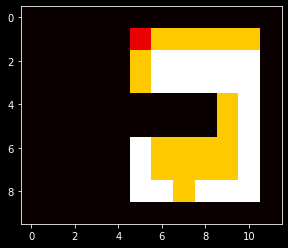

Sample trajectory on learned policy in episode 340:


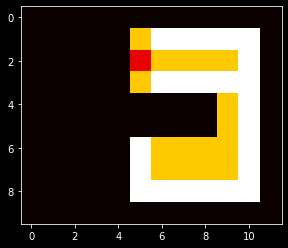

Sample trajectory on learned policy in episode 341:


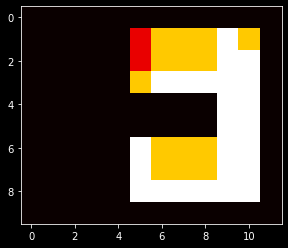

Sample trajectory on learned policy in episode 342:


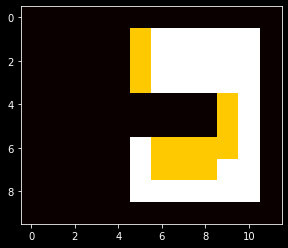

Sample trajectory on learned policy in episode 343:


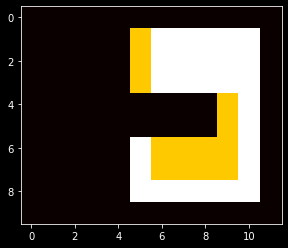

Sample trajectory on learned policy in episode 344:


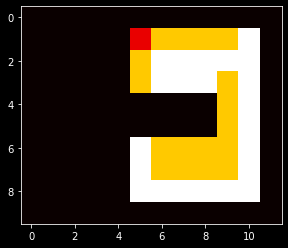

Sample trajectory on learned policy in episode 345:


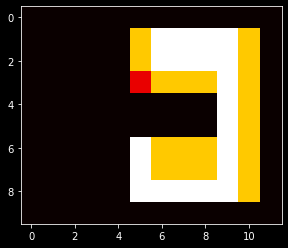

Sample trajectory on learned policy in episode 346:


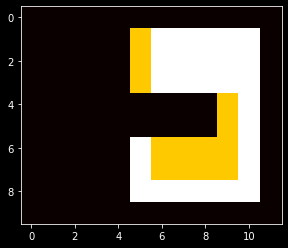

Sample trajectory on learned policy in episode 347:


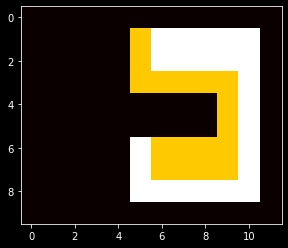

Sample trajectory on learned policy in episode 348:


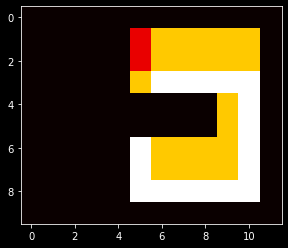

Sample trajectory on learned policy in episode 349:


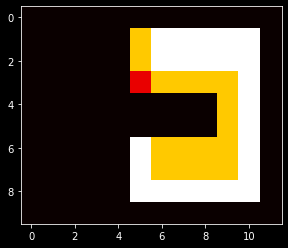

Sample trajectory on learned policy in episode 350:


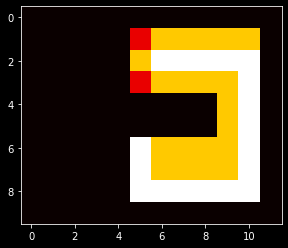

Sample trajectory on learned policy in episode 351:


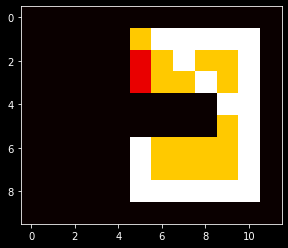

Sample trajectory on learned policy in episode 352:


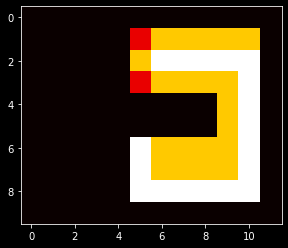

Sample trajectory on learned policy in episode 353:


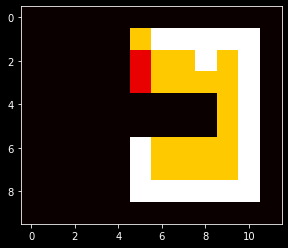

Sample trajectory on learned policy in episode 354:


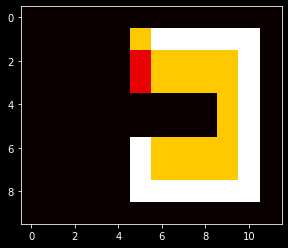

Sample trajectory on learned policy in episode 355:


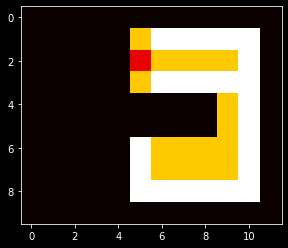



















episode:  36%|████████████████████████▉                                             | 356/1000 [00:31<00:57, 11.23it/s]

Sample trajectory on learned policy in episode 356:


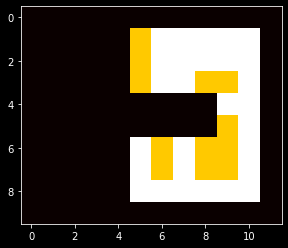

Sample trajectory on learned policy in episode 357:


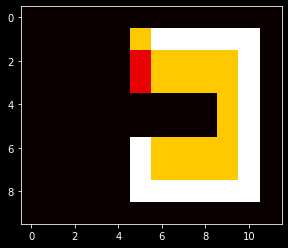

Sample trajectory on learned policy in episode 358:


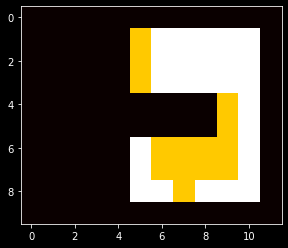

Sample trajectory on learned policy in episode 359:


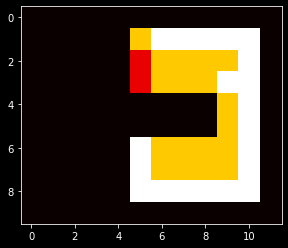

Sample trajectory on learned policy in episode 360:


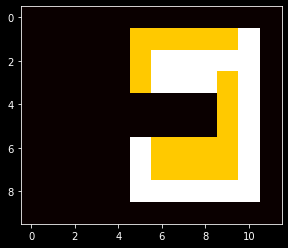

Sample trajectory on learned policy in episode 361:


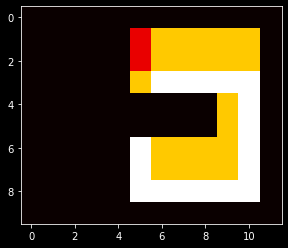

Sample trajectory on learned policy in episode 362:


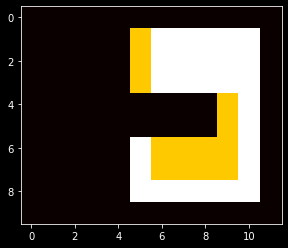

Sample trajectory on learned policy in episode 363:


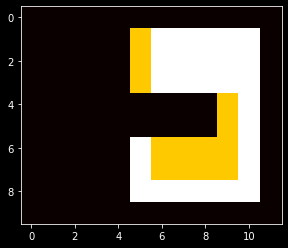

Sample trajectory on learned policy in episode 364:


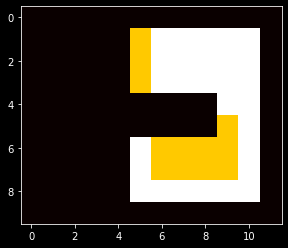

Sample trajectory on learned policy in episode 365:


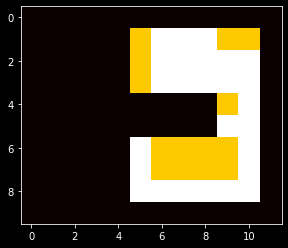

Sample trajectory on learned policy in episode 366:


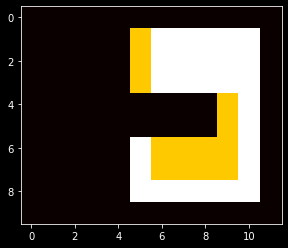

Sample trajectory on learned policy in episode 367:


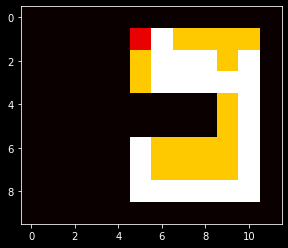

Sample trajectory on learned policy in episode 368:


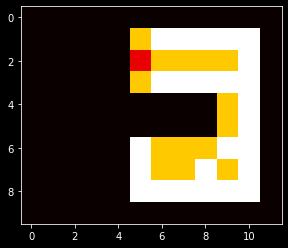

Sample trajectory on learned policy in episode 369:


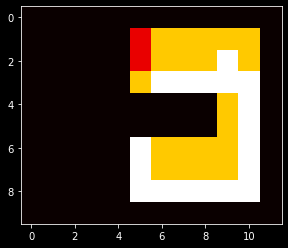

Sample trajectory on learned policy in episode 370:


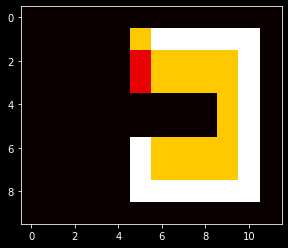

Sample trajectory on learned policy in episode 371:


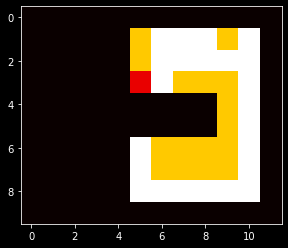

Sample trajectory on learned policy in episode 372:


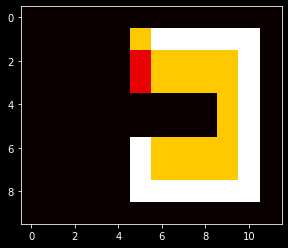

Sample trajectory on learned policy in episode 373:


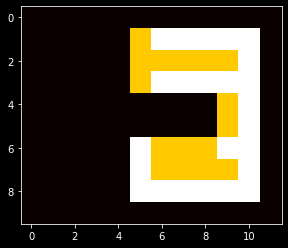

Sample trajectory on learned policy in episode 374:


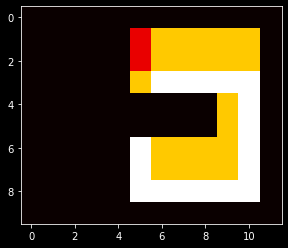

Sample trajectory on learned policy in episode 375:


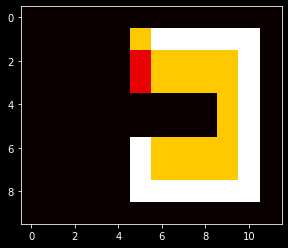

Sample trajectory on learned policy in episode 376:


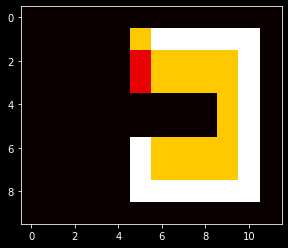

Sample trajectory on learned policy in episode 377:


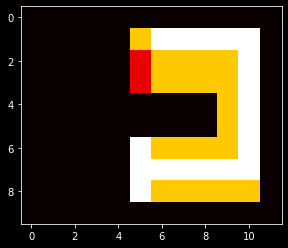

Sample trajectory on learned policy in episode 378:


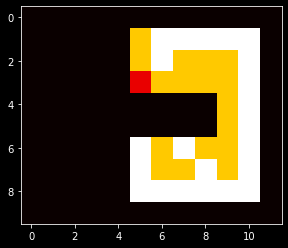



















episode:  38%|██████████████████████████▌                                           | 379/1000 [00:33<00:55, 11.22it/s]

Sample trajectory on learned policy in episode 379:


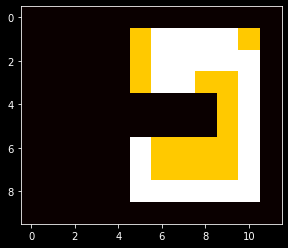

Sample trajectory on learned policy in episode 380:


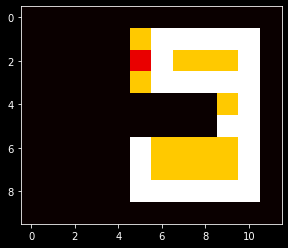

Sample trajectory on learned policy in episode 381:


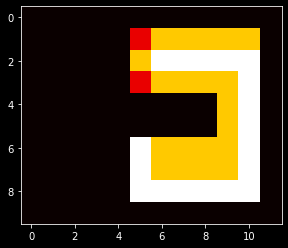

Sample trajectory on learned policy in episode 382:


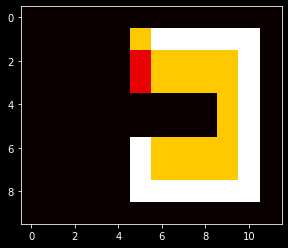

Sample trajectory on learned policy in episode 383:


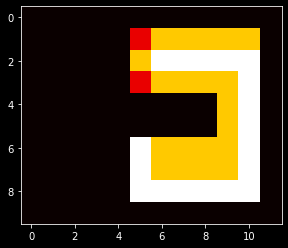

Sample trajectory on learned policy in episode 384:


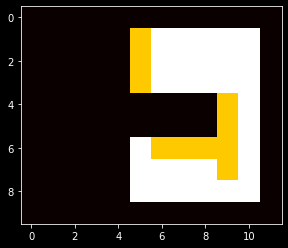

Sample trajectory on learned policy in episode 385:


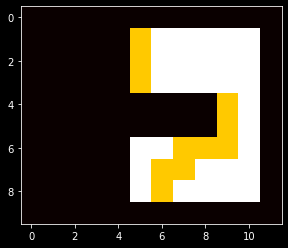

Sample trajectory on learned policy in episode 386:


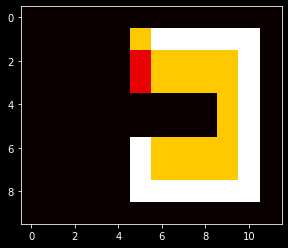

Sample trajectory on learned policy in episode 387:


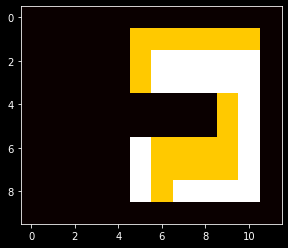

Sample trajectory on learned policy in episode 388:


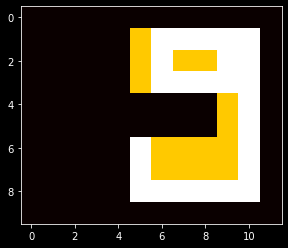

Sample trajectory on learned policy in episode 389:


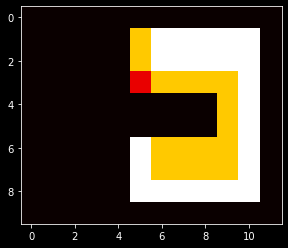

Sample trajectory on learned policy in episode 390:


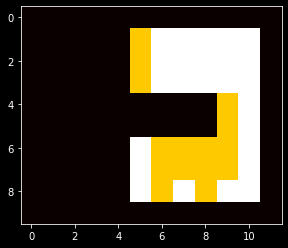

Sample trajectory on learned policy in episode 391:


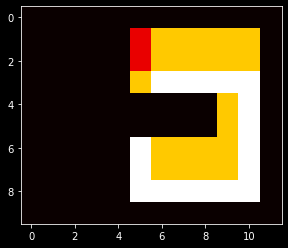

Sample trajectory on learned policy in episode 392:


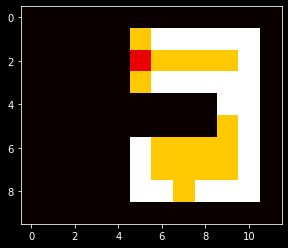

Sample trajectory on learned policy in episode 393:


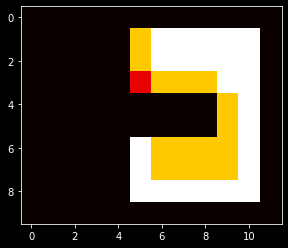

Sample trajectory on learned policy in episode 394:


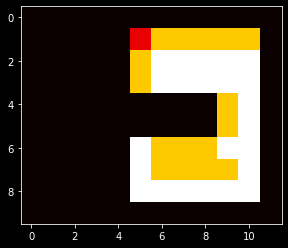

Sample trajectory on learned policy in episode 395:


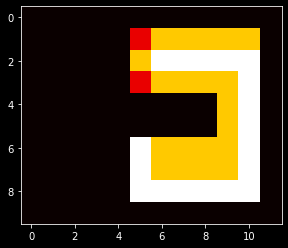

Sample trajectory on learned policy in episode 396:


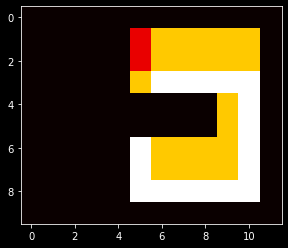

Sample trajectory on learned policy in episode 397:


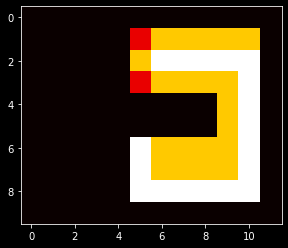

Sample trajectory on learned policy in episode 398:


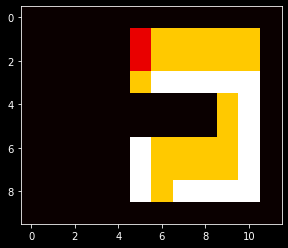

Sample trajectory on learned policy in episode 399:


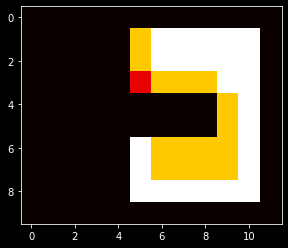

Sample trajectory on learned policy in episode 400:


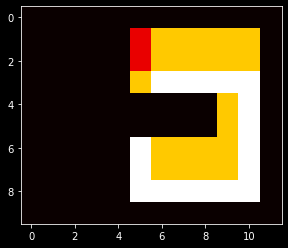

Sample trajectory on learned policy in episode 401:


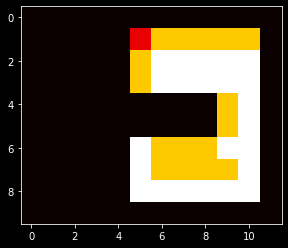

Sample trajectory on learned policy in episode 402:


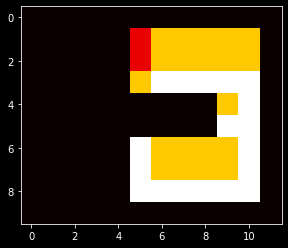



















episode:  40%|████████████████████████████▏                                         | 403/1000 [00:35<00:52, 11.34it/s]

Sample trajectory on learned policy in episode 403:


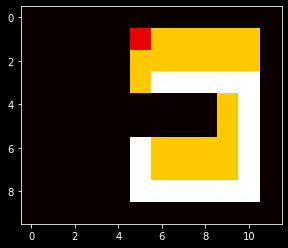

Sample trajectory on learned policy in episode 404:


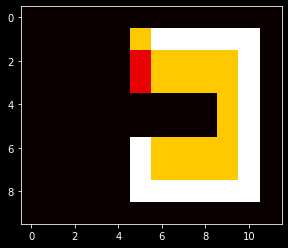

Sample trajectory on learned policy in episode 405:


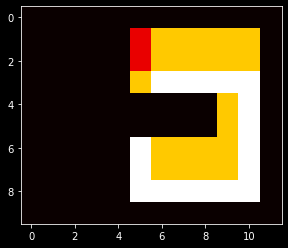

Sample trajectory on learned policy in episode 406:


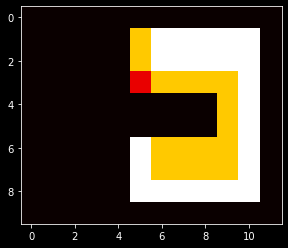

Sample trajectory on learned policy in episode 407:


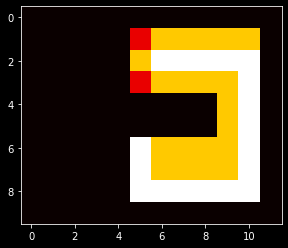

Sample trajectory on learned policy in episode 408:


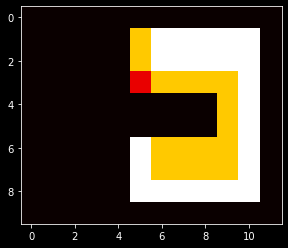

Sample trajectory on learned policy in episode 409:


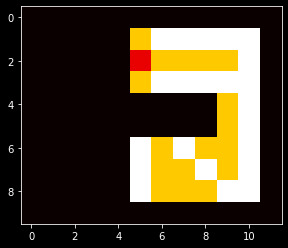

Sample trajectory on learned policy in episode 410:


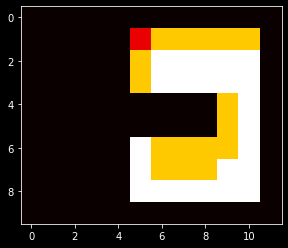

Sample trajectory on learned policy in episode 411:


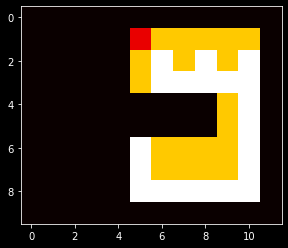

Sample trajectory on learned policy in episode 412:


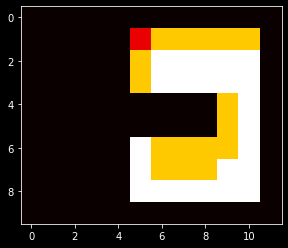

Sample trajectory on learned policy in episode 413:


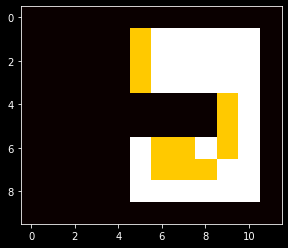

Sample trajectory on learned policy in episode 414:


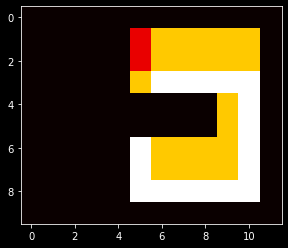

Sample trajectory on learned policy in episode 415:


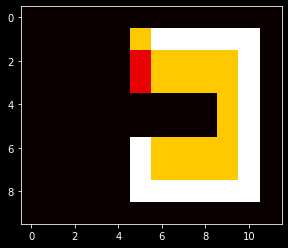

Sample trajectory on learned policy in episode 416:


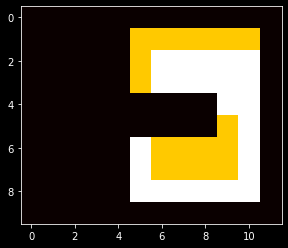

Sample trajectory on learned policy in episode 417:


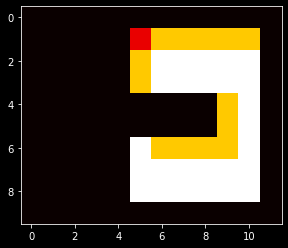

Sample trajectory on learned policy in episode 418:


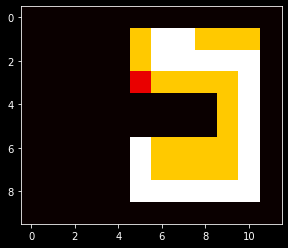

Sample trajectory on learned policy in episode 419:


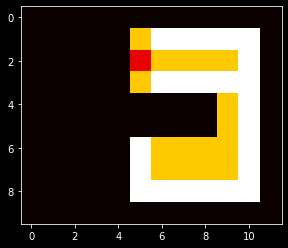

Sample trajectory on learned policy in episode 420:


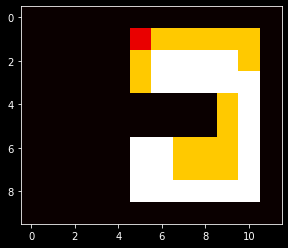

Sample trajectory on learned policy in episode 421:


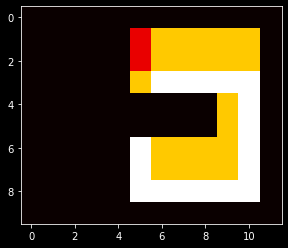

Sample trajectory on learned policy in episode 422:


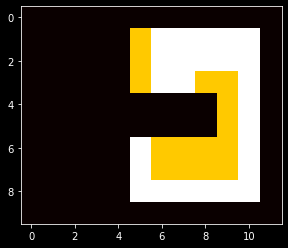

Sample trajectory on learned policy in episode 423:


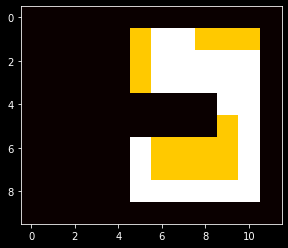

Sample trajectory on learned policy in episode 424:


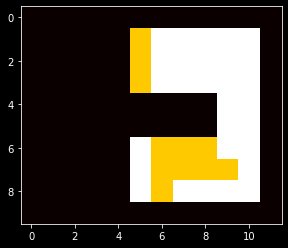

Sample trajectory on learned policy in episode 425:


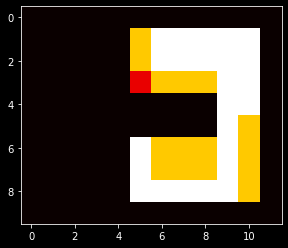



















episode:  43%|█████████████████████████████▊                                        | 426/1000 [00:37<00:50, 11.36it/s]

Sample trajectory on learned policy in episode 426:


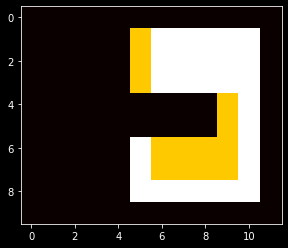

Sample trajectory on learned policy in episode 427:


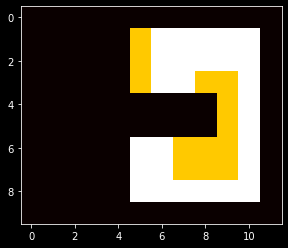

Sample trajectory on learned policy in episode 428:


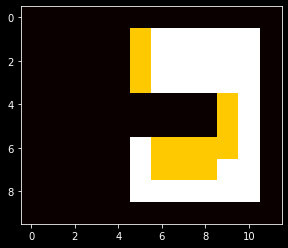

Sample trajectory on learned policy in episode 429:


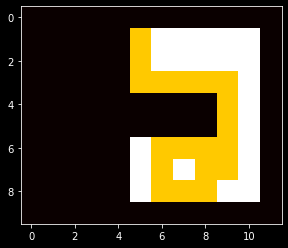

Sample trajectory on learned policy in episode 430:


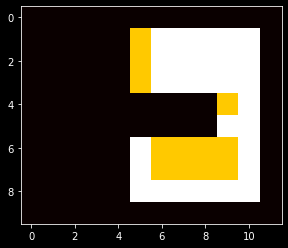

Sample trajectory on learned policy in episode 431:


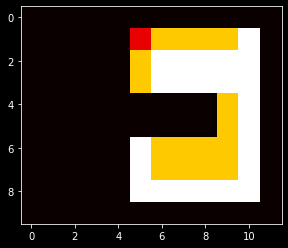

Sample trajectory on learned policy in episode 432:


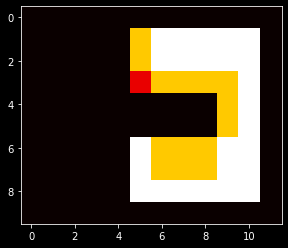

Sample trajectory on learned policy in episode 433:


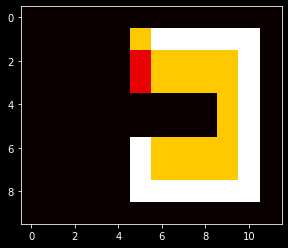

Sample trajectory on learned policy in episode 434:


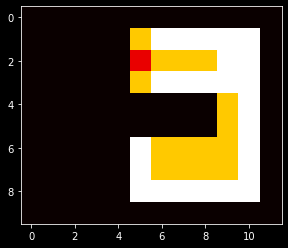

Sample trajectory on learned policy in episode 435:


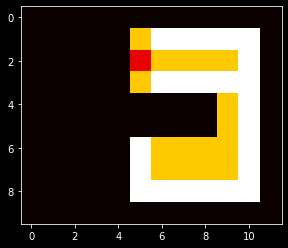

Sample trajectory on learned policy in episode 436:


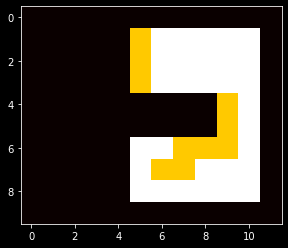

Sample trajectory on learned policy in episode 437:


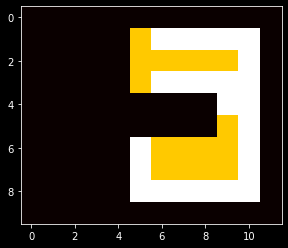

Sample trajectory on learned policy in episode 438:


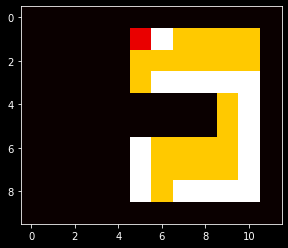

Sample trajectory on learned policy in episode 439:


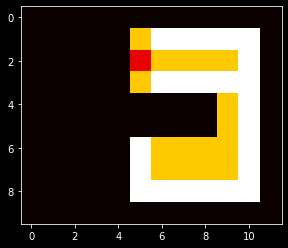

Sample trajectory on learned policy in episode 440:


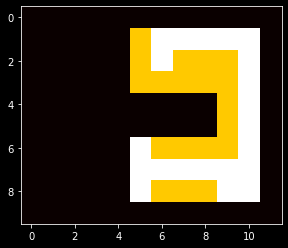

Sample trajectory on learned policy in episode 441:


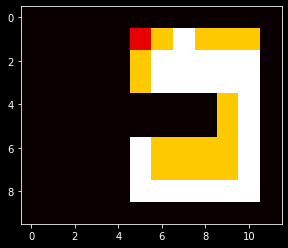

Sample trajectory on learned policy in episode 442:


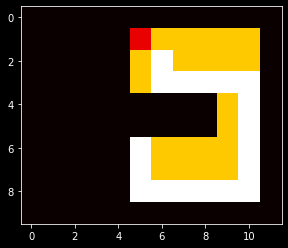

Sample trajectory on learned policy in episode 443:


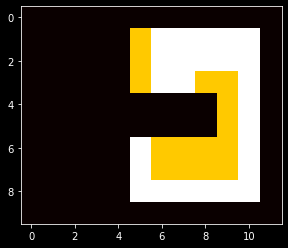

Sample trajectory on learned policy in episode 444:


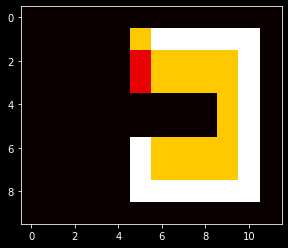

Sample trajectory on learned policy in episode 445:


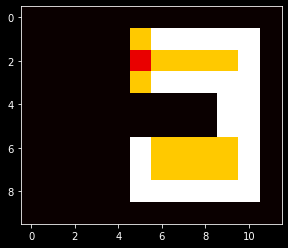

Sample trajectory on learned policy in episode 446:


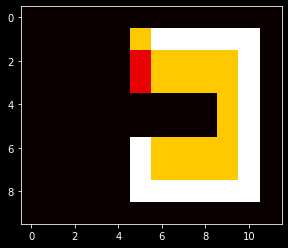

Sample trajectory on learned policy in episode 447:


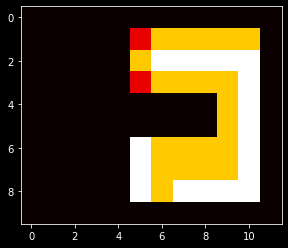

Sample trajectory on learned policy in episode 448:


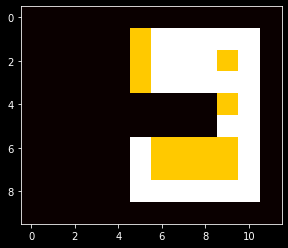

Sample trajectory on learned policy in episode 449:


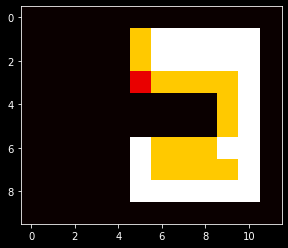



















episode:  45%|███████████████████████████████▌                                      | 450/1000 [00:39<00:48, 11.40it/s]

Sample trajectory on learned policy in episode 450:


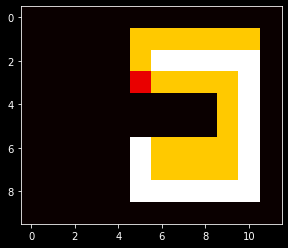

Sample trajectory on learned policy in episode 451:


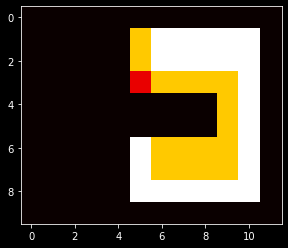

Sample trajectory on learned policy in episode 452:


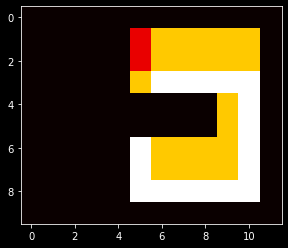

Sample trajectory on learned policy in episode 453:


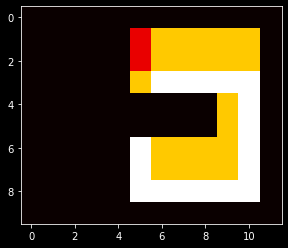

Sample trajectory on learned policy in episode 454:


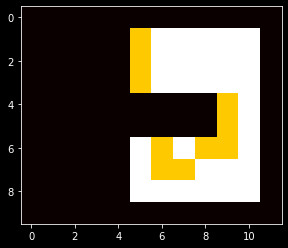

Sample trajectory on learned policy in episode 455:


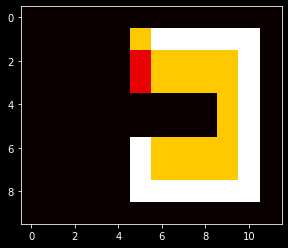

Sample trajectory on learned policy in episode 456:


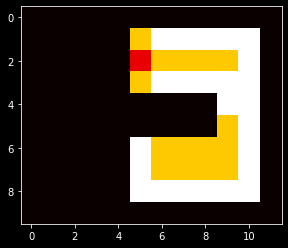

Sample trajectory on learned policy in episode 457:


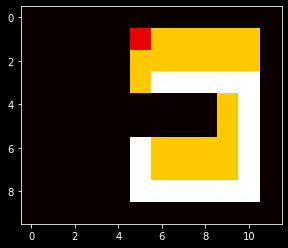

Sample trajectory on learned policy in episode 458:


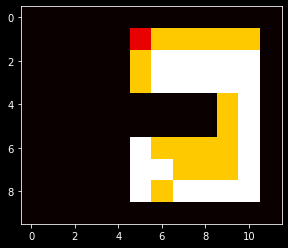

Sample trajectory on learned policy in episode 459:


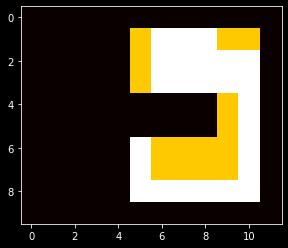

Sample trajectory on learned policy in episode 460:


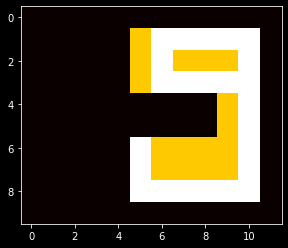

Sample trajectory on learned policy in episode 461:


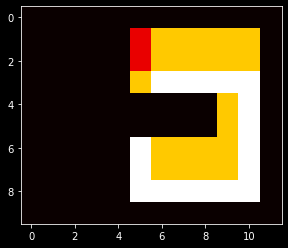

Sample trajectory on learned policy in episode 462:


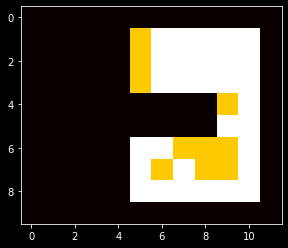

Sample trajectory on learned policy in episode 463:


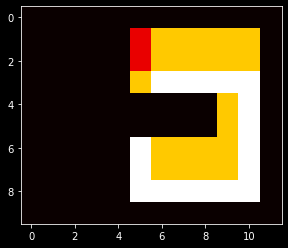

Sample trajectory on learned policy in episode 464:


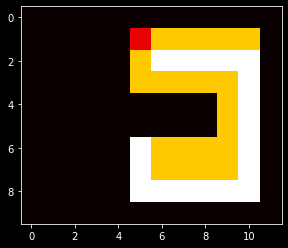

Sample trajectory on learned policy in episode 465:


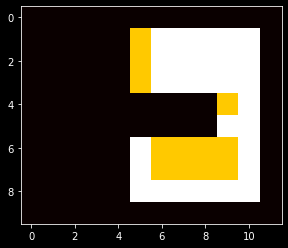

Sample trajectory on learned policy in episode 466:


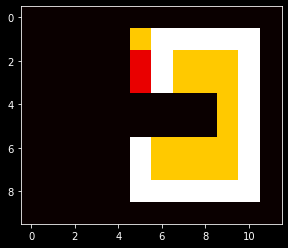

Sample trajectory on learned policy in episode 467:


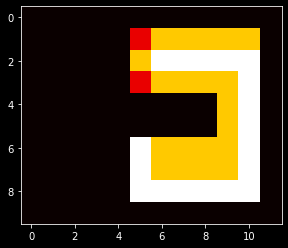

Sample trajectory on learned policy in episode 468:


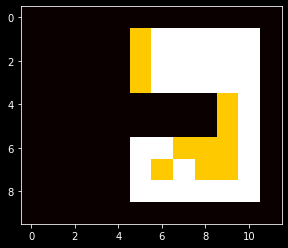

Sample trajectory on learned policy in episode 469:


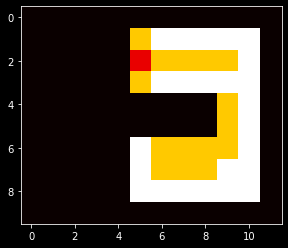

Sample trajectory on learned policy in episode 470:


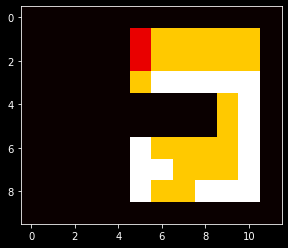

Sample trajectory on learned policy in episode 471:


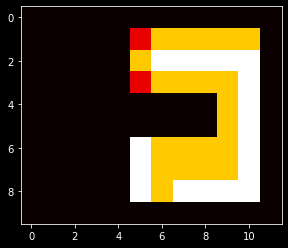

Sample trajectory on learned policy in episode 472:


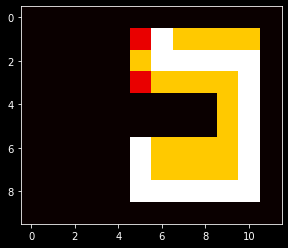

Sample trajectory on learned policy in episode 473:


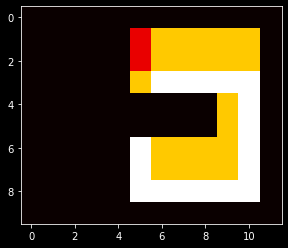



















episode:  47%|█████████████████████████████████▏                                    | 474/1000 [00:41<00:45, 11.46it/s]

Sample trajectory on learned policy in episode 474:


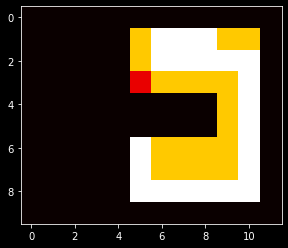

Sample trajectory on learned policy in episode 475:


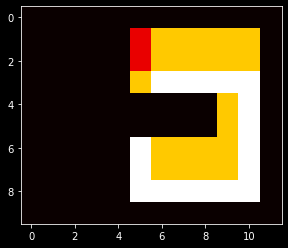

Sample trajectory on learned policy in episode 476:


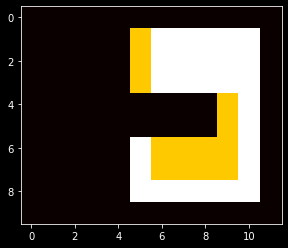

Sample trajectory on learned policy in episode 477:


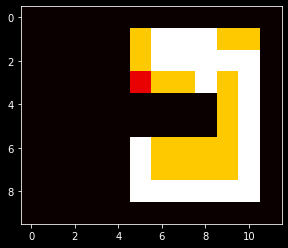

Sample trajectory on learned policy in episode 478:


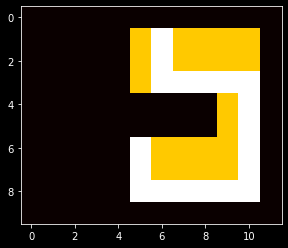

Sample trajectory on learned policy in episode 479:


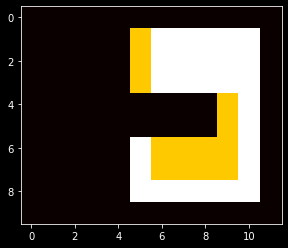

Sample trajectory on learned policy in episode 480:


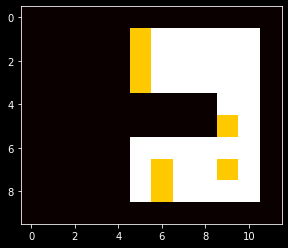

Sample trajectory on learned policy in episode 481:


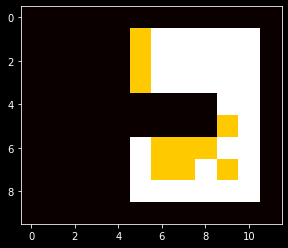

Sample trajectory on learned policy in episode 482:


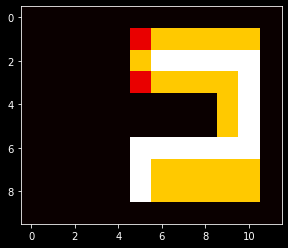

Sample trajectory on learned policy in episode 483:


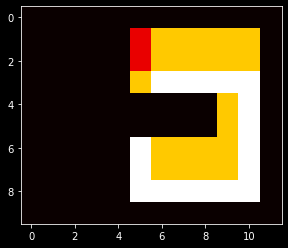

Sample trajectory on learned policy in episode 484:


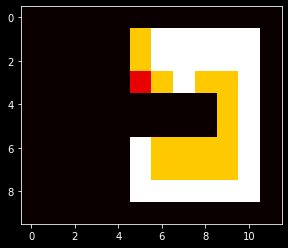

Sample trajectory on learned policy in episode 485:


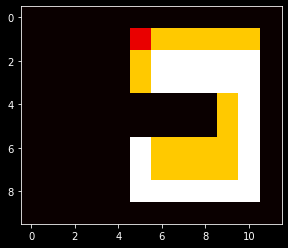

Sample trajectory on learned policy in episode 486:


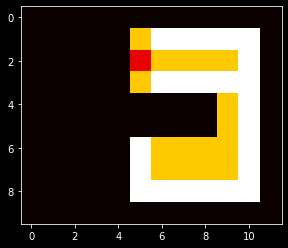

Sample trajectory on learned policy in episode 487:


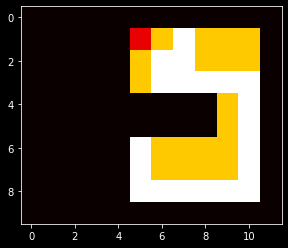

Sample trajectory on learned policy in episode 488:


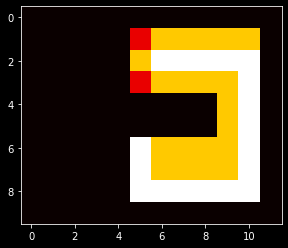

Sample trajectory on learned policy in episode 489:


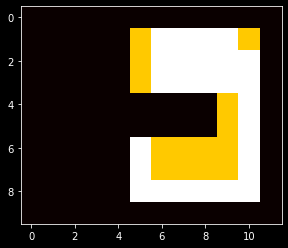

Sample trajectory on learned policy in episode 490:


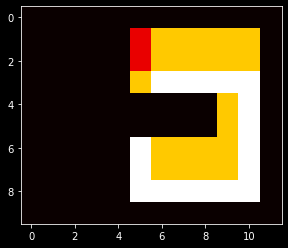

Sample trajectory on learned policy in episode 491:


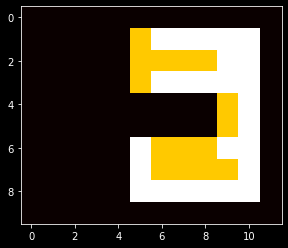

Sample trajectory on learned policy in episode 492:


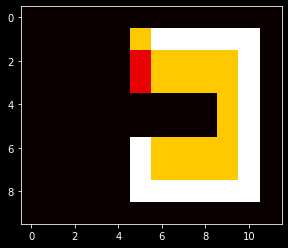

Sample trajectory on learned policy in episode 493:


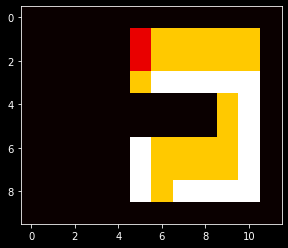

Sample trajectory on learned policy in episode 494:


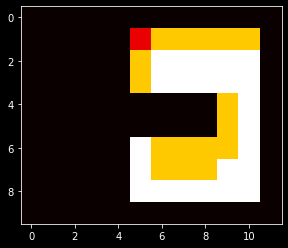

Sample trajectory on learned policy in episode 495:


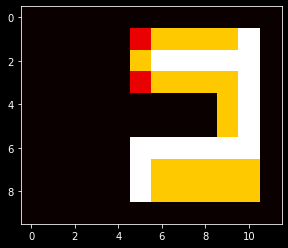

Sample trajectory on learned policy in episode 496:


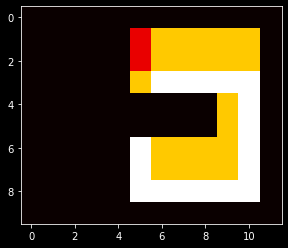



















episode:  50%|██████████████████████████████████▊                                   | 497/1000 [00:43<00:43, 11.47it/s]

Sample trajectory on learned policy in episode 497:


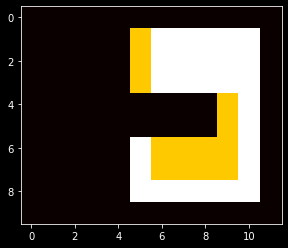

Sample trajectory on learned policy in episode 498:


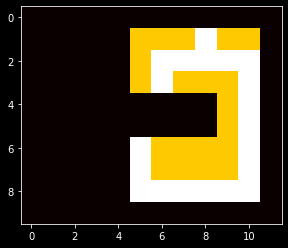

Sample trajectory on learned policy in episode 499:


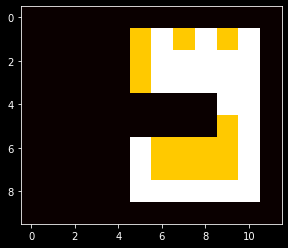

Sample trajectory on learned policy in episode 500:


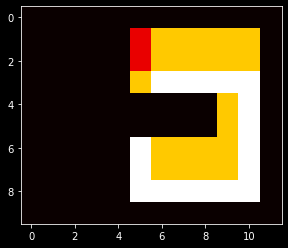

Sample trajectory on learned policy in episode 501:


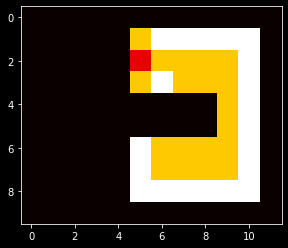

Sample trajectory on learned policy in episode 502:


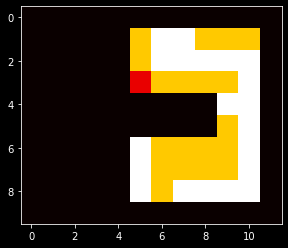

Sample trajectory on learned policy in episode 503:


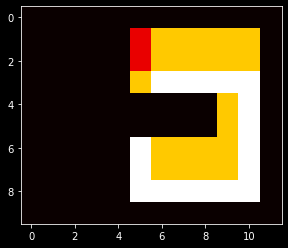

Sample trajectory on learned policy in episode 504:


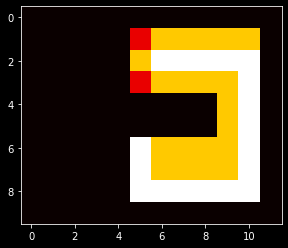

Sample trajectory on learned policy in episode 505:


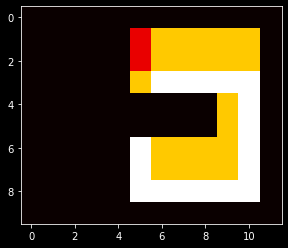

Sample trajectory on learned policy in episode 506:


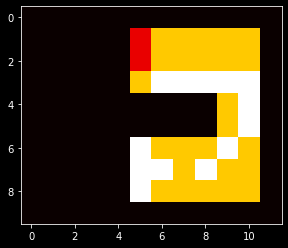

Sample trajectory on learned policy in episode 507:


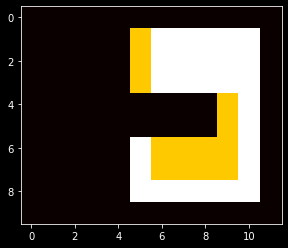

Sample trajectory on learned policy in episode 508:


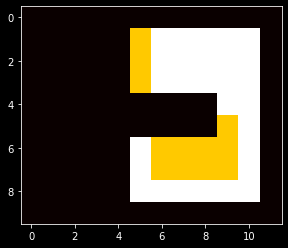

Sample trajectory on learned policy in episode 509:


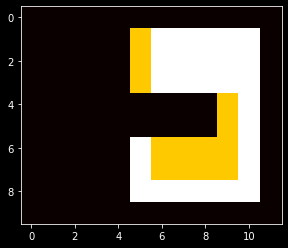

Sample trajectory on learned policy in episode 510:


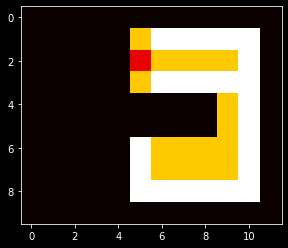

Sample trajectory on learned policy in episode 511:


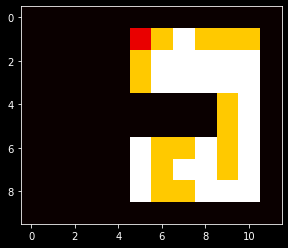

Sample trajectory on learned policy in episode 512:


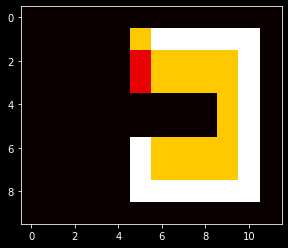

Sample trajectory on learned policy in episode 513:


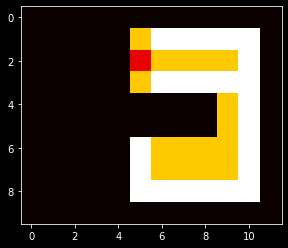

Sample trajectory on learned policy in episode 514:


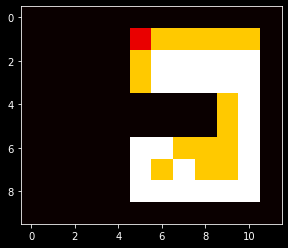

Sample trajectory on learned policy in episode 515:


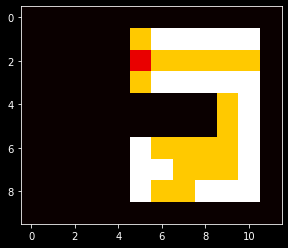

Sample trajectory on learned policy in episode 516:


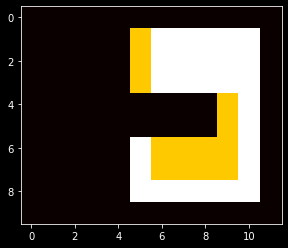

Sample trajectory on learned policy in episode 517:


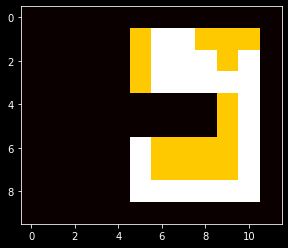

Sample trajectory on learned policy in episode 518:


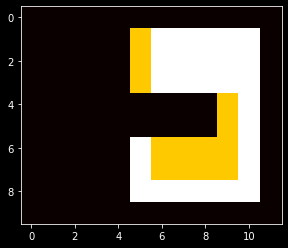

Sample trajectory on learned policy in episode 519:


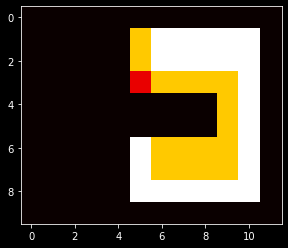



















episode:  52%|████████████████████████████████████▍                                 | 520/1000 [00:45<00:42, 11.41it/s]

Sample trajectory on learned policy in episode 520:


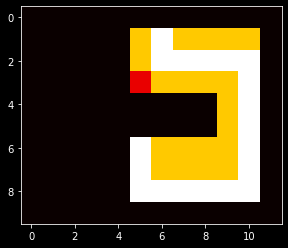

Sample trajectory on learned policy in episode 521:


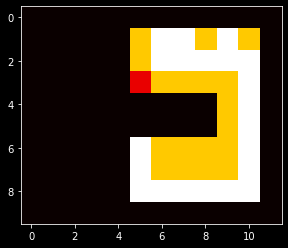

Sample trajectory on learned policy in episode 522:


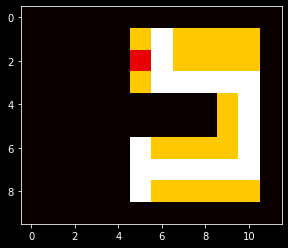

Sample trajectory on learned policy in episode 523:


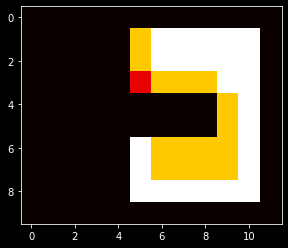

Sample trajectory on learned policy in episode 524:


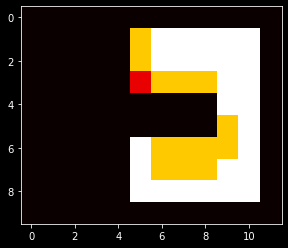

Sample trajectory on learned policy in episode 525:


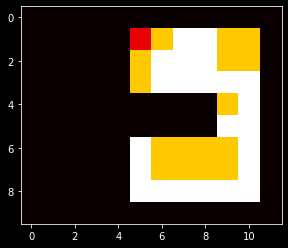

Sample trajectory on learned policy in episode 526:


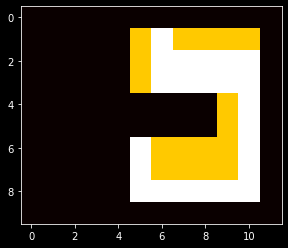

Sample trajectory on learned policy in episode 527:


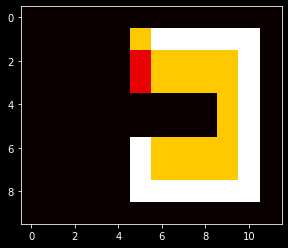

Sample trajectory on learned policy in episode 528:


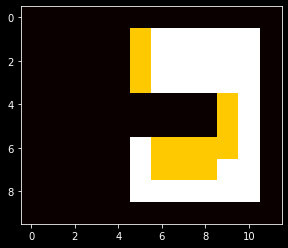

Sample trajectory on learned policy in episode 529:


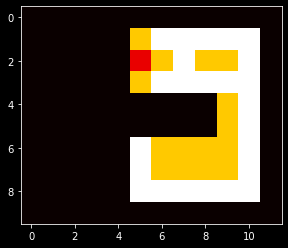

Sample trajectory on learned policy in episode 530:


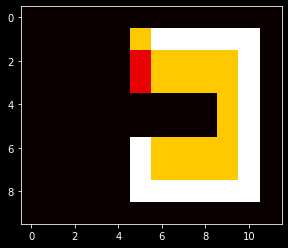

Sample trajectory on learned policy in episode 531:


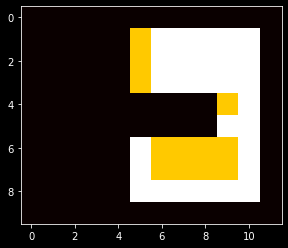

Sample trajectory on learned policy in episode 532:


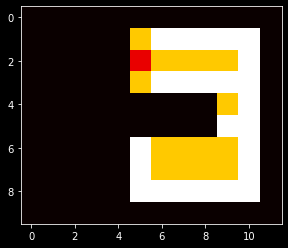

Sample trajectory on learned policy in episode 533:


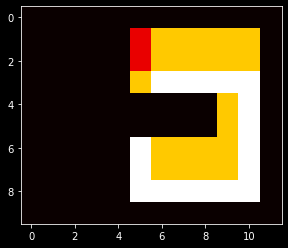

Sample trajectory on learned policy in episode 534:


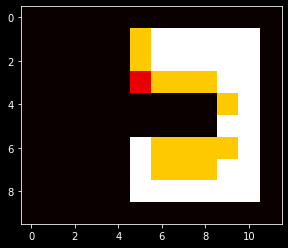

Sample trajectory on learned policy in episode 535:


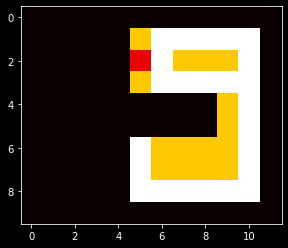

Sample trajectory on learned policy in episode 536:


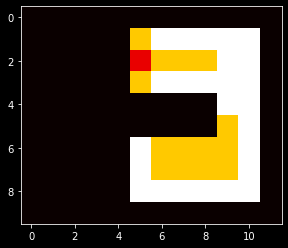

Sample trajectory on learned policy in episode 537:


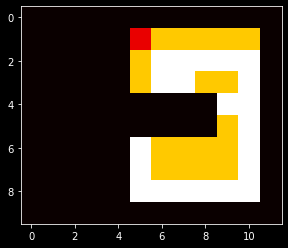

Sample trajectory on learned policy in episode 538:


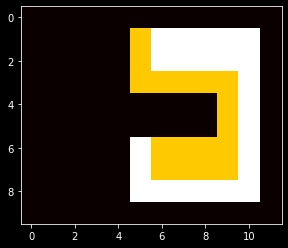

Sample trajectory on learned policy in episode 539:


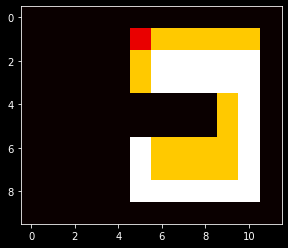

Sample trajectory on learned policy in episode 540:


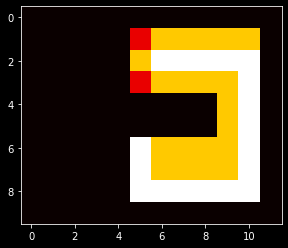

Sample trajectory on learned policy in episode 541:


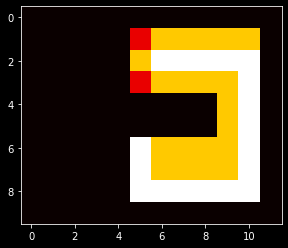

Sample trajectory on learned policy in episode 542:


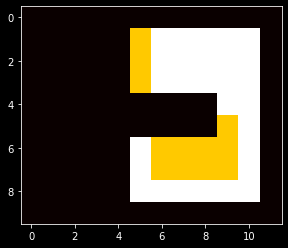



















episode:  54%|██████████████████████████████████████                                | 543/1000 [00:47<00:40, 11.39it/s]

Sample trajectory on learned policy in episode 543:


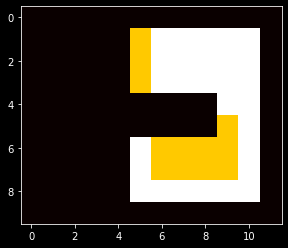

Sample trajectory on learned policy in episode 544:


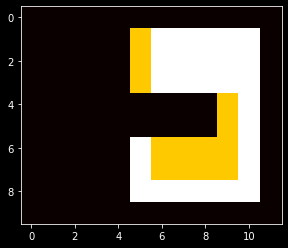

Sample trajectory on learned policy in episode 545:


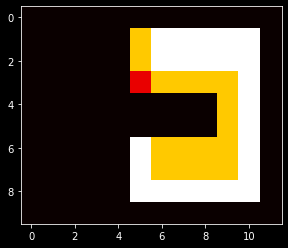

Sample trajectory on learned policy in episode 546:


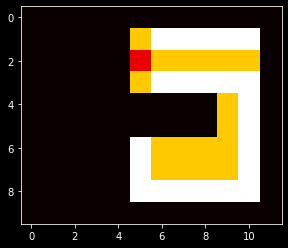

Sample trajectory on learned policy in episode 547:


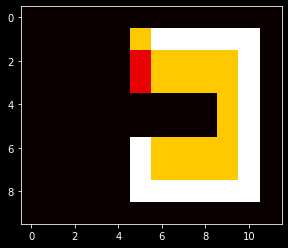

Sample trajectory on learned policy in episode 548:


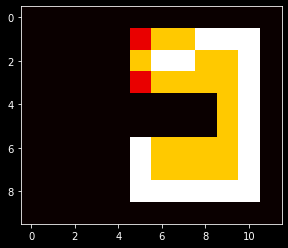

Sample trajectory on learned policy in episode 549:


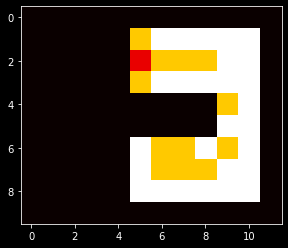

Sample trajectory on learned policy in episode 550:


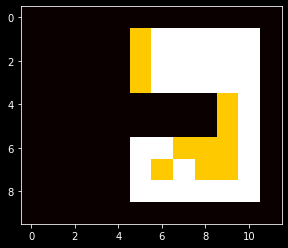

Sample trajectory on learned policy in episode 551:


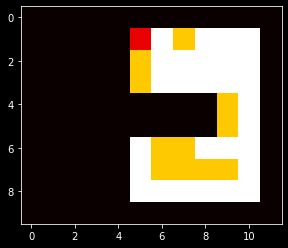

Sample trajectory on learned policy in episode 552:


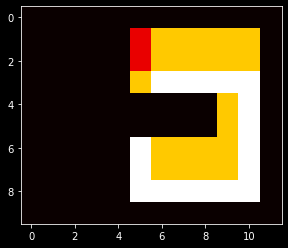

Sample trajectory on learned policy in episode 553:


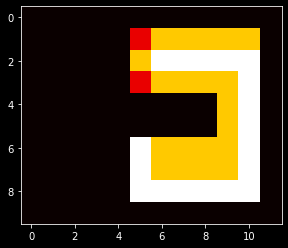

Sample trajectory on learned policy in episode 554:


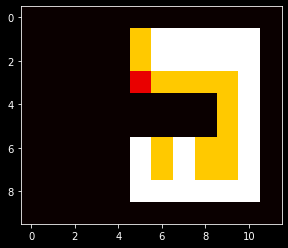

Sample trajectory on learned policy in episode 555:


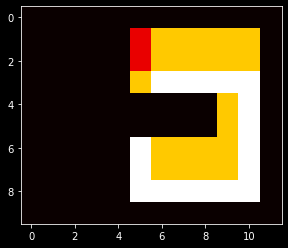

Sample trajectory on learned policy in episode 556:


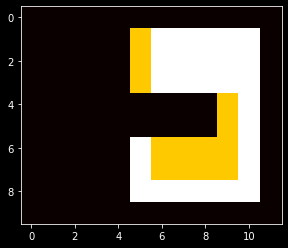

Sample trajectory on learned policy in episode 557:


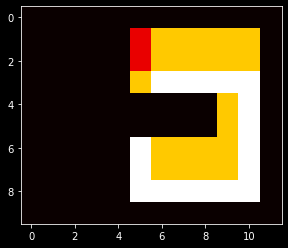

Sample trajectory on learned policy in episode 558:


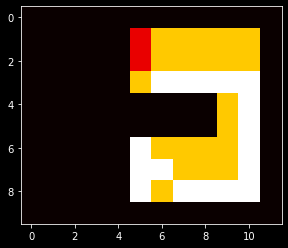

Sample trajectory on learned policy in episode 559:


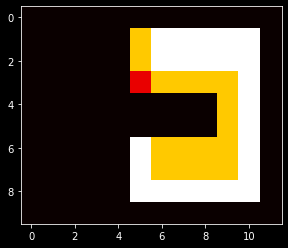

Sample trajectory on learned policy in episode 560:


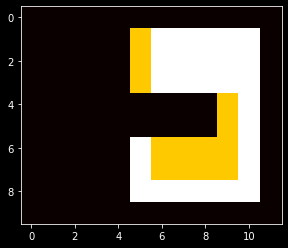

Sample trajectory on learned policy in episode 561:


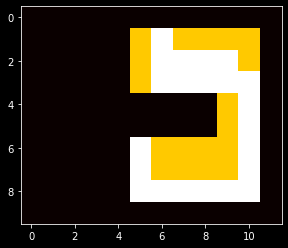

Sample trajectory on learned policy in episode 562:


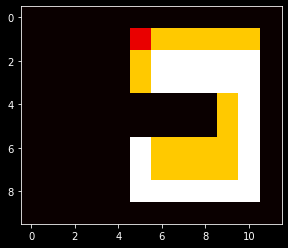

Sample trajectory on learned policy in episode 563:


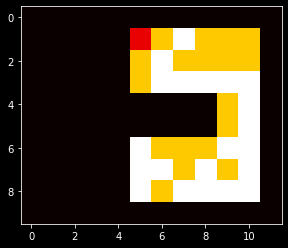

Sample trajectory on learned policy in episode 564:


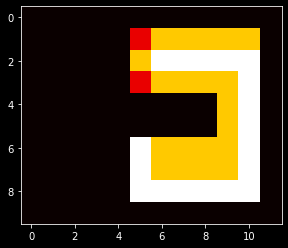

Sample trajectory on learned policy in episode 565:


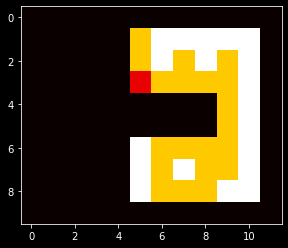

Sample trajectory on learned policy in episode 566:


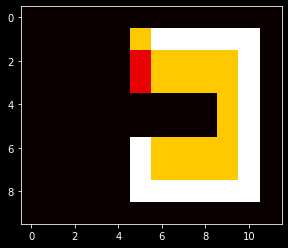



















episode:  57%|███████████████████████████████████████▋                              | 567/1000 [00:49<00:37, 11.45it/s]

Sample trajectory on learned policy in episode 567:


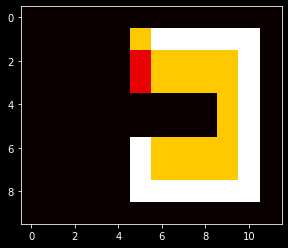

Sample trajectory on learned policy in episode 568:


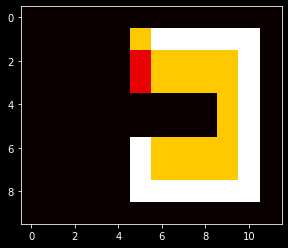

Sample trajectory on learned policy in episode 569:


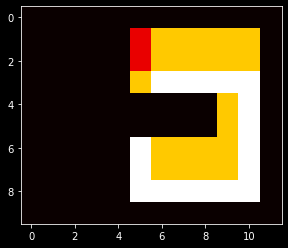

Sample trajectory on learned policy in episode 570:


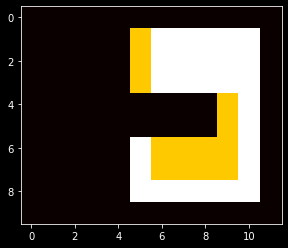

Sample trajectory on learned policy in episode 571:


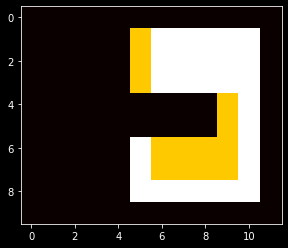

Sample trajectory on learned policy in episode 572:


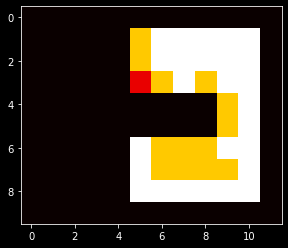

Sample trajectory on learned policy in episode 573:


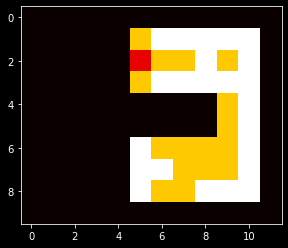

Sample trajectory on learned policy in episode 574:


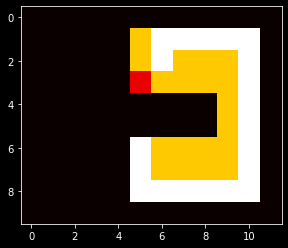

Sample trajectory on learned policy in episode 575:


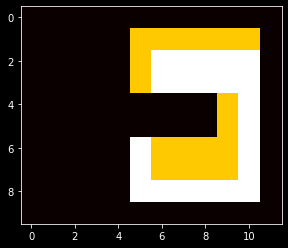

Sample trajectory on learned policy in episode 576:


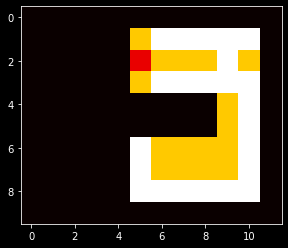

Sample trajectory on learned policy in episode 577:


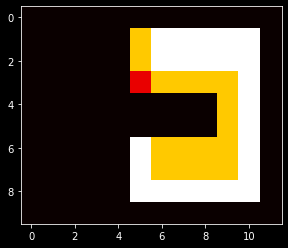

Sample trajectory on learned policy in episode 578:


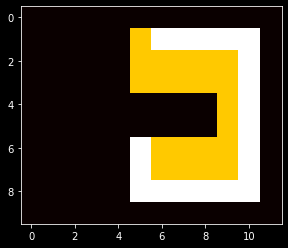

Sample trajectory on learned policy in episode 579:


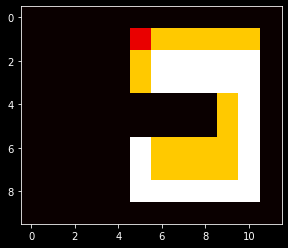

Sample trajectory on learned policy in episode 580:


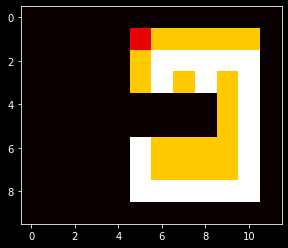

Sample trajectory on learned policy in episode 581:


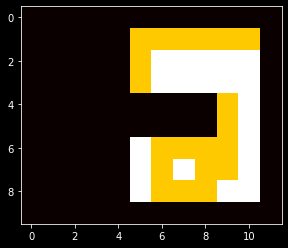

Sample trajectory on learned policy in episode 582:


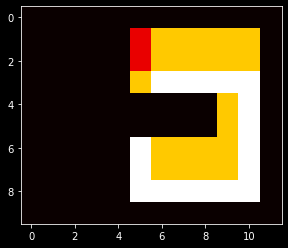

Sample trajectory on learned policy in episode 583:


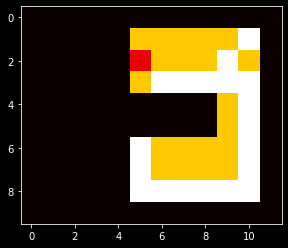

Sample trajectory on learned policy in episode 584:


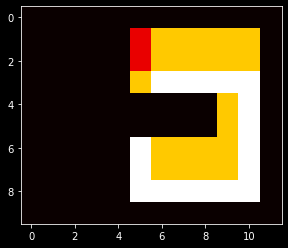

Sample trajectory on learned policy in episode 585:


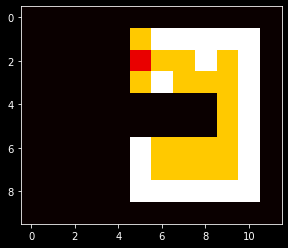

Sample trajectory on learned policy in episode 586:


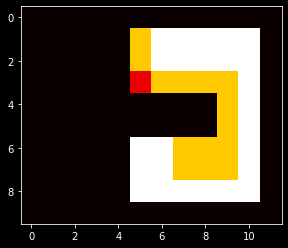

Sample trajectory on learned policy in episode 587:


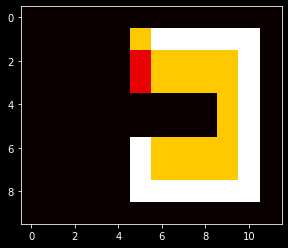

Sample trajectory on learned policy in episode 588:


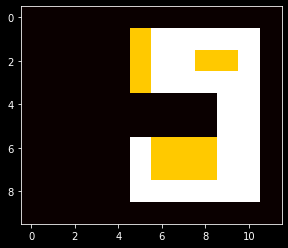

Sample trajectory on learned policy in episode 589:


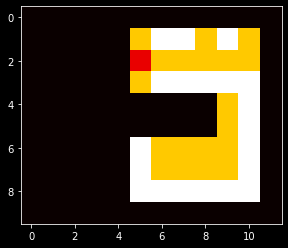

Sample trajectory on learned policy in episode 590:


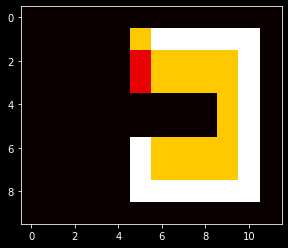



















episode:  59%|█████████████████████████████████████████▎                            | 591/1000 [00:51<00:35, 11.48it/s]

Sample trajectory on learned policy in episode 591:


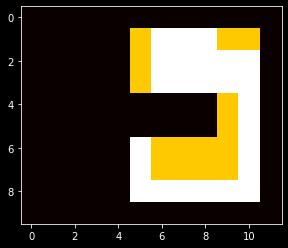

Sample trajectory on learned policy in episode 592:


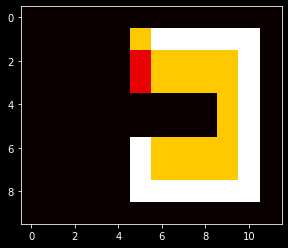

Sample trajectory on learned policy in episode 593:


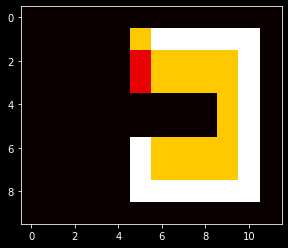

Sample trajectory on learned policy in episode 594:


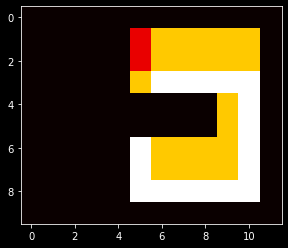

Sample trajectory on learned policy in episode 595:


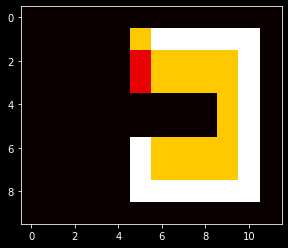

Sample trajectory on learned policy in episode 596:


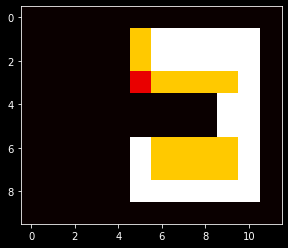

Sample trajectory on learned policy in episode 597:


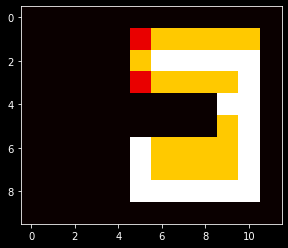

Sample trajectory on learned policy in episode 598:


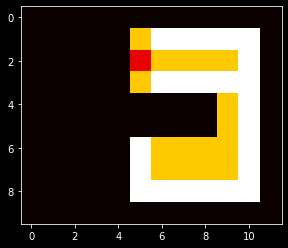

Sample trajectory on learned policy in episode 599:


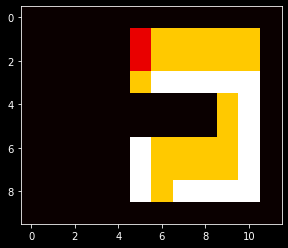

Sample trajectory on learned policy in episode 600:


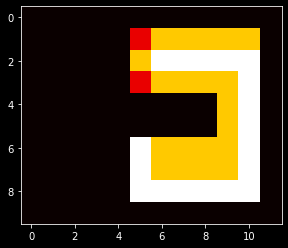

Sample trajectory on learned policy in episode 601:


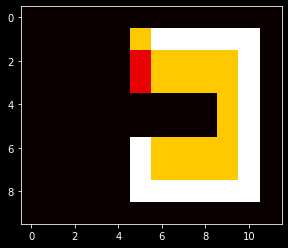

Sample trajectory on learned policy in episode 602:


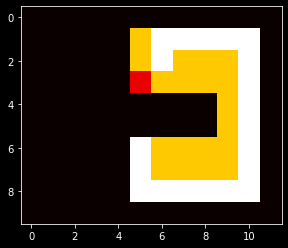

Sample trajectory on learned policy in episode 603:


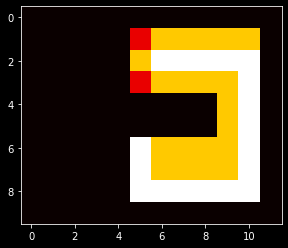

Sample trajectory on learned policy in episode 604:


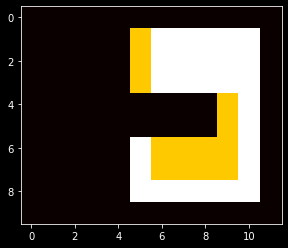

Sample trajectory on learned policy in episode 605:


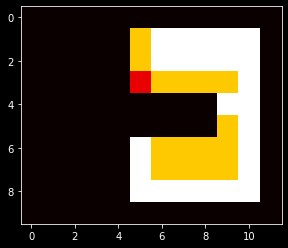

Sample trajectory on learned policy in episode 606:


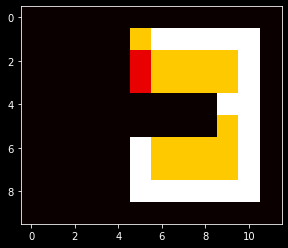

Sample trajectory on learned policy in episode 607:


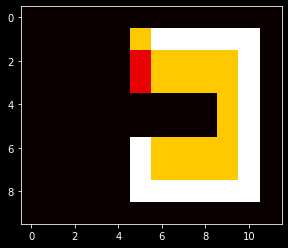

Sample trajectory on learned policy in episode 608:


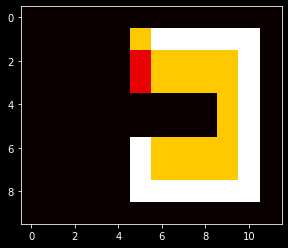

Sample trajectory on learned policy in episode 609:


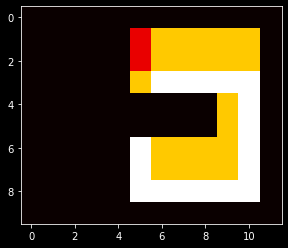

Sample trajectory on learned policy in episode 610:


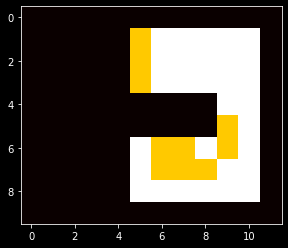

Sample trajectory on learned policy in episode 611:


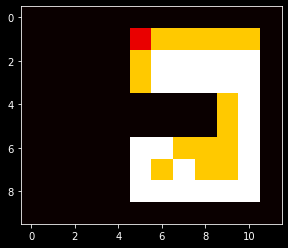

Sample trajectory on learned policy in episode 612:


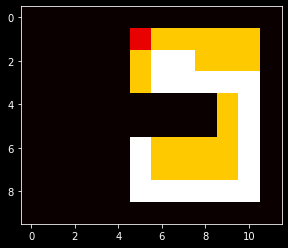

Sample trajectory on learned policy in episode 613:


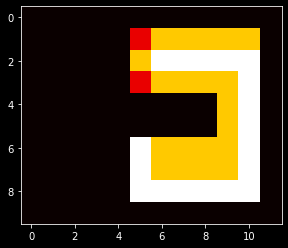

Sample trajectory on learned policy in episode 614:


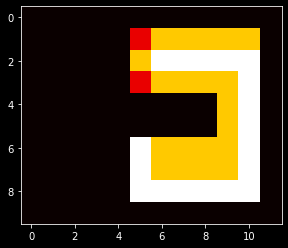



















episode:  62%|███████████████████████████████████████████                           | 615/1000 [00:53<00:33, 11.56it/s]

Sample trajectory on learned policy in episode 615:


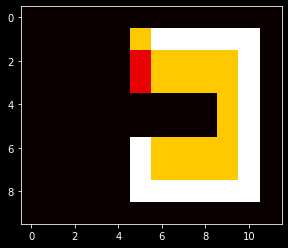

Sample trajectory on learned policy in episode 616:


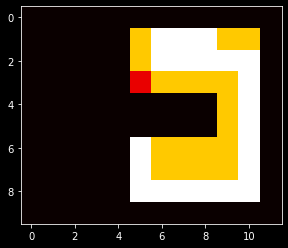

Sample trajectory on learned policy in episode 617:


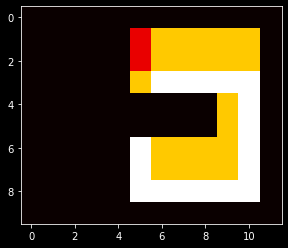

Sample trajectory on learned policy in episode 618:


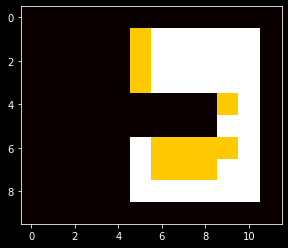

Sample trajectory on learned policy in episode 619:


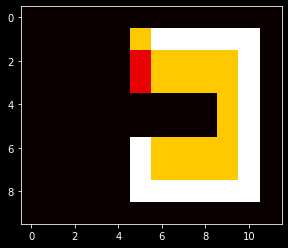

Sample trajectory on learned policy in episode 620:


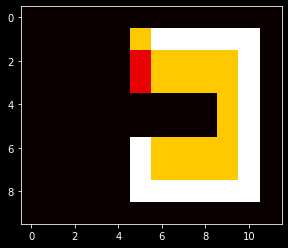

Sample trajectory on learned policy in episode 621:


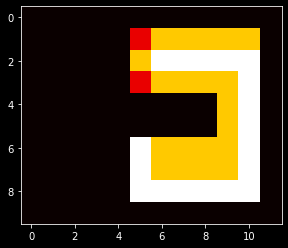

Sample trajectory on learned policy in episode 622:


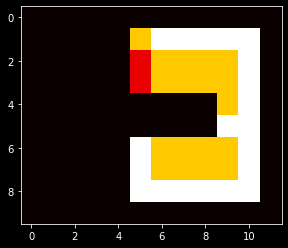

Sample trajectory on learned policy in episode 623:


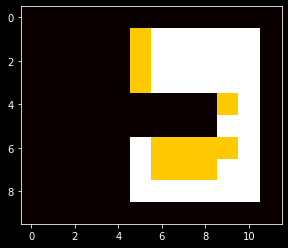

Sample trajectory on learned policy in episode 624:


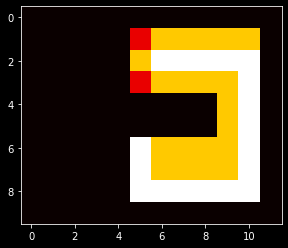

Sample trajectory on learned policy in episode 625:


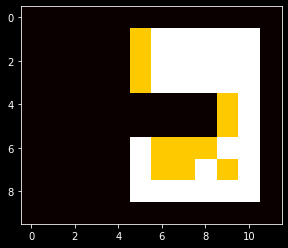

Sample trajectory on learned policy in episode 626:


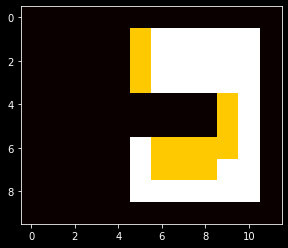

Sample trajectory on learned policy in episode 627:


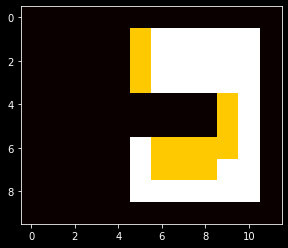

Sample trajectory on learned policy in episode 628:


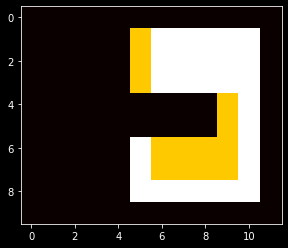

Sample trajectory on learned policy in episode 629:


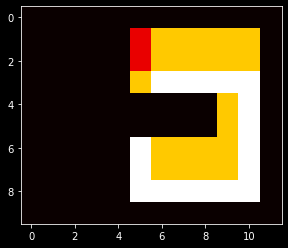

Sample trajectory on learned policy in episode 630:


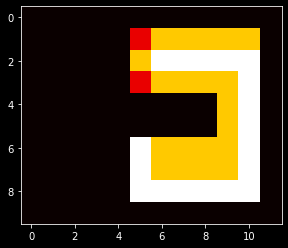

Sample trajectory on learned policy in episode 631:


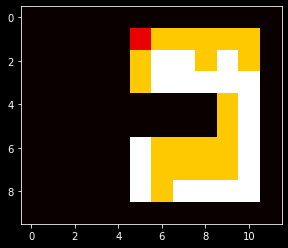

Sample trajectory on learned policy in episode 632:


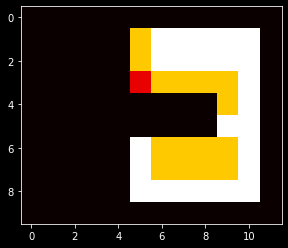

Sample trajectory on learned policy in episode 633:


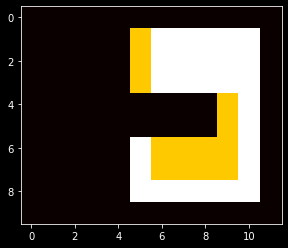

Sample trajectory on learned policy in episode 634:


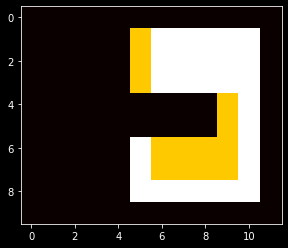

Sample trajectory on learned policy in episode 635:


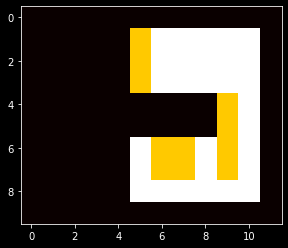

Sample trajectory on learned policy in episode 636:


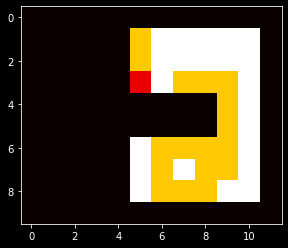

Sample trajectory on learned policy in episode 637:


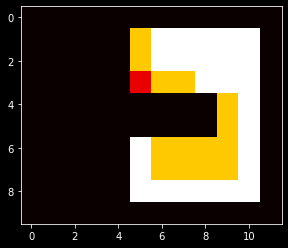

Sample trajectory on learned policy in episode 638:


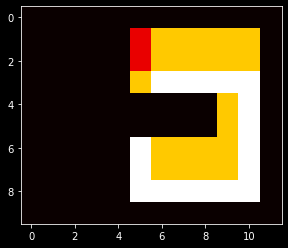



















episode:  64%|████████████████████████████████████████████▋                         | 639/1000 [00:55<00:31, 11.50it/s]

Sample trajectory on learned policy in episode 639:


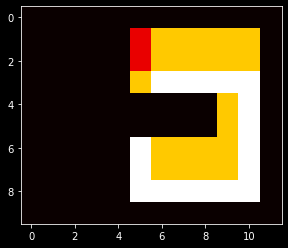

Sample trajectory on learned policy in episode 640:


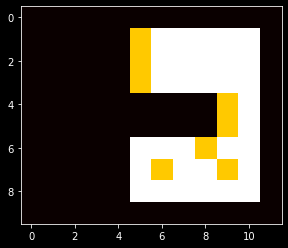

Sample trajectory on learned policy in episode 641:


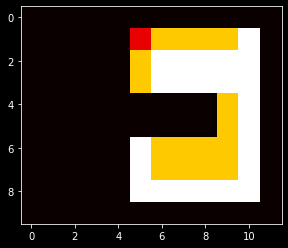

Sample trajectory on learned policy in episode 642:


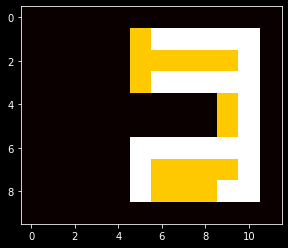

Sample trajectory on learned policy in episode 643:


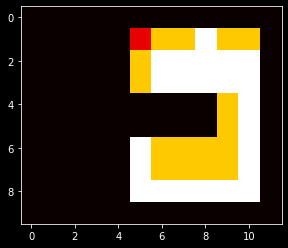

Sample trajectory on learned policy in episode 644:


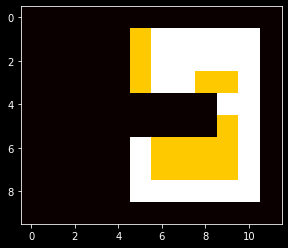

Sample trajectory on learned policy in episode 645:


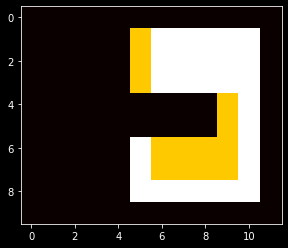

Sample trajectory on learned policy in episode 646:


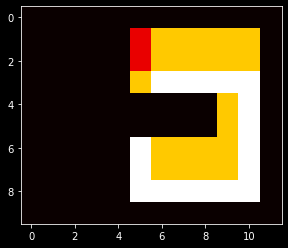

Sample trajectory on learned policy in episode 647:


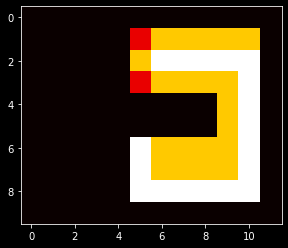

Sample trajectory on learned policy in episode 648:


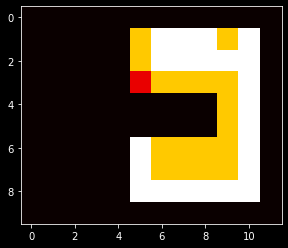

Sample trajectory on learned policy in episode 649:


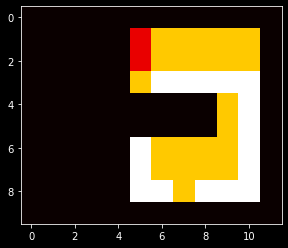

Sample trajectory on learned policy in episode 650:


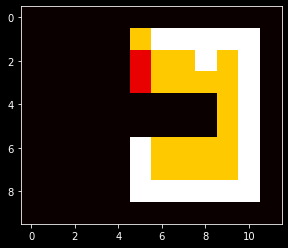

Sample trajectory on learned policy in episode 651:


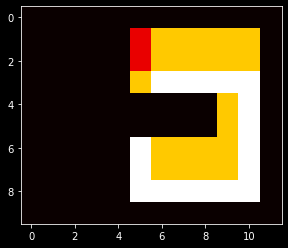

Sample trajectory on learned policy in episode 652:


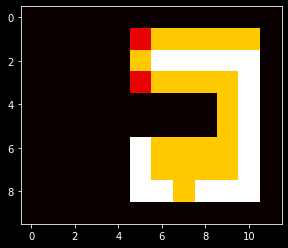

Sample trajectory on learned policy in episode 653:


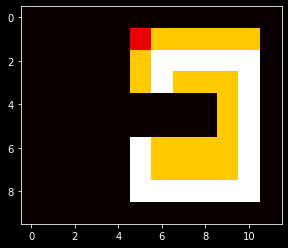

Sample trajectory on learned policy in episode 654:


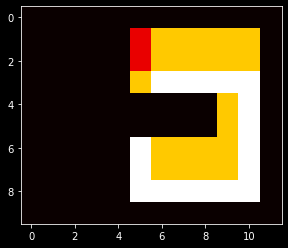

Sample trajectory on learned policy in episode 655:


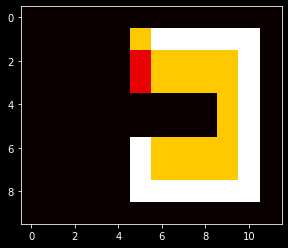

Sample trajectory on learned policy in episode 656:


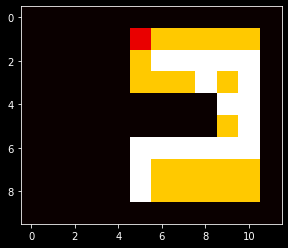

Sample trajectory on learned policy in episode 657:


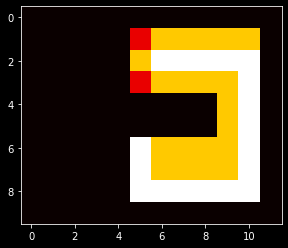

Sample trajectory on learned policy in episode 658:


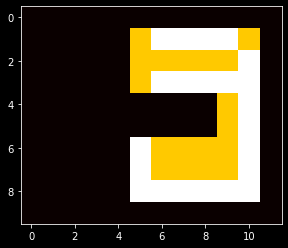

Sample trajectory on learned policy in episode 659:


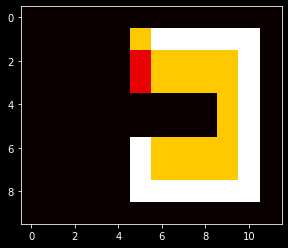

Sample trajectory on learned policy in episode 660:


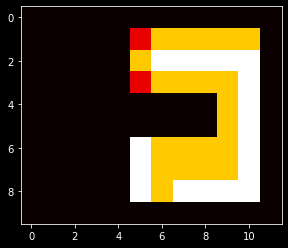

Sample trajectory on learned policy in episode 661:


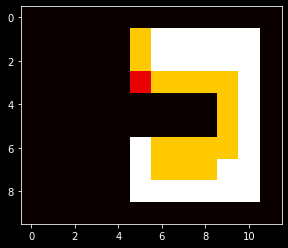

Sample trajectory on learned policy in episode 662:


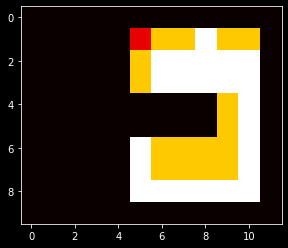



















episode:  66%|██████████████████████████████████████████████▍                       | 663/1000 [00:57<00:29, 11.54it/s]

Sample trajectory on learned policy in episode 663:


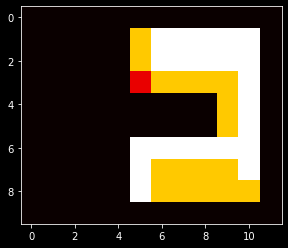

Sample trajectory on learned policy in episode 664:


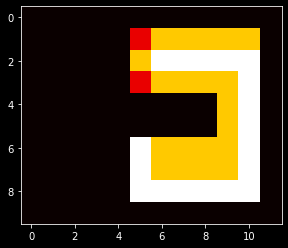

Sample trajectory on learned policy in episode 665:


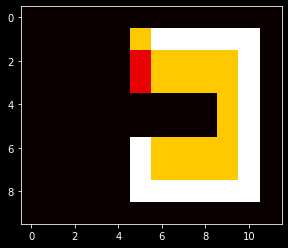

Sample trajectory on learned policy in episode 666:


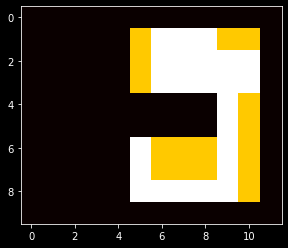

Sample trajectory on learned policy in episode 667:


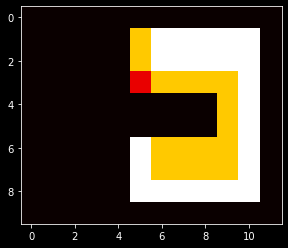

Sample trajectory on learned policy in episode 668:


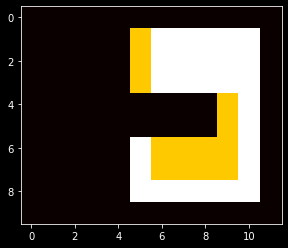

Sample trajectory on learned policy in episode 669:


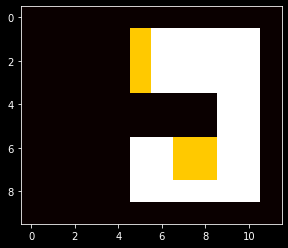

Sample trajectory on learned policy in episode 670:


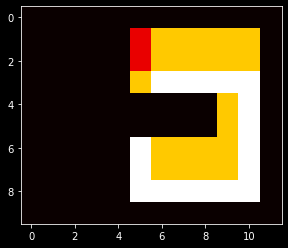

Sample trajectory on learned policy in episode 671:


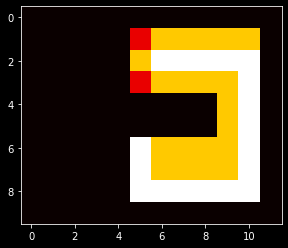

Sample trajectory on learned policy in episode 672:


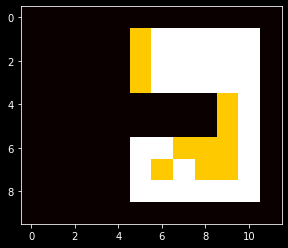

Sample trajectory on learned policy in episode 673:


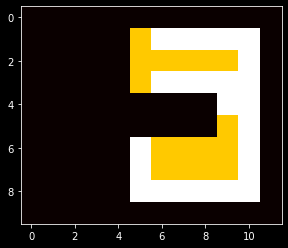

Sample trajectory on learned policy in episode 674:


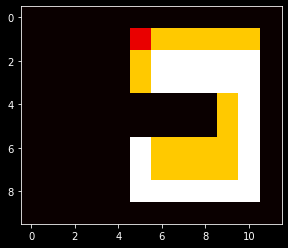

Sample trajectory on learned policy in episode 675:


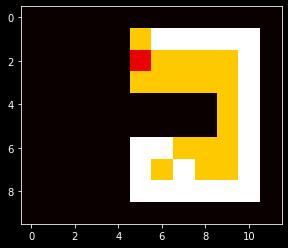

Sample trajectory on learned policy in episode 676:


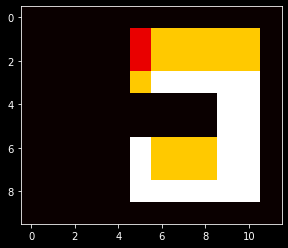

Sample trajectory on learned policy in episode 677:


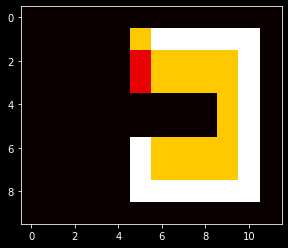

Sample trajectory on learned policy in episode 678:


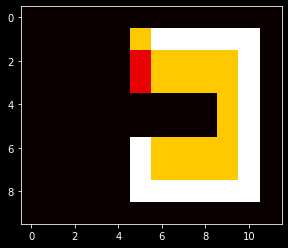

Sample trajectory on learned policy in episode 679:


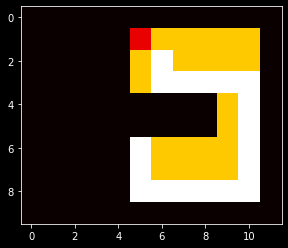

Sample trajectory on learned policy in episode 680:


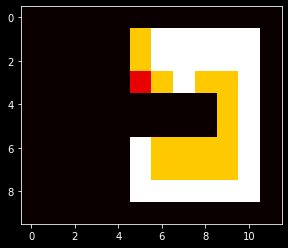

Sample trajectory on learned policy in episode 681:


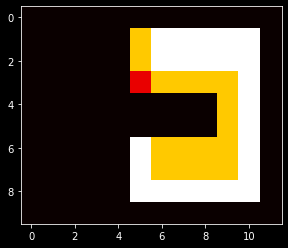

Sample trajectory on learned policy in episode 682:


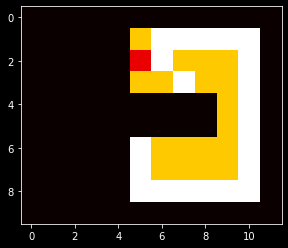

Sample trajectory on learned policy in episode 683:


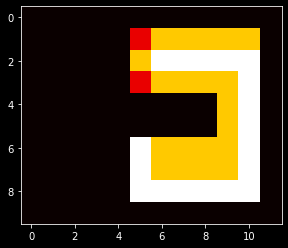

Sample trajectory on learned policy in episode 684:


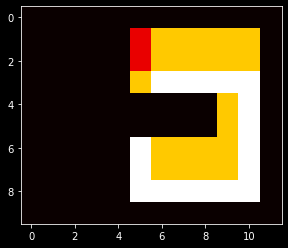

Sample trajectory on learned policy in episode 685:


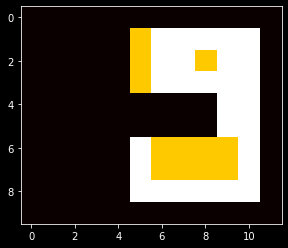

Sample trajectory on learned policy in episode 686:


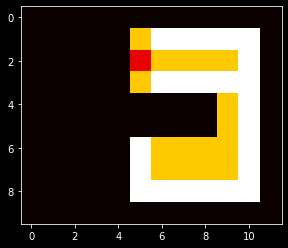



















episode:  69%|████████████████████████████████████████████████                      | 687/1000 [00:59<00:27, 11.58it/s]

Sample trajectory on learned policy in episode 687:


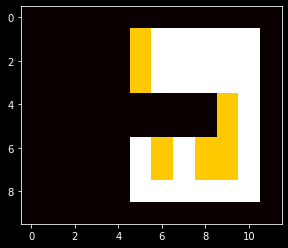

Sample trajectory on learned policy in episode 688:


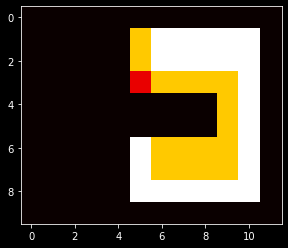

Sample trajectory on learned policy in episode 689:


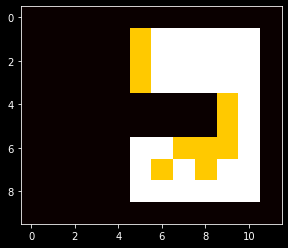

Sample trajectory on learned policy in episode 690:


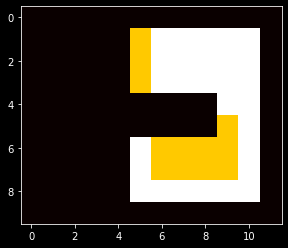

Sample trajectory on learned policy in episode 691:


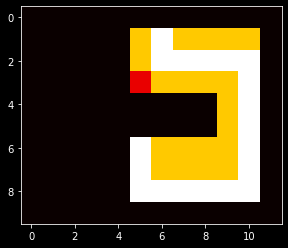

Sample trajectory on learned policy in episode 692:


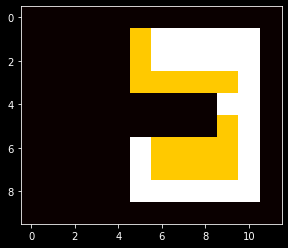

Sample trajectory on learned policy in episode 693:


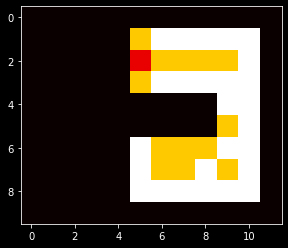

Sample trajectory on learned policy in episode 694:


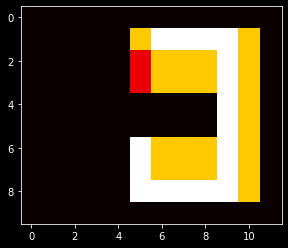

Sample trajectory on learned policy in episode 695:


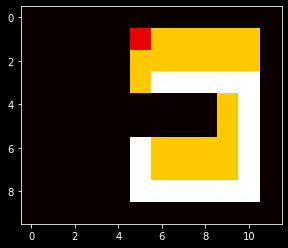

Sample trajectory on learned policy in episode 696:


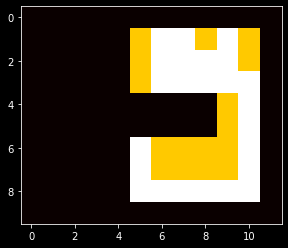

Sample trajectory on learned policy in episode 697:


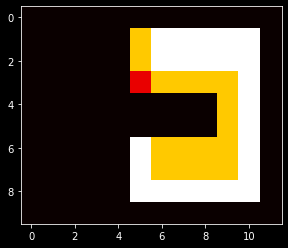

Sample trajectory on learned policy in episode 698:


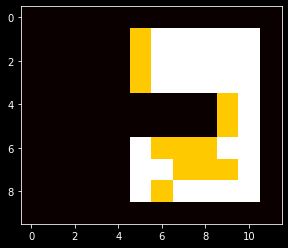

Sample trajectory on learned policy in episode 699:


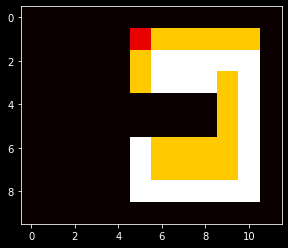

Sample trajectory on learned policy in episode 700:


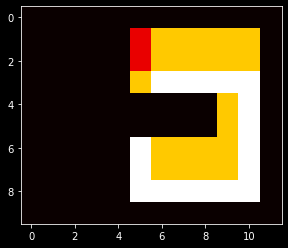

Sample trajectory on learned policy in episode 701:


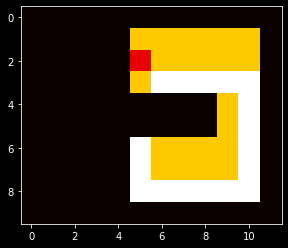

Sample trajectory on learned policy in episode 702:


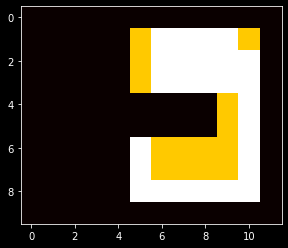

Sample trajectory on learned policy in episode 703:


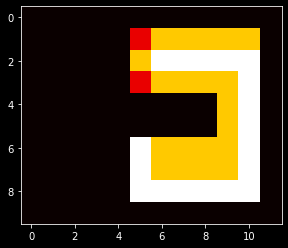

Sample trajectory on learned policy in episode 704:


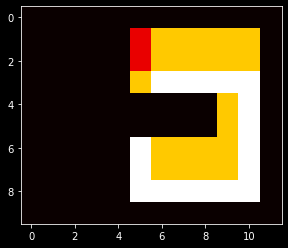

Sample trajectory on learned policy in episode 705:


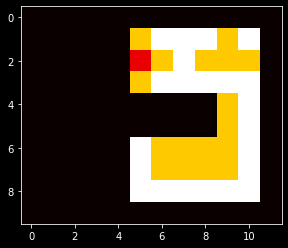

Sample trajectory on learned policy in episode 706:


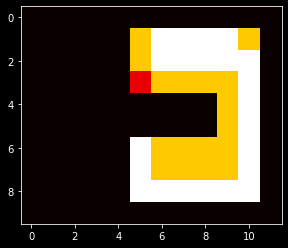

Sample trajectory on learned policy in episode 707:


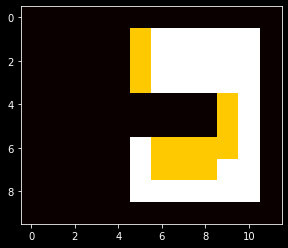

Sample trajectory on learned policy in episode 708:


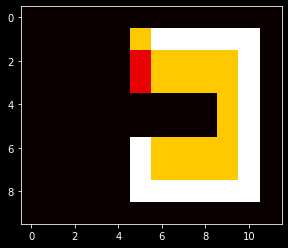

Sample trajectory on learned policy in episode 709:


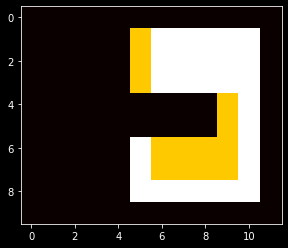

Sample trajectory on learned policy in episode 710:


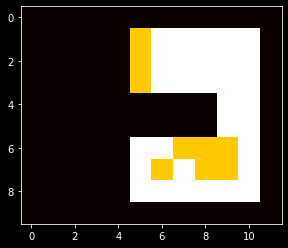



















episode:  71%|█████████████████████████████████████████████████▊                    | 711/1000 [01:01<00:25, 11.53it/s]

Sample trajectory on learned policy in episode 711:


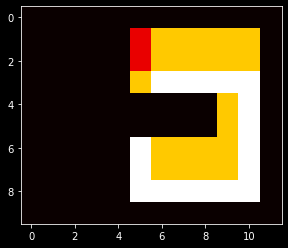

Sample trajectory on learned policy in episode 712:


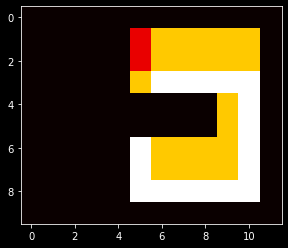

Sample trajectory on learned policy in episode 713:


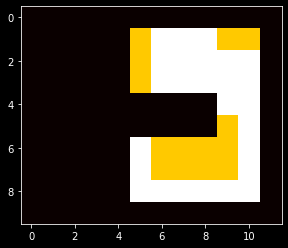

Sample trajectory on learned policy in episode 714:


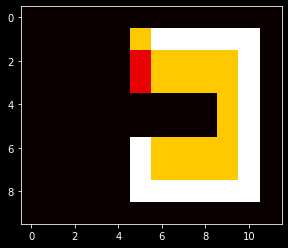

Sample trajectory on learned policy in episode 715:


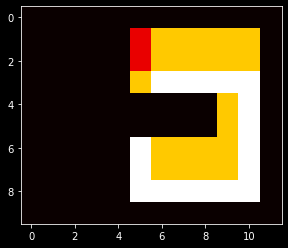

Sample trajectory on learned policy in episode 716:


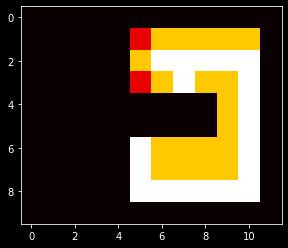

Sample trajectory on learned policy in episode 717:


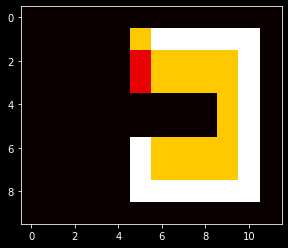

Sample trajectory on learned policy in episode 718:


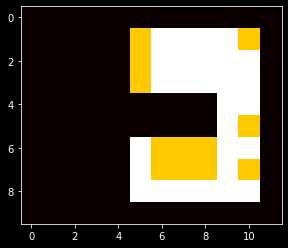

Sample trajectory on learned policy in episode 719:


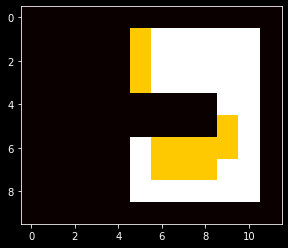

Sample trajectory on learned policy in episode 720:


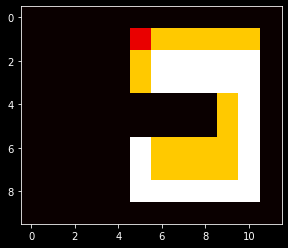

Sample trajectory on learned policy in episode 721:


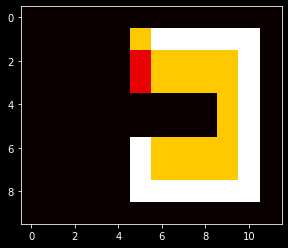

Sample trajectory on learned policy in episode 722:


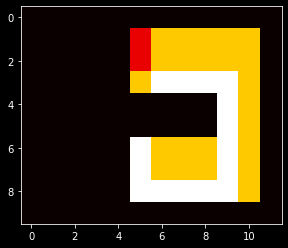

Sample trajectory on learned policy in episode 723:


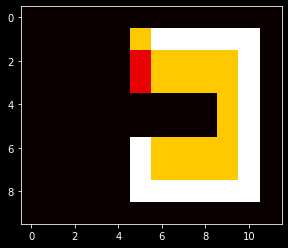

Sample trajectory on learned policy in episode 724:


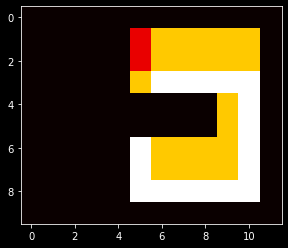

Sample trajectory on learned policy in episode 725:


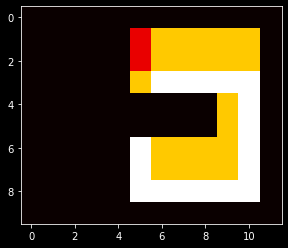

Sample trajectory on learned policy in episode 726:


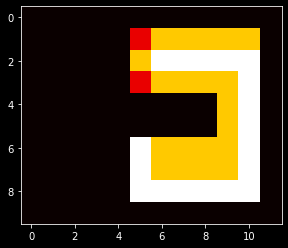

Sample trajectory on learned policy in episode 727:


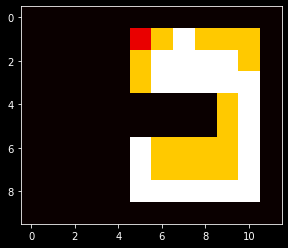

Sample trajectory on learned policy in episode 728:


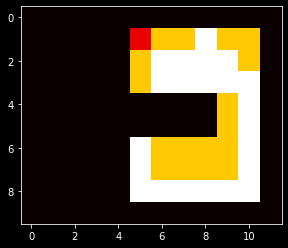

Sample trajectory on learned policy in episode 729:


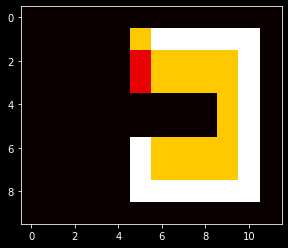

Sample trajectory on learned policy in episode 730:


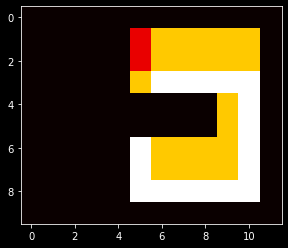

Sample trajectory on learned policy in episode 731:


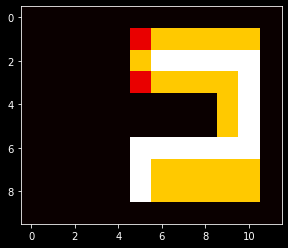

Sample trajectory on learned policy in episode 732:


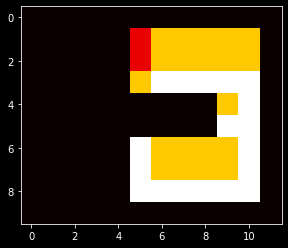

Sample trajectory on learned policy in episode 733:


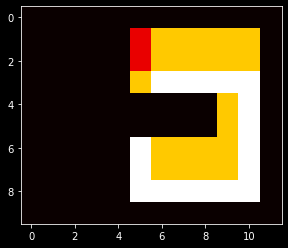

Sample trajectory on learned policy in episode 734:


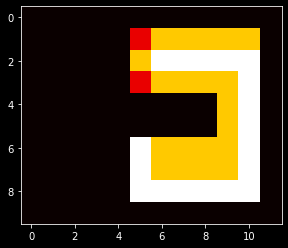



















episode:  74%|███████████████████████████████████████████████████▍                  | 735/1000 [01:03<00:22, 11.63it/s]

Sample trajectory on learned policy in episode 735:


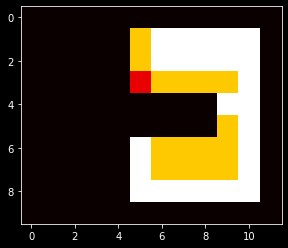

Sample trajectory on learned policy in episode 736:


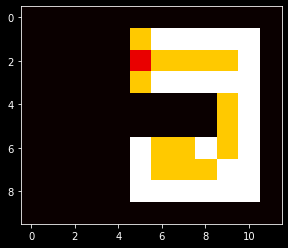

Sample trajectory on learned policy in episode 737:


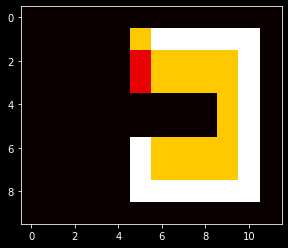

Sample trajectory on learned policy in episode 738:


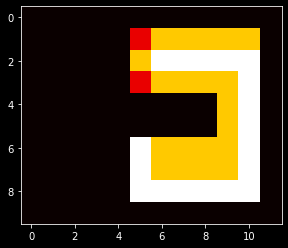

Sample trajectory on learned policy in episode 739:


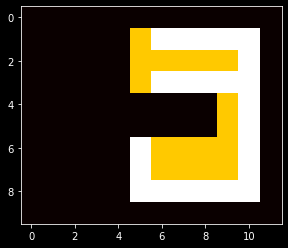

Sample trajectory on learned policy in episode 740:


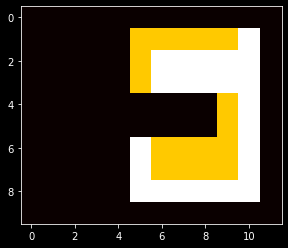

Sample trajectory on learned policy in episode 741:


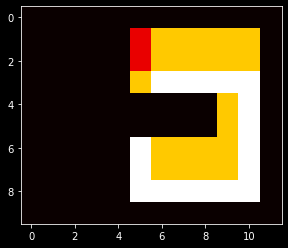

Sample trajectory on learned policy in episode 742:


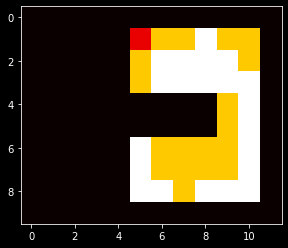

Sample trajectory on learned policy in episode 743:


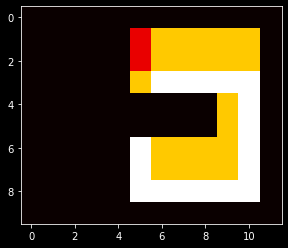

Sample trajectory on learned policy in episode 744:


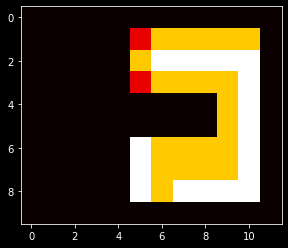

Sample trajectory on learned policy in episode 745:


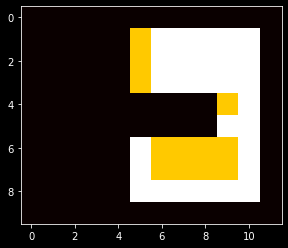

Sample trajectory on learned policy in episode 746:


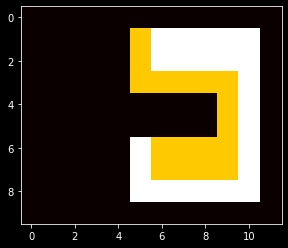

Sample trajectory on learned policy in episode 747:


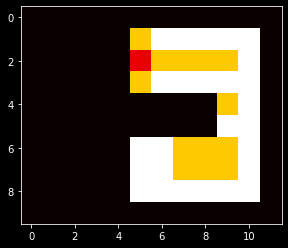

Sample trajectory on learned policy in episode 748:


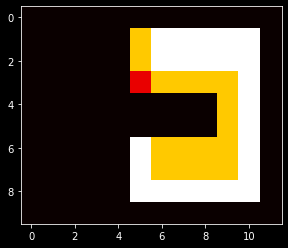

Sample trajectory on learned policy in episode 749:


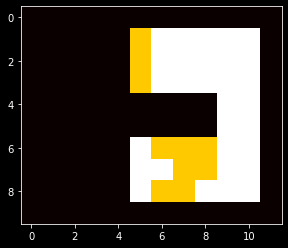

Sample trajectory on learned policy in episode 750:


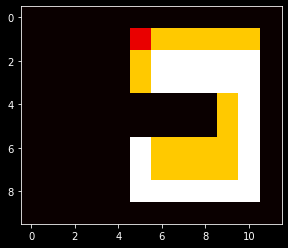

Sample trajectory on learned policy in episode 751:


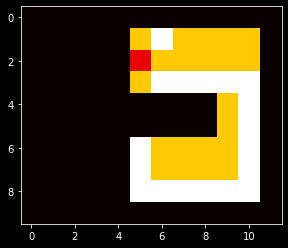

Sample trajectory on learned policy in episode 752:


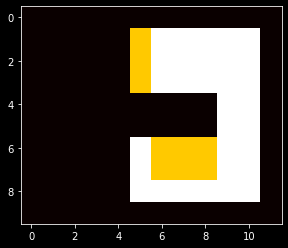

Sample trajectory on learned policy in episode 753:


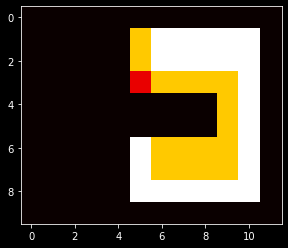

Sample trajectory on learned policy in episode 754:


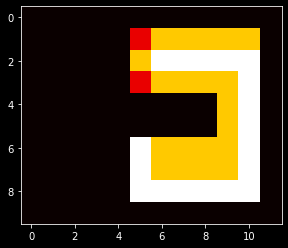

Sample trajectory on learned policy in episode 755:


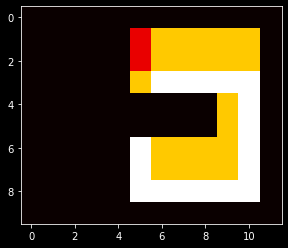

Sample trajectory on learned policy in episode 756:


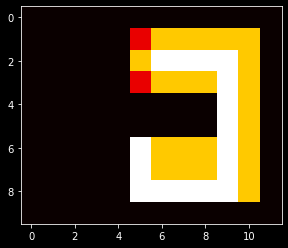

Sample trajectory on learned policy in episode 757:


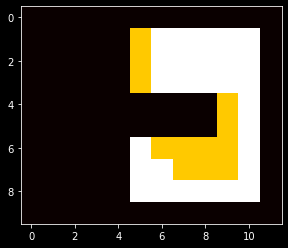

Sample trajectory on learned policy in episode 758:


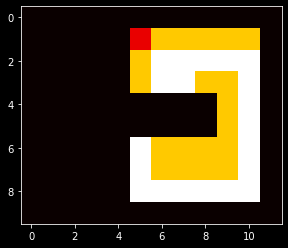



















episode:  76%|█████████████████████████████████████████████████████▏                | 759/1000 [01:06<00:20, 11.59it/s]

Sample trajectory on learned policy in episode 759:


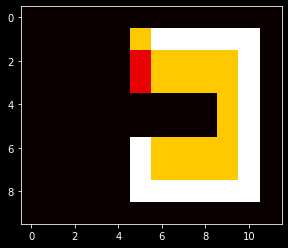

Sample trajectory on learned policy in episode 760:


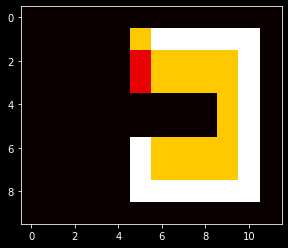

Sample trajectory on learned policy in episode 761:


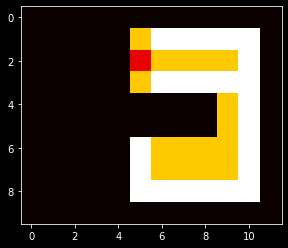

Sample trajectory on learned policy in episode 762:


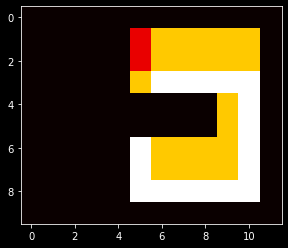

Sample trajectory on learned policy in episode 763:


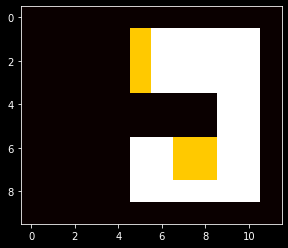

Sample trajectory on learned policy in episode 764:


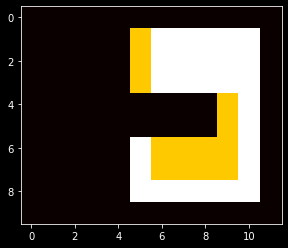

Sample trajectory on learned policy in episode 765:


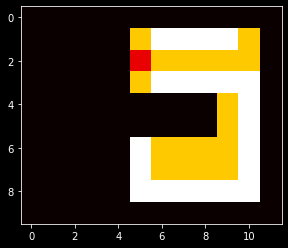

Sample trajectory on learned policy in episode 766:


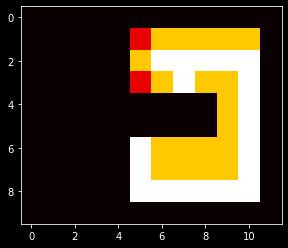

Sample trajectory on learned policy in episode 767:


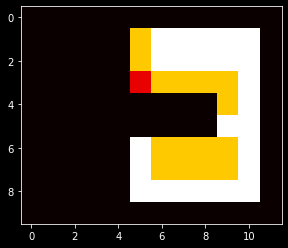

Sample trajectory on learned policy in episode 768:


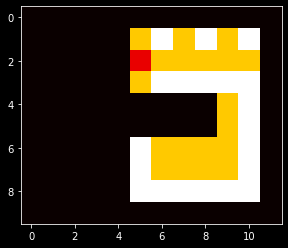

Sample trajectory on learned policy in episode 769:


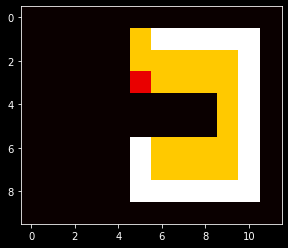

Sample trajectory on learned policy in episode 770:


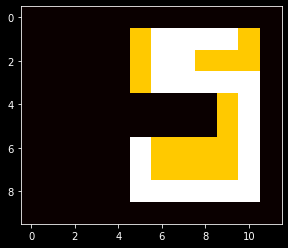

Sample trajectory on learned policy in episode 771:


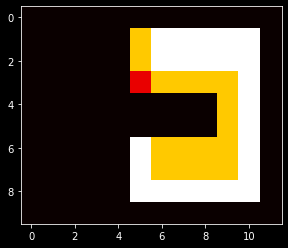

Sample trajectory on learned policy in episode 772:


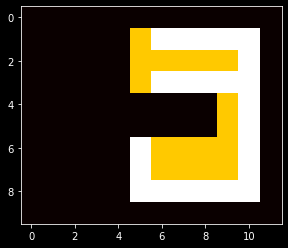

Sample trajectory on learned policy in episode 773:


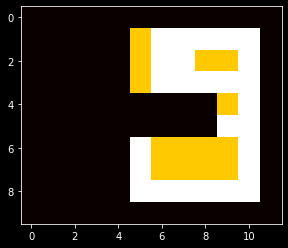

Sample trajectory on learned policy in episode 774:


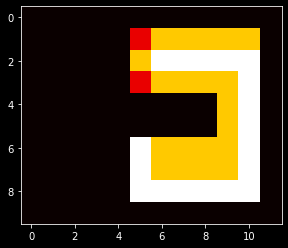

Sample trajectory on learned policy in episode 775:


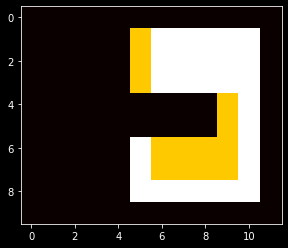

Sample trajectory on learned policy in episode 776:


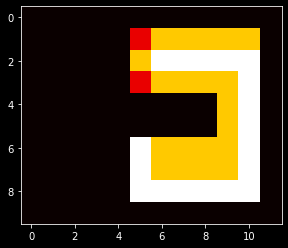

Sample trajectory on learned policy in episode 777:


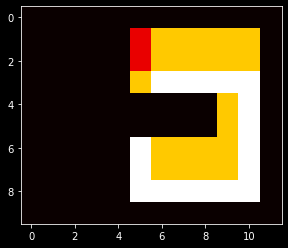

Sample trajectory on learned policy in episode 778:


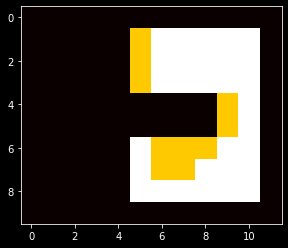

Sample trajectory on learned policy in episode 779:


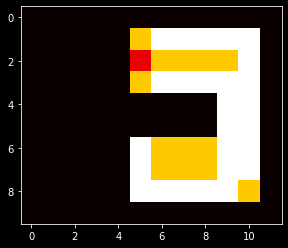

Sample trajectory on learned policy in episode 780:


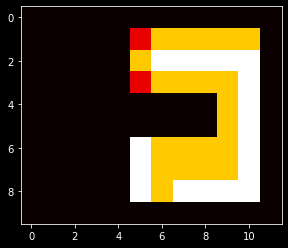

Sample trajectory on learned policy in episode 781:


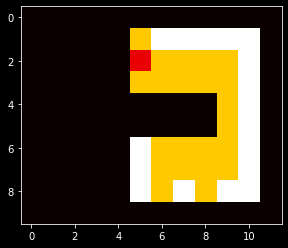

Sample trajectory on learned policy in episode 782:


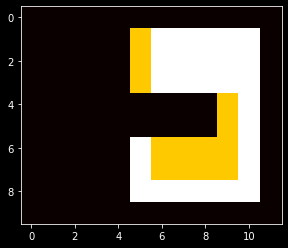



















episode:  78%|██████████████████████████████████████████████████████▊               | 783/1000 [01:08<00:18, 11.60it/s]

Sample trajectory on learned policy in episode 783:


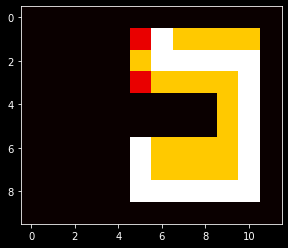

Sample trajectory on learned policy in episode 784:


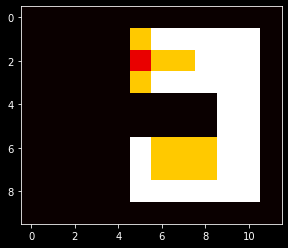

Sample trajectory on learned policy in episode 785:


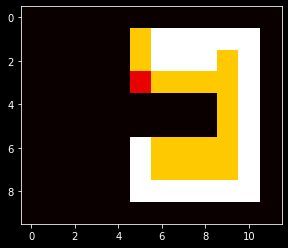

Sample trajectory on learned policy in episode 786:


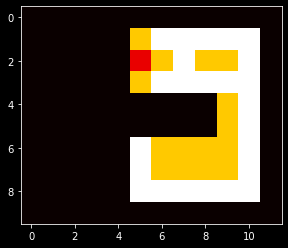

Sample trajectory on learned policy in episode 787:


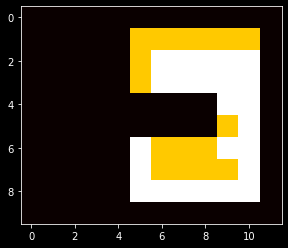

Sample trajectory on learned policy in episode 788:


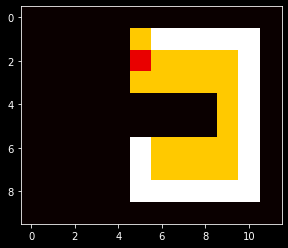

Sample trajectory on learned policy in episode 789:


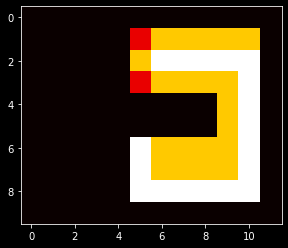

Sample trajectory on learned policy in episode 790:


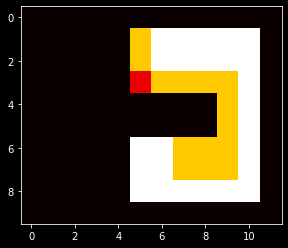

Sample trajectory on learned policy in episode 791:


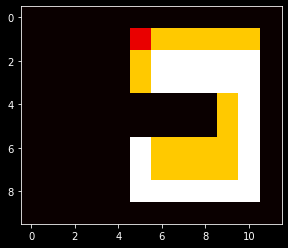

Sample trajectory on learned policy in episode 792:


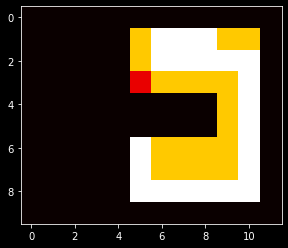

Sample trajectory on learned policy in episode 793:


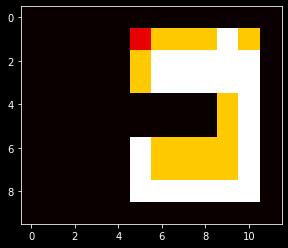

Sample trajectory on learned policy in episode 794:


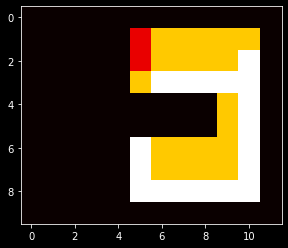

Sample trajectory on learned policy in episode 795:


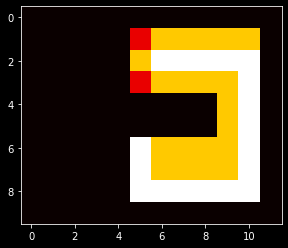

Sample trajectory on learned policy in episode 796:


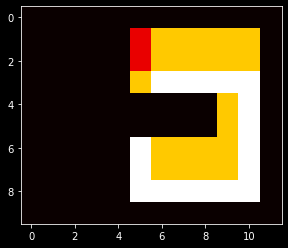

Sample trajectory on learned policy in episode 797:


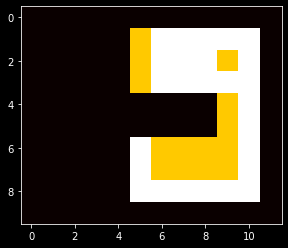

Sample trajectory on learned policy in episode 798:


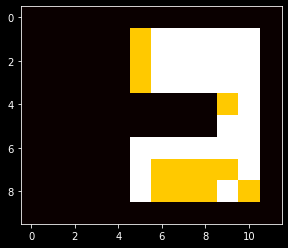

Sample trajectory on learned policy in episode 799:


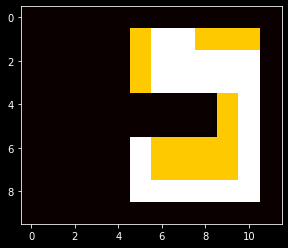

Sample trajectory on learned policy in episode 800:


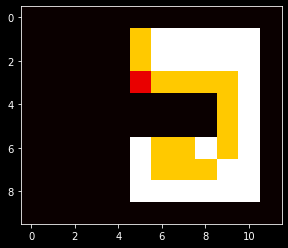

Sample trajectory on learned policy in episode 801:


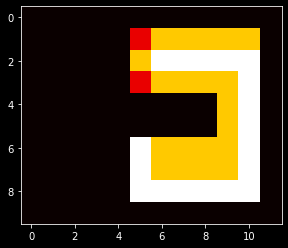

Sample trajectory on learned policy in episode 802:


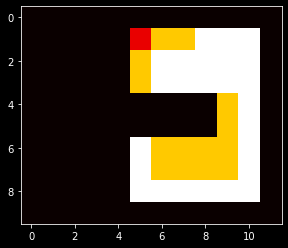

Sample trajectory on learned policy in episode 803:


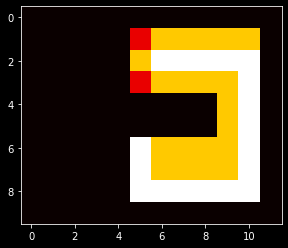

Sample trajectory on learned policy in episode 804:


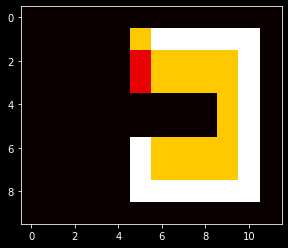

Sample trajectory on learned policy in episode 805:


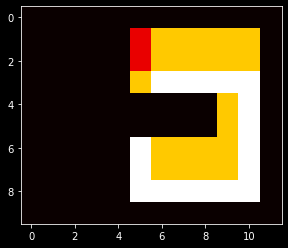

Sample trajectory on learned policy in episode 806:


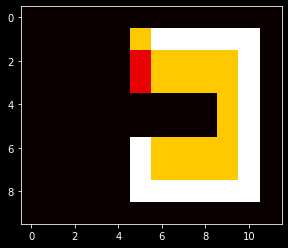



















episode:  81%|████████████████████████████████████████████████████████▍             | 807/1000 [01:10<00:16, 11.59it/s]

Sample trajectory on learned policy in episode 807:


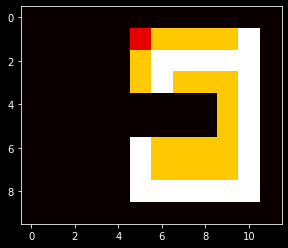

Sample trajectory on learned policy in episode 808:


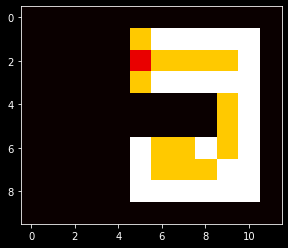

Sample trajectory on learned policy in episode 809:


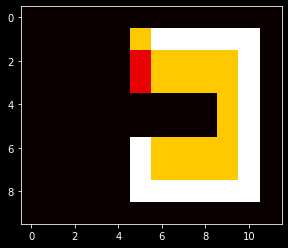

Sample trajectory on learned policy in episode 810:


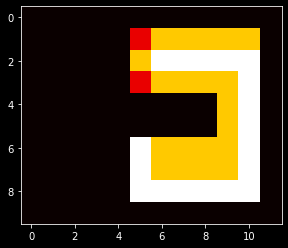

Sample trajectory on learned policy in episode 811:


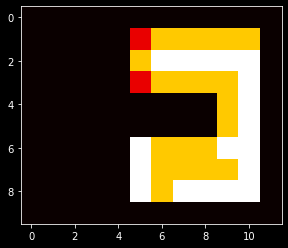

Sample trajectory on learned policy in episode 812:


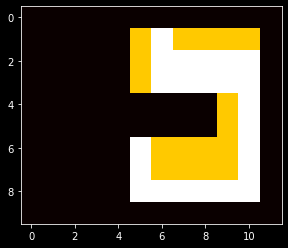

Sample trajectory on learned policy in episode 813:


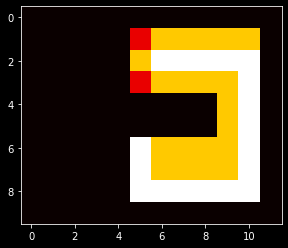

Sample trajectory on learned policy in episode 814:


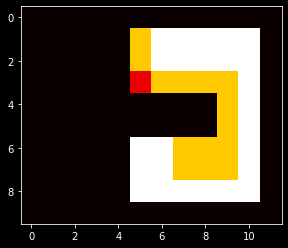

Sample trajectory on learned policy in episode 815:


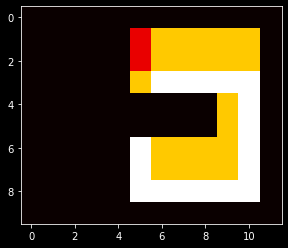

Sample trajectory on learned policy in episode 816:


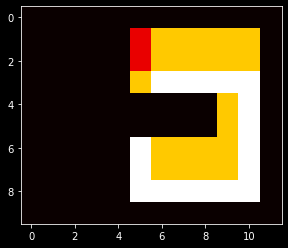

Sample trajectory on learned policy in episode 817:


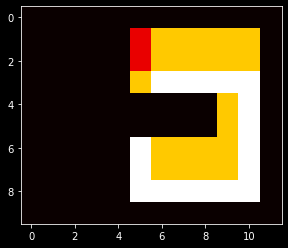

Sample trajectory on learned policy in episode 818:


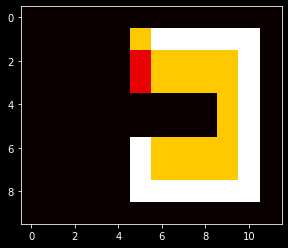

Sample trajectory on learned policy in episode 819:


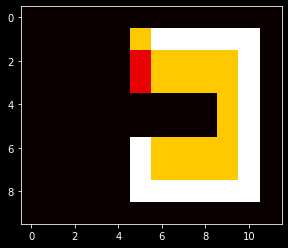

Sample trajectory on learned policy in episode 820:


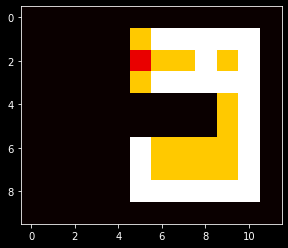

Sample trajectory on learned policy in episode 821:


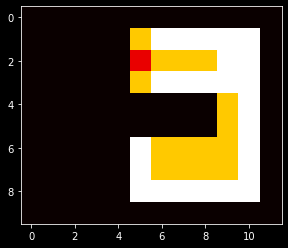

Sample trajectory on learned policy in episode 822:


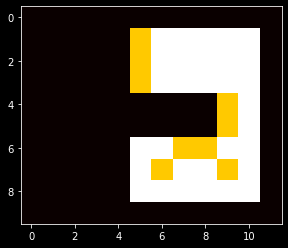

Sample trajectory on learned policy in episode 823:


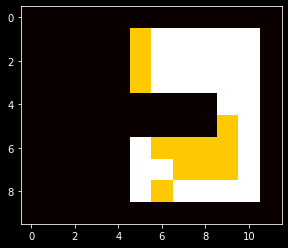

Sample trajectory on learned policy in episode 824:


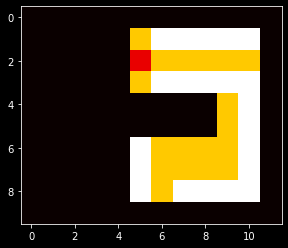

Sample trajectory on learned policy in episode 825:


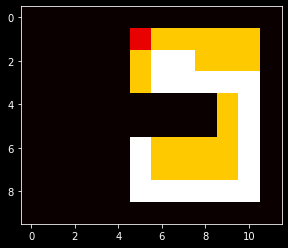

Sample trajectory on learned policy in episode 826:


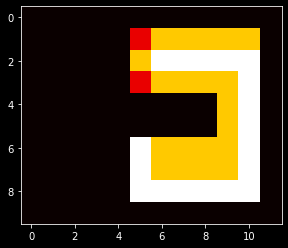

Sample trajectory on learned policy in episode 827:


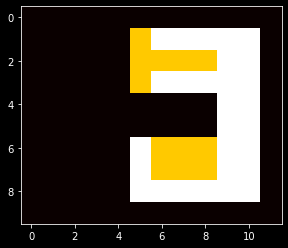

Sample trajectory on learned policy in episode 828:


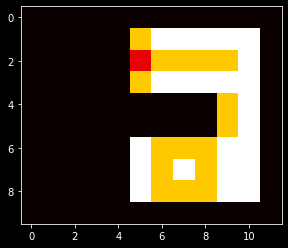

Sample trajectory on learned policy in episode 829:


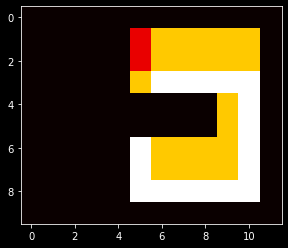

Sample trajectory on learned policy in episode 830:


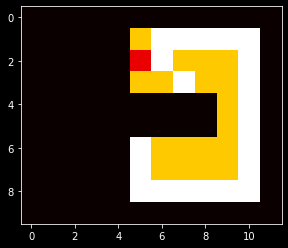



















episode:  83%|██████████████████████████████████████████████████████████▏           | 831/1000 [01:12<00:14, 11.55it/s]

Sample trajectory on learned policy in episode 831:


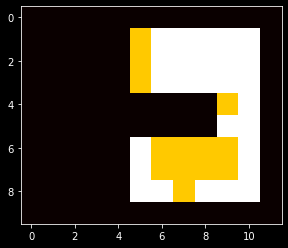

Sample trajectory on learned policy in episode 832:


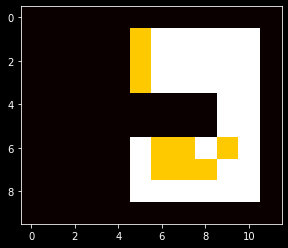

Sample trajectory on learned policy in episode 833:


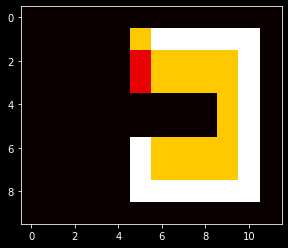

Sample trajectory on learned policy in episode 834:


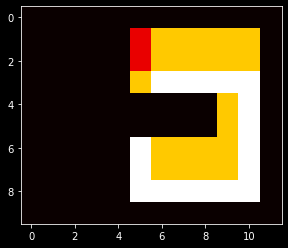

Sample trajectory on learned policy in episode 835:


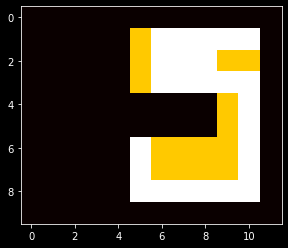

Sample trajectory on learned policy in episode 836:


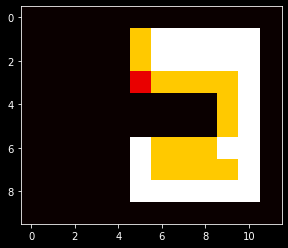

Sample trajectory on learned policy in episode 837:


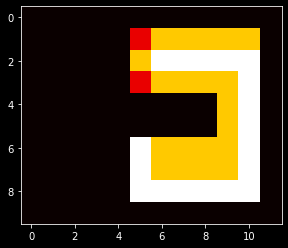

Sample trajectory on learned policy in episode 838:


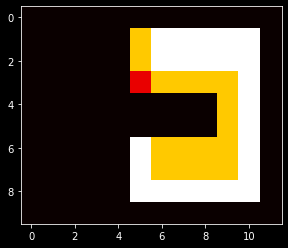

Sample trajectory on learned policy in episode 839:


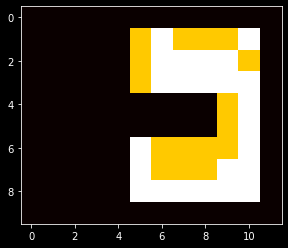

Sample trajectory on learned policy in episode 840:


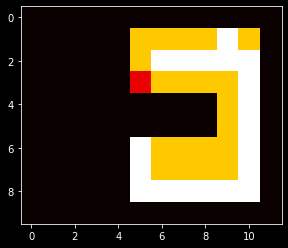

Sample trajectory on learned policy in episode 841:


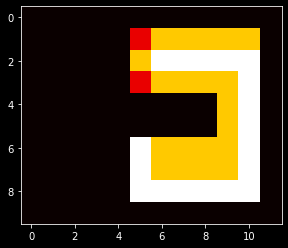

Sample trajectory on learned policy in episode 842:


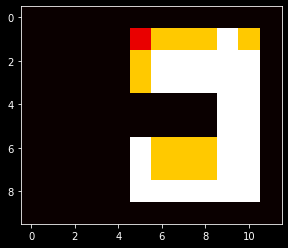

Sample trajectory on learned policy in episode 843:


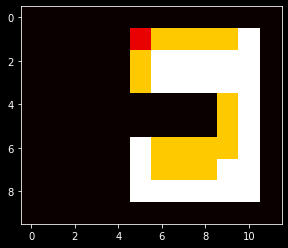

Sample trajectory on learned policy in episode 844:


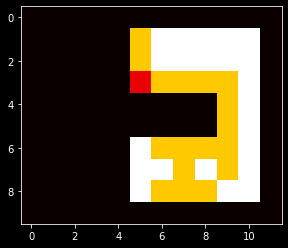

Sample trajectory on learned policy in episode 845:


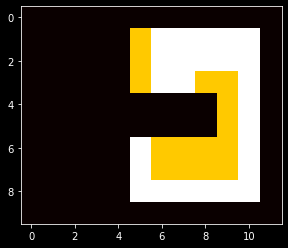

Sample trajectory on learned policy in episode 846:


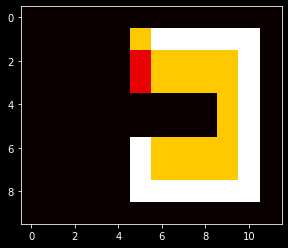

Sample trajectory on learned policy in episode 847:


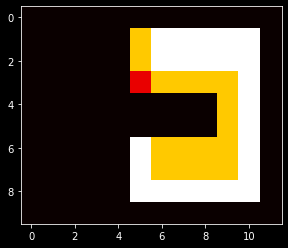

Sample trajectory on learned policy in episode 848:


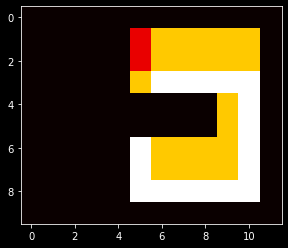

Sample trajectory on learned policy in episode 849:


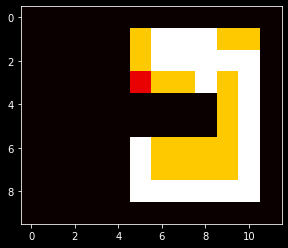

Sample trajectory on learned policy in episode 850:


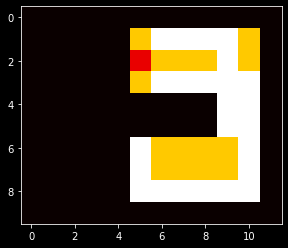

Sample trajectory on learned policy in episode 851:


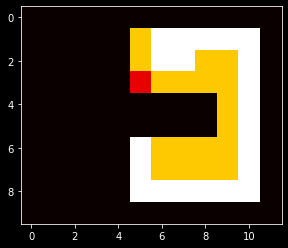

Sample trajectory on learned policy in episode 852:


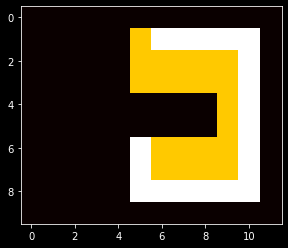

Sample trajectory on learned policy in episode 853:


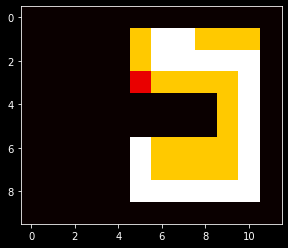

Sample trajectory on learned policy in episode 854:


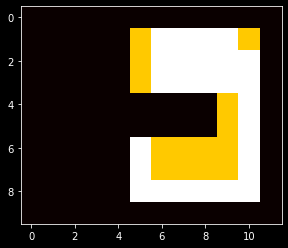



















episode:  86%|███████████████████████████████████████████████████████████▊          | 855/1000 [01:14<00:12, 11.56it/s]

Sample trajectory on learned policy in episode 855:


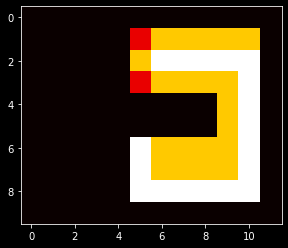

Sample trajectory on learned policy in episode 856:


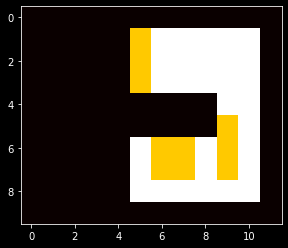

Sample trajectory on learned policy in episode 857:


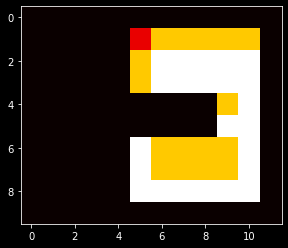

Sample trajectory on learned policy in episode 858:


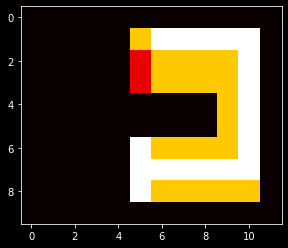

Sample trajectory on learned policy in episode 859:


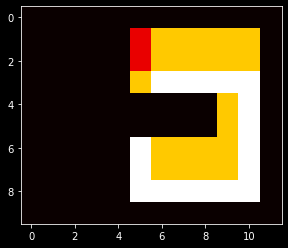

Sample trajectory on learned policy in episode 860:


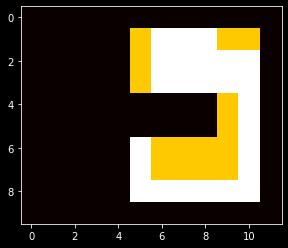

Sample trajectory on learned policy in episode 861:


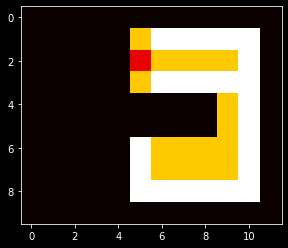

Sample trajectory on learned policy in episode 862:


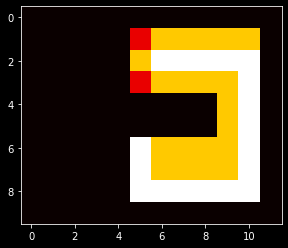

Sample trajectory on learned policy in episode 863:


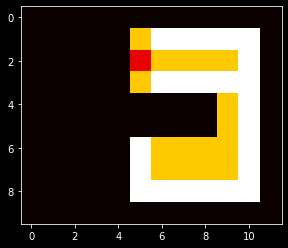

Sample trajectory on learned policy in episode 864:


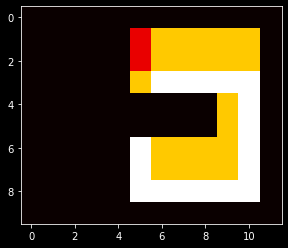

Sample trajectory on learned policy in episode 865:


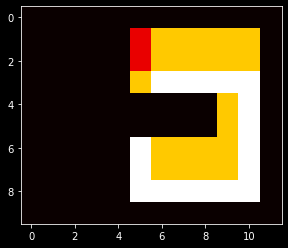

Sample trajectory on learned policy in episode 866:


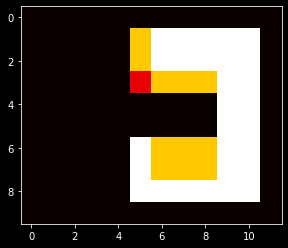

Sample trajectory on learned policy in episode 867:


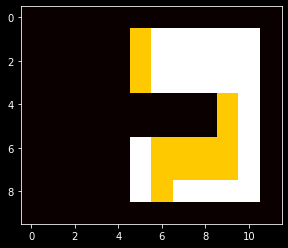

Sample trajectory on learned policy in episode 868:


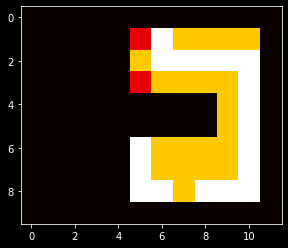

Sample trajectory on learned policy in episode 869:


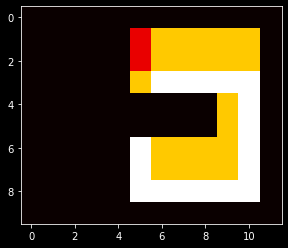

Sample trajectory on learned policy in episode 870:


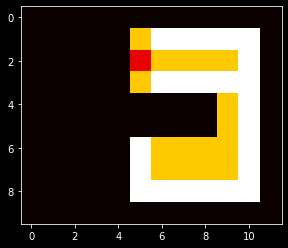

Sample trajectory on learned policy in episode 871:


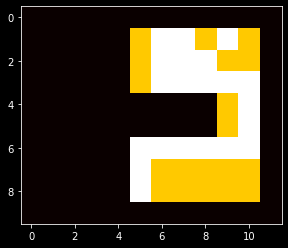

Sample trajectory on learned policy in episode 872:


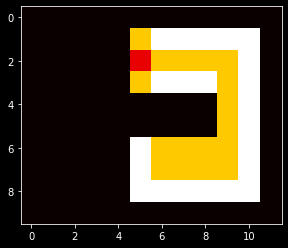

Sample trajectory on learned policy in episode 873:


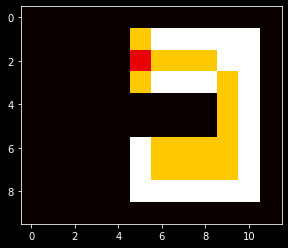

Sample trajectory on learned policy in episode 874:


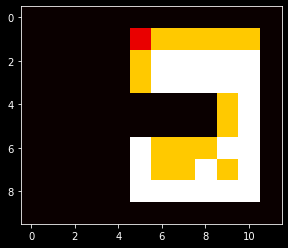

Sample trajectory on learned policy in episode 875:


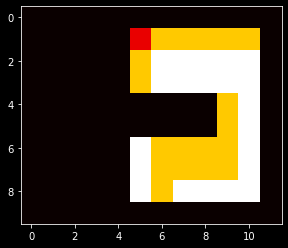

Sample trajectory on learned policy in episode 876:


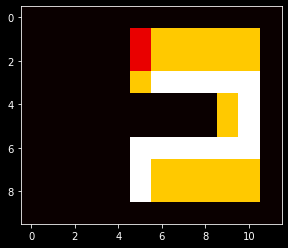

Sample trajectory on learned policy in episode 877:


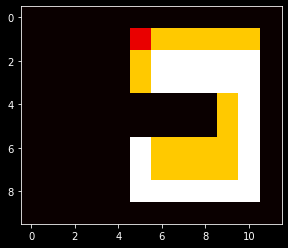

Sample trajectory on learned policy in episode 878:


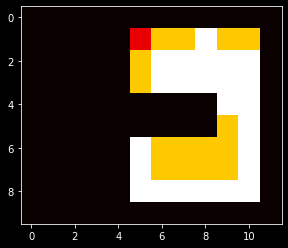



















episode:  88%|█████████████████████████████████████████████████████████████▌        | 879/1000 [01:16<00:10, 11.51it/s]

Sample trajectory on learned policy in episode 879:


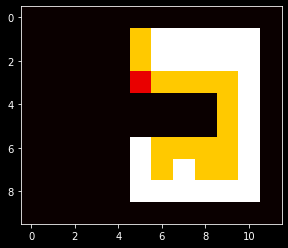

Sample trajectory on learned policy in episode 880:


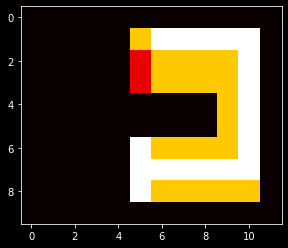

Sample trajectory on learned policy in episode 881:


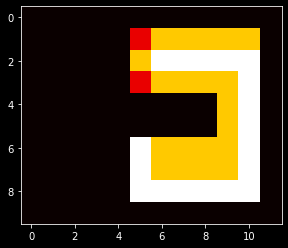

Sample trajectory on learned policy in episode 882:


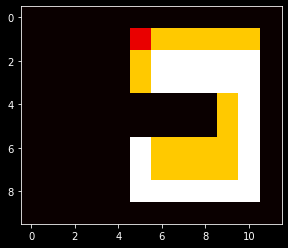

Sample trajectory on learned policy in episode 883:


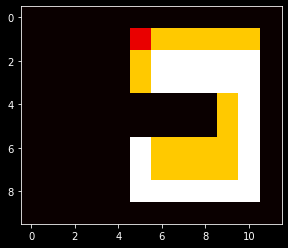

Sample trajectory on learned policy in episode 884:


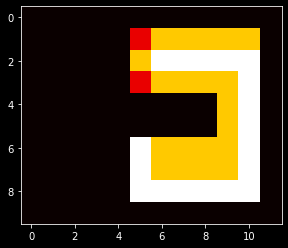

Sample trajectory on learned policy in episode 885:


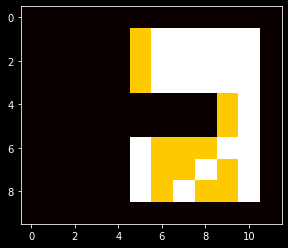

Sample trajectory on learned policy in episode 886:


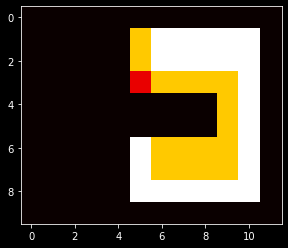

Sample trajectory on learned policy in episode 887:


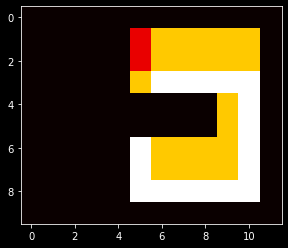

Sample trajectory on learned policy in episode 888:


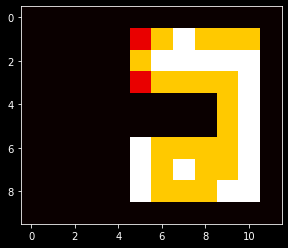

Sample trajectory on learned policy in episode 889:


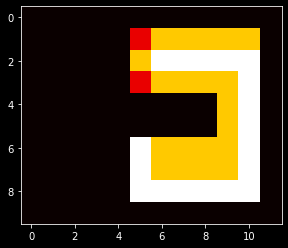

Sample trajectory on learned policy in episode 890:


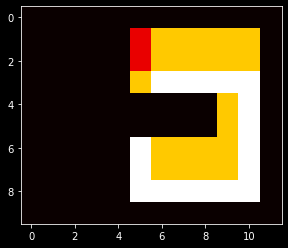

Sample trajectory on learned policy in episode 891:


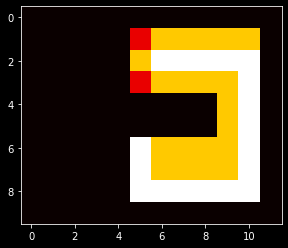

Sample trajectory on learned policy in episode 892:


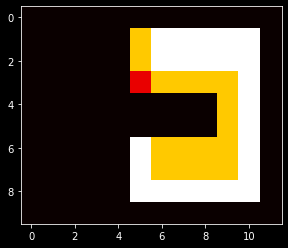

Sample trajectory on learned policy in episode 893:


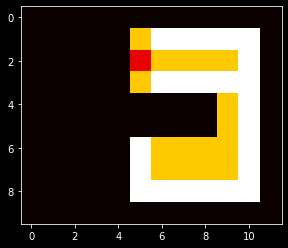

Sample trajectory on learned policy in episode 894:


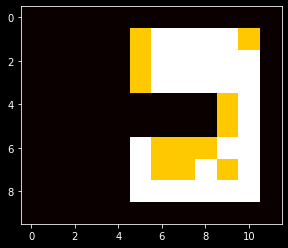

Sample trajectory on learned policy in episode 895:


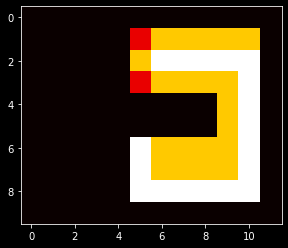

Sample trajectory on learned policy in episode 896:


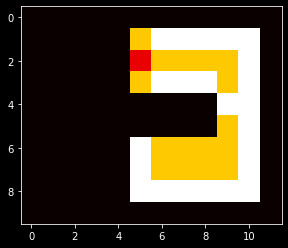

Sample trajectory on learned policy in episode 897:


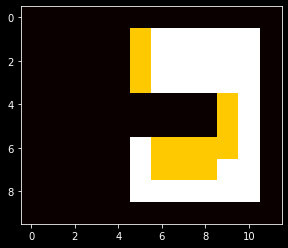

Sample trajectory on learned policy in episode 898:


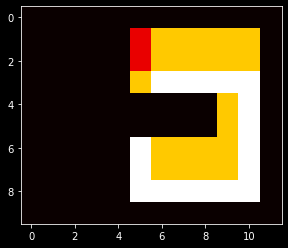

Sample trajectory on learned policy in episode 899:


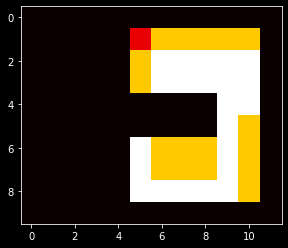

Sample trajectory on learned policy in episode 900:


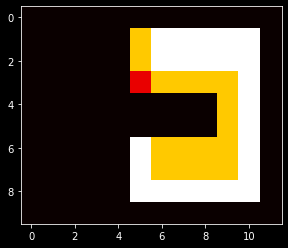

Sample trajectory on learned policy in episode 901:


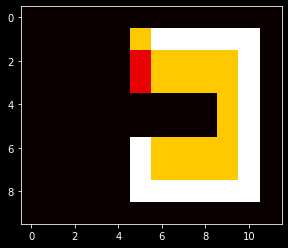

Sample trajectory on learned policy in episode 902:


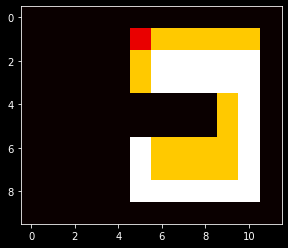



















episode:  90%|███████████████████████████████████████████████████████████████▏      | 903/1000 [01:18<00:08, 11.44it/s]

Sample trajectory on learned policy in episode 903:


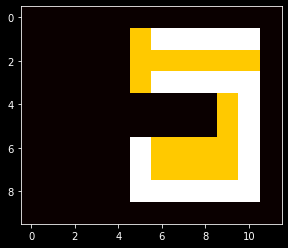

Sample trajectory on learned policy in episode 904:


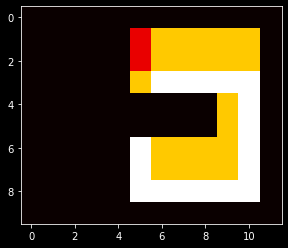

Sample trajectory on learned policy in episode 905:


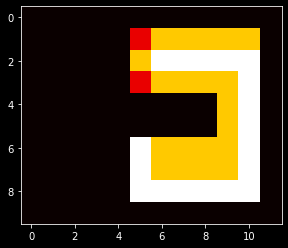

Sample trajectory on learned policy in episode 906:


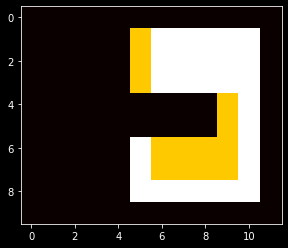

Sample trajectory on learned policy in episode 907:


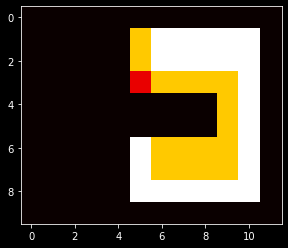

Sample trajectory on learned policy in episode 908:


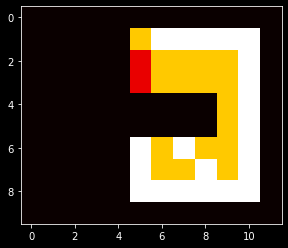

Sample trajectory on learned policy in episode 909:


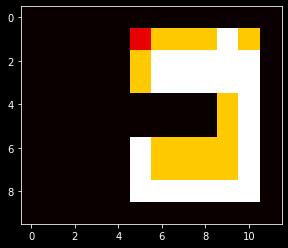

Sample trajectory on learned policy in episode 910:


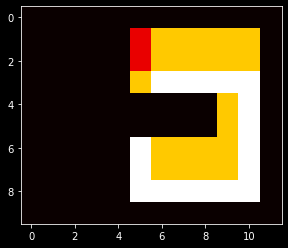

Sample trajectory on learned policy in episode 911:


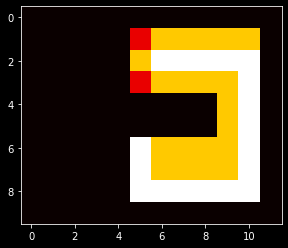

Sample trajectory on learned policy in episode 912:


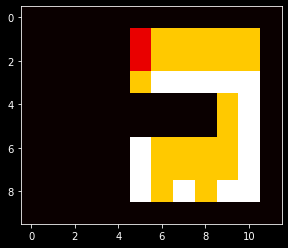

Sample trajectory on learned policy in episode 913:


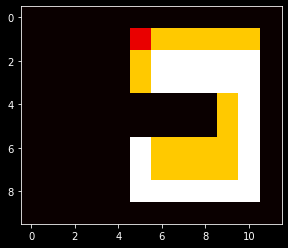

Sample trajectory on learned policy in episode 914:


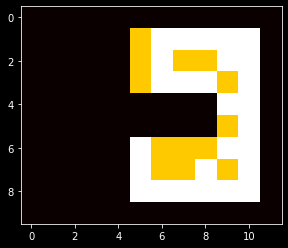

Sample trajectory on learned policy in episode 915:


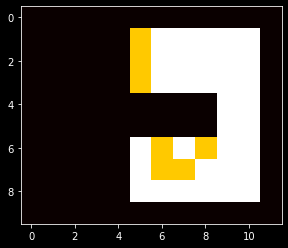

Sample trajectory on learned policy in episode 916:


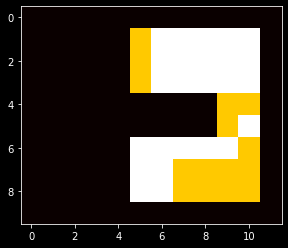

Sample trajectory on learned policy in episode 917:


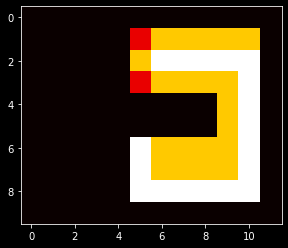

Sample trajectory on learned policy in episode 918:


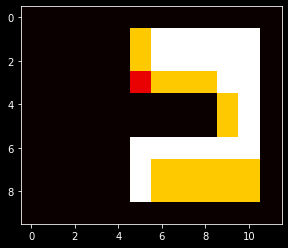

Sample trajectory on learned policy in episode 919:


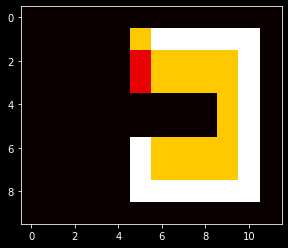

Sample trajectory on learned policy in episode 920:


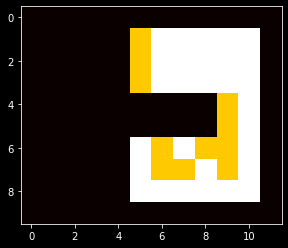

Sample trajectory on learned policy in episode 921:


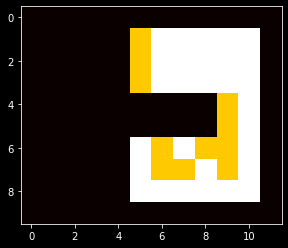

Sample trajectory on learned policy in episode 922:


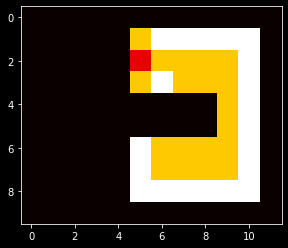

Sample trajectory on learned policy in episode 923:


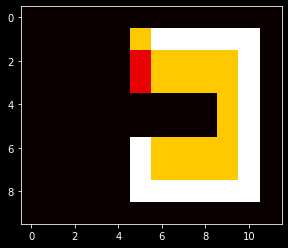

Sample trajectory on learned policy in episode 924:


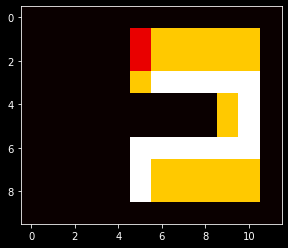

Sample trajectory on learned policy in episode 925:


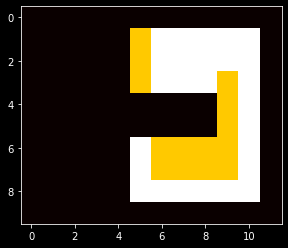

Sample trajectory on learned policy in episode 926:


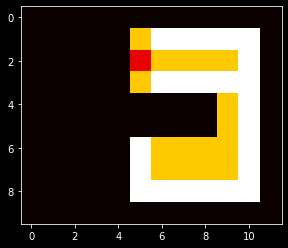



















episode:  93%|████████████████████████████████████████████████████████████████▉     | 927/1000 [01:20<00:06, 11.44it/s]

Sample trajectory on learned policy in episode 927:


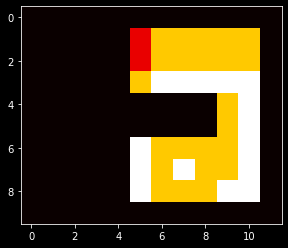

Sample trajectory on learned policy in episode 928:


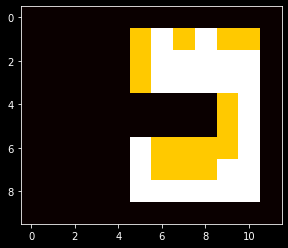

Sample trajectory on learned policy in episode 929:


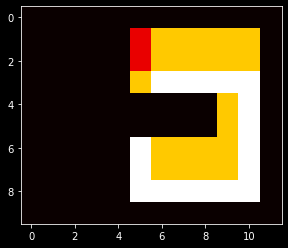

Sample trajectory on learned policy in episode 930:


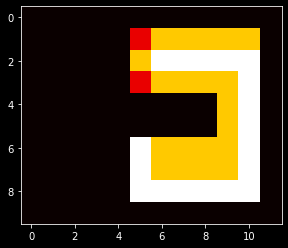

Sample trajectory on learned policy in episode 931:


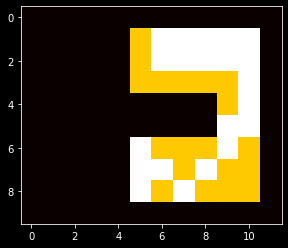

Sample trajectory on learned policy in episode 932:


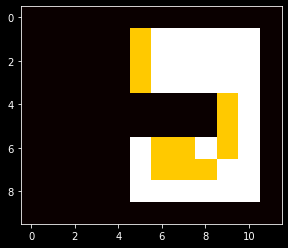

Sample trajectory on learned policy in episode 933:


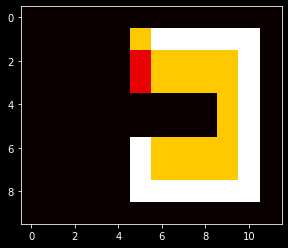

Sample trajectory on learned policy in episode 934:


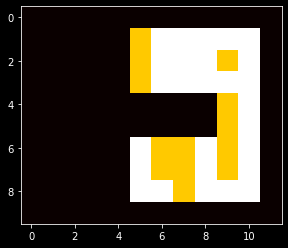

Sample trajectory on learned policy in episode 935:


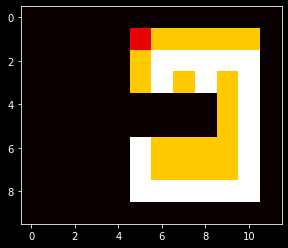

Sample trajectory on learned policy in episode 936:


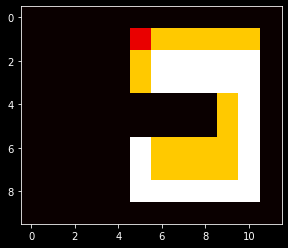

Sample trajectory on learned policy in episode 937:


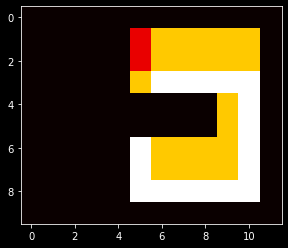

Sample trajectory on learned policy in episode 938:


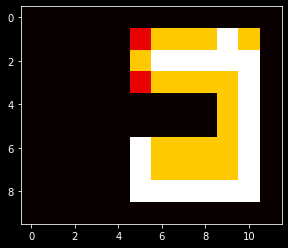

Sample trajectory on learned policy in episode 939:


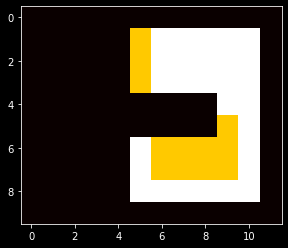

Sample trajectory on learned policy in episode 940:


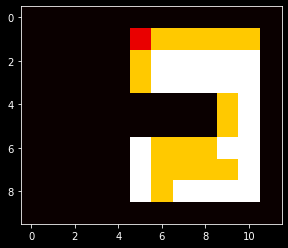

Sample trajectory on learned policy in episode 941:


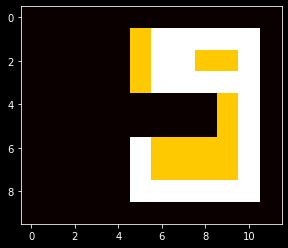

Sample trajectory on learned policy in episode 942:


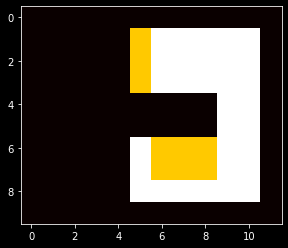

Sample trajectory on learned policy in episode 943:


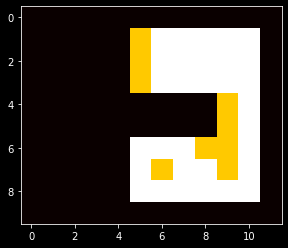

Sample trajectory on learned policy in episode 944:


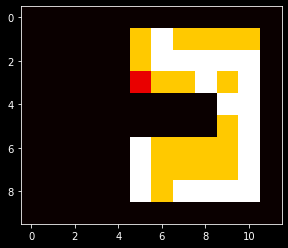

Sample trajectory on learned policy in episode 945:


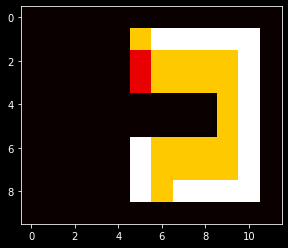

Sample trajectory on learned policy in episode 946:


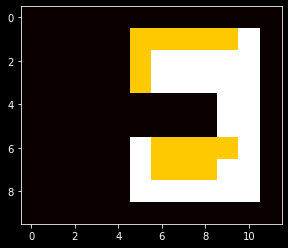

Sample trajectory on learned policy in episode 947:


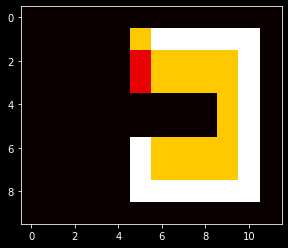

Sample trajectory on learned policy in episode 948:


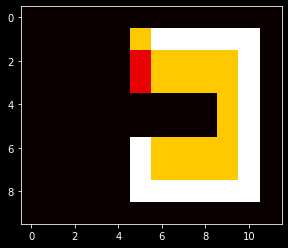

Sample trajectory on learned policy in episode 949:


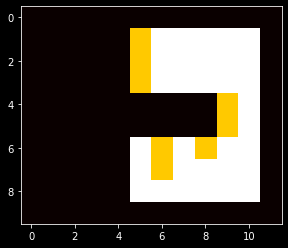



















episode:  95%|██████████████████████████████████████████████████████████████████▌   | 950/1000 [01:22<00:04, 11.45it/s]

Sample trajectory on learned policy in episode 950:


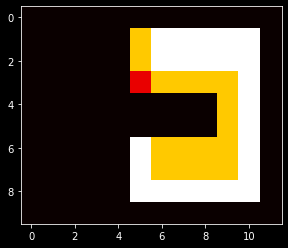

Sample trajectory on learned policy in episode 951:


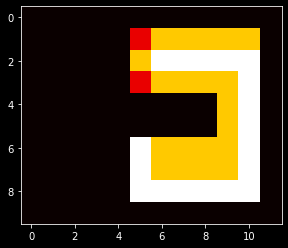

Sample trajectory on learned policy in episode 952:


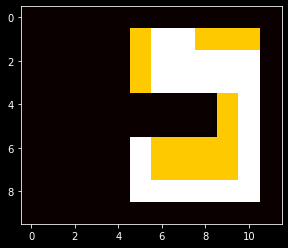

Sample trajectory on learned policy in episode 953:


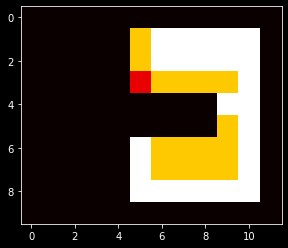

Sample trajectory on learned policy in episode 954:


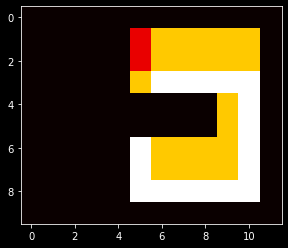

Sample trajectory on learned policy in episode 955:


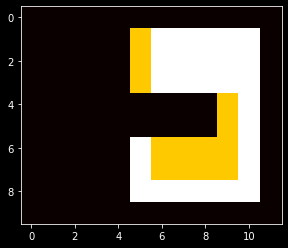

Sample trajectory on learned policy in episode 956:


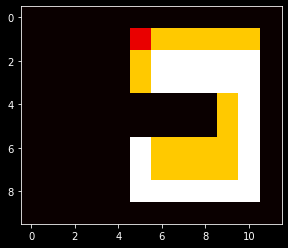

Sample trajectory on learned policy in episode 957:


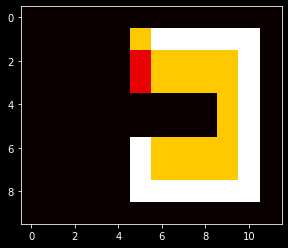

Sample trajectory on learned policy in episode 958:


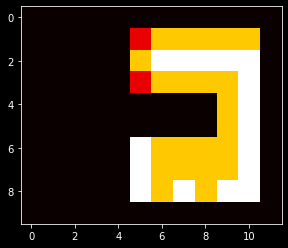

Sample trajectory on learned policy in episode 959:


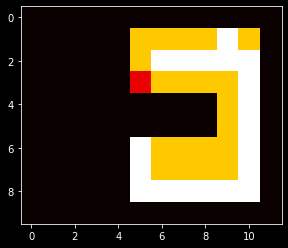

Sample trajectory on learned policy in episode 960:


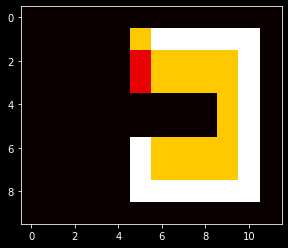

Sample trajectory on learned policy in episode 961:


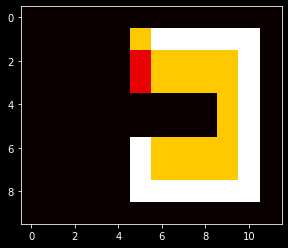

Sample trajectory on learned policy in episode 962:


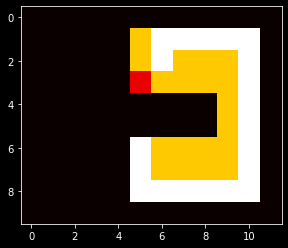

Sample trajectory on learned policy in episode 963:


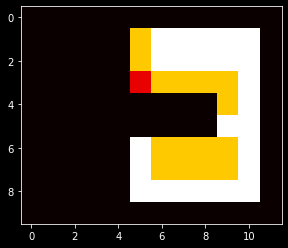

Sample trajectory on learned policy in episode 964:


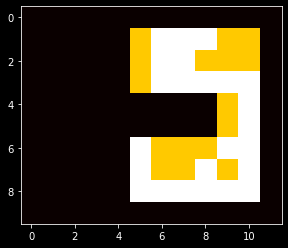

Sample trajectory on learned policy in episode 965:


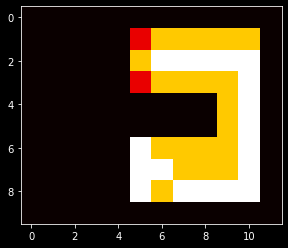

Sample trajectory on learned policy in episode 966:


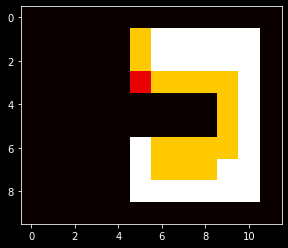

Sample trajectory on learned policy in episode 967:


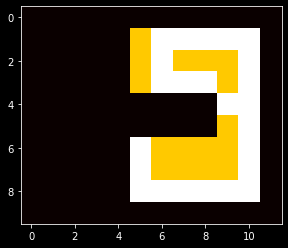

Sample trajectory on learned policy in episode 968:


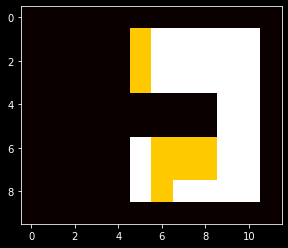

Sample trajectory on learned policy in episode 969:


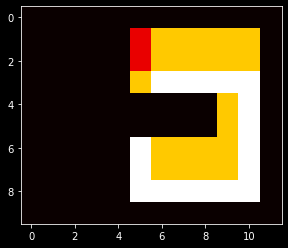

Sample trajectory on learned policy in episode 970:


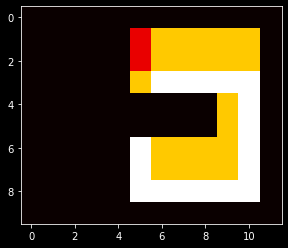

Sample trajectory on learned policy in episode 971:


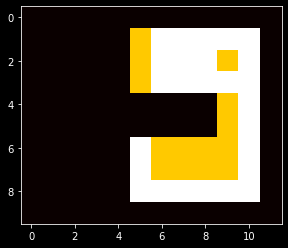

Sample trajectory on learned policy in episode 972:


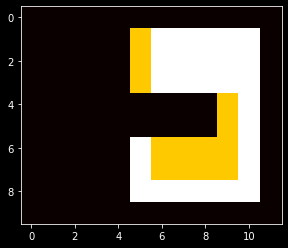

Sample trajectory on learned policy in episode 973:


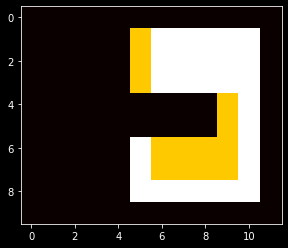



















episode:  97%|████████████████████████████████████████████████████████████████████▏ | 974/1000 [01:24<00:02, 11.48it/s]

Sample trajectory on learned policy in episode 974:


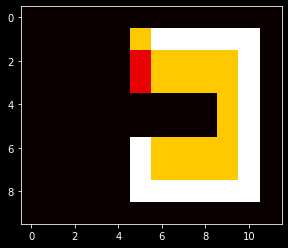

Sample trajectory on learned policy in episode 975:


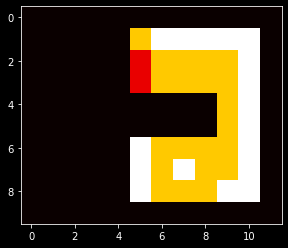

Sample trajectory on learned policy in episode 976:


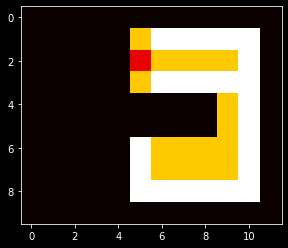

Sample trajectory on learned policy in episode 977:


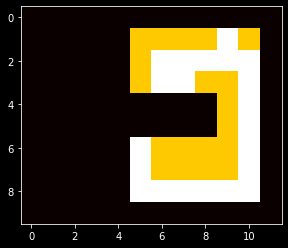

Sample trajectory on learned policy in episode 978:


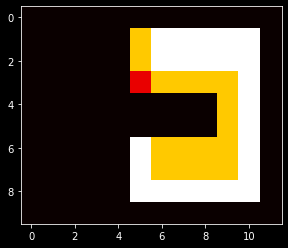

Sample trajectory on learned policy in episode 979:


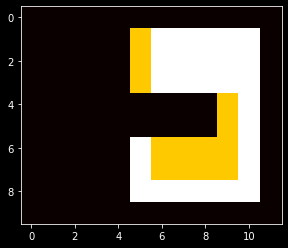

Sample trajectory on learned policy in episode 980:


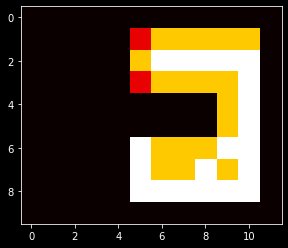

Sample trajectory on learned policy in episode 981:


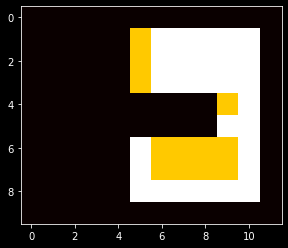

Sample trajectory on learned policy in episode 982:


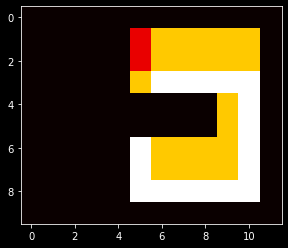

Sample trajectory on learned policy in episode 983:


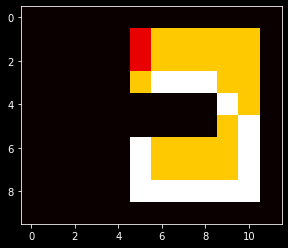

Sample trajectory on learned policy in episode 984:


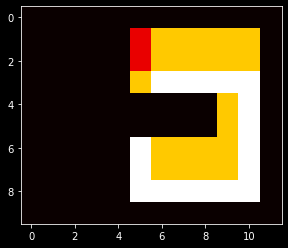

Sample trajectory on learned policy in episode 985:


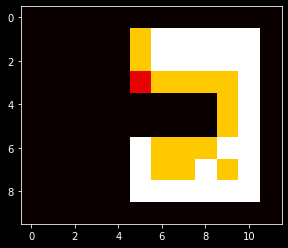

Sample trajectory on learned policy in episode 986:


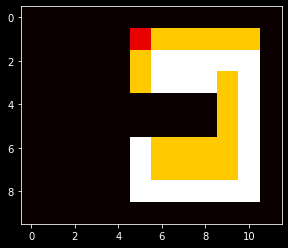

Sample trajectory on learned policy in episode 987:


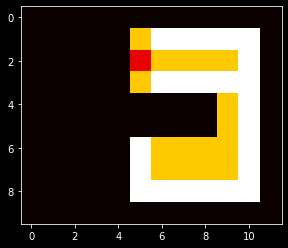

Sample trajectory on learned policy in episode 988:


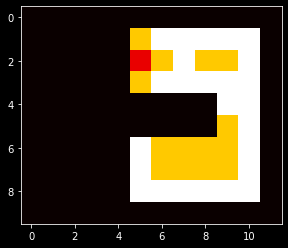

Sample trajectory on learned policy in episode 989:


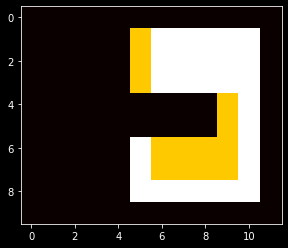

Sample trajectory on learned policy in episode 990:


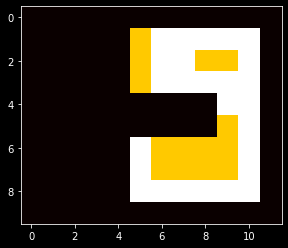

Sample trajectory on learned policy in episode 991:


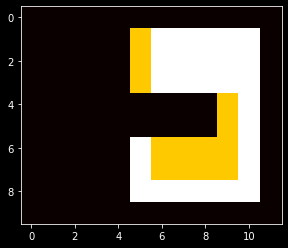

Sample trajectory on learned policy in episode 992:


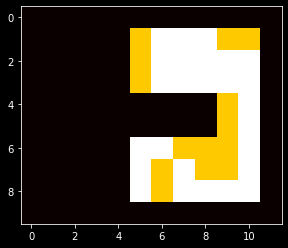

Sample trajectory on learned policy in episode 993:


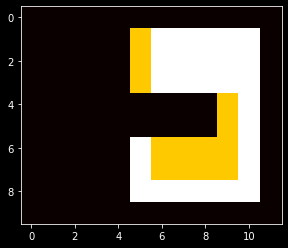

Sample trajectory on learned policy in episode 994:


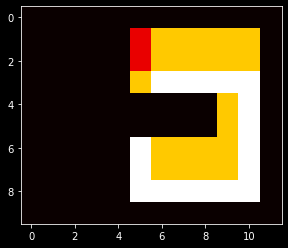

Sample trajectory on learned policy in episode 995:


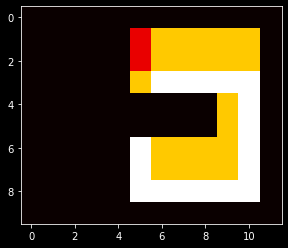

Sample trajectory on learned policy in episode 996:


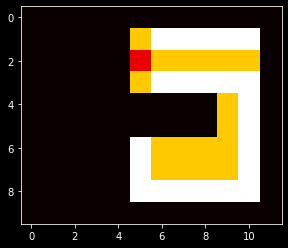

Sample trajectory on learned policy in episode 997:


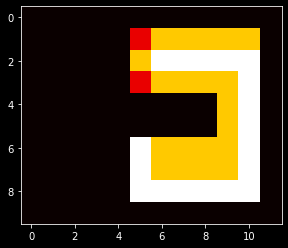



















episode: 100%|█████████████████████████████████████████████████████████████████████▊| 998/1000 [01:26<00:00, 11.53it/s]

Sample trajectory on learned policy in episode 998:


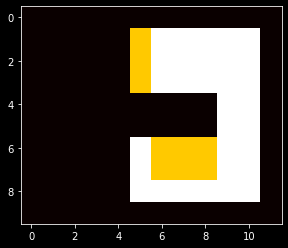

Sample trajectory on learned policy in episode 999:


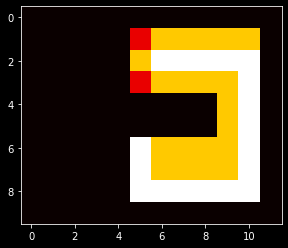

episode: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [01:26<00:00, 11.50it/s]


In [123]:
# initialize action_values and dict of cumulated WIS weights
action_values = np.zeros([track.bounds[0], track.bounds[1], 1+2*track.MAX_VELOCITY, 1+2*track.MAX_VELOCITY, 3, 3])
c_dict = {}

# configuration parameters
# epsilon = 0.1 was defined within the behavior policy
gamma = 1 # discount factor
no_episodes = 1000 # number of evaluated episodes
no_steps = 200 # number of evaluated timesteps per episode

course = course
track = RaceTrackEnv(course)
x_size, y_size = len(course[0]), len(course)

for e in tqdm(range(no_episodes), desc='episode', mininterval=2):
    
    action_states = []
    actions = []
    rewards = []
    
    pos_map = np.zeros((y_size, x_size))
    
    ### BEGIN SOLUTION
    
    p, v = track.reset()
    for k in range(no_steps):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        if epsilon < np.random.rand(1):
            action = np.argmax(behavior_policy[s_y, s_x, s_vy, s_vx])
        else:
            action = random.choice(range(9))
        
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a) # saves the action_state to be used as an index (all values are positive)
        actions.append(a) # saves the action as it is applied (acceleration can be negative)
        action_states.append(action_state)

        (p, v), reward, done, _ = track.step(a)
        
        rewards.append(reward)
        if done:
            break 
    
    # Monte-Carlo WIS Update
    g = 0 
    w = 1        
    for r, a_s, applied_action in zip(rewards[::-1], action_states[::-1], actions[::-1]): # count backwards
        g = gamma * g + r
            
        # Count visits to this state in n_list
        c_dict[a_s] = c_dict.get(a_s, 0) +  w

        # add new return g to existing value
        action_values[a_s] += w/c_dict[a_s] * (g - action_values[a_s])
                        
        # determine greedy policy
        u_best = np.argmax(action_values[a_s[:4]])
        pi[a_s[:4]] = 0
        pi[a_s[:4]][u_best] = 1
        
        # check if performed action equals greedy action
        if applied_action != track.action_to_tuple(u_best):
            break
        
        w = w * 1/behavior_policy[a_s[:4]][u_best]
    
    # END SOLUTION
    
    # code fragment for plotting      
    pos_map = (pos_map > 0).astype(np.float32)
    pos_map +=  track.course  # overlay track course
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    plot_pos_map(pos_map)

Done
Sample trajectory on learned policy in episode 0:


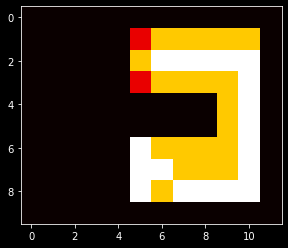

Done
Sample trajectory on learned policy in episode 1:


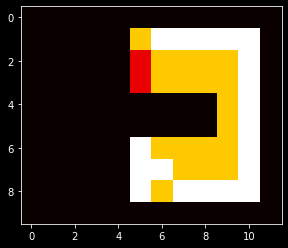

Done
Sample trajectory on learned policy in episode 2:


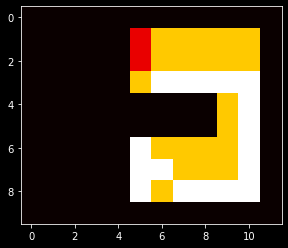

Done
Sample trajectory on learned policy in episode 3:


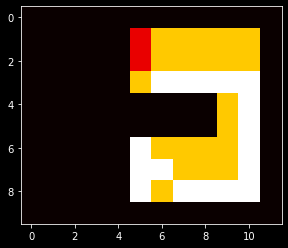

Done
Sample trajectory on learned policy in episode 4:


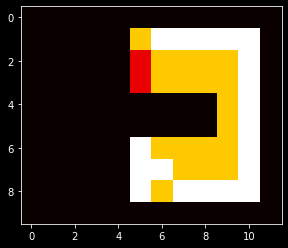

Done
Sample trajectory on learned policy in episode 5:


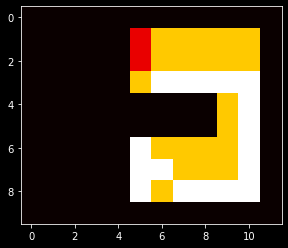

Done
Sample trajectory on learned policy in episode 6:


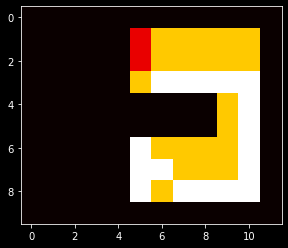

Done
Sample trajectory on learned policy in episode 7:


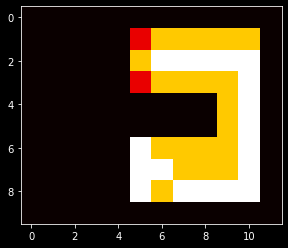

Done
Sample trajectory on learned policy in episode 8:


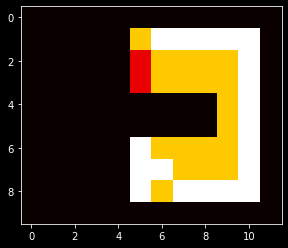

Done
Sample trajectory on learned policy in episode 9:


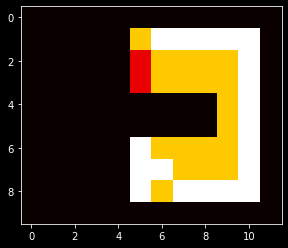

In [125]:
episodes = 10
for e in range(episodes):
    
    pos_map = np.zeros((y_size, x_size))
    p, v = track.reset()
    for k in range(200):
        s_y, s_x = p[0], p[1]
        s_vy, s_vx = v[0], v[1]
        
        pos_map[s_y, s_x] += 1  # exploration map
        
        action = np.argmax(pi[s_y, s_x, s_vy, s_vx])
        
        a = track.action_to_tuple(action)
        action_state = track.state_action((p, v), a)

        (p, v), reward, done, _ = track.step(a)

        if done:
            print('Done')
            break 

            
    print('Sample trajectory on learned policy in episode {}:'.format(e))
    pos_map = (pos_map > 0).astype(np.int16)
    pos_map +=  track.course  # overlay track course
    plot_pos_map(pos_map)

## 4) Extra Challenge: A More Complex Course

The course given below poses a substantially harder challenge for Monte-Carlo based algorithms. Why? If you want to try solving it yourself, be aware that it may take much longer until a successful policy is found.

WWWWWWWWWWWW
Woooo+W-oooW
Woooo+W-oooW
Woooo+W-oooW
WooWWWWWWooW
WooWWWWWWooW
WooooooooooW
WooooooooooW
WooooooooooW
WWWWWWWWWWWW


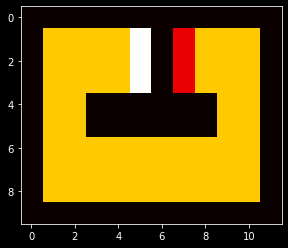

In [50]:
# Build the course
_course_dim = (8, 10)
_inner_wall_dim = (2, 6)

def build_rect_course(course_dim, inner_wall_dim):
    """
    Build a race track given specifications for the outer cyclic street and inner wall dimensions.
    Start and finish line should be placed in the center top. The course dimension specifications
    do not consider a bounding wall around the track, which must be inserted additionally.
    
    Args:
        course_dim: 2-tuple, (y-dim, x-dim): The size of the track without outer walls.
        inner_wall_dim: 2-tuple (y-dim, x-dim): The size of the inner wall
    
    """
    track = []
    wall_up_bound = course_dim[0]//2 - inner_wall_dim[0] // 2
    wall_bottom_bound = course_dim[0]//2 + inner_wall_dim[0]//2
    street_width = course_dim[1]//2 - inner_wall_dim[1]//2
    # construct course line by line
    for i in range(course_dim[0]):
        if i < wall_up_bound:
            half_street_len = course_dim[1]//2 - 1
            track_row = 'o'*half_street_len + '+W-' + 'o'*(half_street_len-1)
        elif  wall_up_bound <= i < wall_bottom_bound:
            track_row = 'o'*street_width + 'W'*inner_wall_dim[1] + 'o'*street_width
        else:
            track_row = 'o'*course_dim[1]
        track.append(track_row)
    # add boundary
    track = ['W'*course_dim[1]] + track + ['W'*course_dim[1]]
    track = ['W'+s+'W' for s in track]
    return track
    
course = build_rect_course(_course_dim, _inner_wall_dim)
track = RaceTrackEnv(course)
for row in course:
    print(row)
    
pos_map =  track.course  # overlay track course
plot_pos_map(pos_map)

## 4) Solution

Taking four turns to reach the goal is way harder than taking just two turns. Additionally, the state space is a lot larger now, which leads to much more exploration being necessary until all the states are properly evaluated. Although the course is more complicated, the problem description ("reach the goal") and the evironment physics (acceleration, momentum and collision) are still the same. Thus, there is no fundamental reason why Monte-Carlo should not be successful here, we just have to be aware that it will take some time.

Fortunately, there are still upcoming lectures where more efficient learning algorithms could be discussed ;)

The following screenshot was taken after trying to solve this problem with the same algorithm as presented in task 2). As can be seen, the agent is actually able to solve the racetrack and reach the finish line. But it took about six hours on a very powerful computer to do so.

![](FullCourse_MonteCarlo_Solved.png)